In [1]:
import os
import time
import errno
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import mean
from log_parser import log_parser
from mpl_toolkits.mplot3d import Axes3D

# Settings of Jupyter notebook HTML

In [2]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width: 100% !important; }</style>"))
display(HTML("<style>.container { font-size: 9.5px; !important; }</style>"))
display(HTML("<style>.rendered_html { font-size: 15px; color: red; }</style>"))
display(HTML("<style>.rendered_markdown { color: red; }</style>"))

# Initialization
### Pathes

In [2]:
default_file_name = 'dumpState.log'
file_name = 'G981V_TIE_3GMEM_30CPU_dumpstate_bottleneck_hint.txt'

#lp = log_parser('/home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/dumpState_1593794288665.log')
lp = log_parser('/home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/{}'.format(default_file_name))

NameError: name 'log_parser' is not defined

In [4]:
pData1 = [
    'MEMORY INFO', 
    'MEMSIZE INFO', 
    'SERVICE CRITICAL cpuinfo',
    'SERVICE CRITICAL SurfaceFlinger',
    'compressed core&heap dump',
    'SYSTEM LOG',
    'EVENT LOG',
    'KERNEL LOG',
    'LAST KMSG',
    'AP RESET INFO',
    'FILESYSTEMS & FREE SPACE',
    'SERVICE content',
    'SERVICE dropbox',
    'SERVICE accessibility',
    'SERVICE batterystats',
    'SERVICE HIGH meminfo',
    'SERVICE package',
    'SERVICE binder_calls_stats',
    'SERVICE wifi',
    'SERVICE procstats',
    'OLOG',
    'ACTIVITY MANAGER MARs',
    'ACTIVITY MANAGER PENDING INTENTS',
    'ACTIVITY MANAGER BROADCAST STATE',
    'ACTIVITY MANAGER LMK KILLS',
    'STORAGE BUFFER',
    'SYSTEM PROPERTIES',
    'CPU INFO',
    'VM TRACES JUST NOW',
    'MMC blk0 error',
    'DUMP OF SERVICE connmetrics',
    'DUMP OF SERVICE gfxinfo',
    'DUMP OF SERVICE display',
    'DUMP OF SERVICE telephony.registry',
    'DUMP OF SERVICE wifiscanner',
    'DUMP OF SERVICE binder_calls_stats',
    'LOG STATISTICS',
    'TSP RAW DATA',
    'beginning of main',
    'STORAGED IO INFO',
    'SEC LOG',
]

lp.run(arg1=pData1)

#display(lp.log_sections)

### Values

### Functions

In [5]:
def grep(lines, searchers, n=99999, show=True):
    result = list()
    number_of_lines = 0

    for line in lines:
        if len(line) > 0:
            for searcher in searchers:
                if re.search(searcher, line):
                    number_of_lines = n
            if number_of_lines > 0:
                if show:
                    print(line.strip())
                result.append(line.strip())
                number_of_lines -= 1
                #if number_of_lines == 0:
                    #print("\n")
                    #result.append('')
                    
    if len(result) == 0:
        print("--- Nothing ---")
        
    return result

In [6]:
def pickedup(src, searcher, index=0):
    separators = ['/', ',', ' ']
    
    if searcher not in src:
        return None
    
    splited = src.split(searcher)
    if splited <= 0:
        return None
    
    numbers = re.findall('\d+', splited[1])
    if len(numbers) > index:
        return int(numbers[index])
    
    return None

In [7]:
def DictFromPickedUp(src, searchers):
    result = dict()
    for key in searchers.keys():
        result[key] = list()

    tmp = dict()
    for line in src:
        flag = False
        for key in searchers.keys():
            tmp[key] = pickedup(line, key, searchers[key])
            if tmp[key] is None:
                flag = True

        if flag == True:
            continue

        for key in searchers.keys():
            result[key].append(tmp[key])
            
    return result

In [8]:
def orderbyeq(src, index=0):
    result = dict()
    items = re.split('[ ]', src)
    for item in items:
        if '=' in item and item[0] == '[':
            item = item[1:]
            splited = item.split('=')
            key = splited[0]
            numbers = re.findall('\d+', splited[1])
            if numbers > 0:
                result[key] = int(numbers[0])
                
    return result

In [9]:
def DataframeFromDictSortByCount(rawdata):
    df = pd.DataFrame.from_dict(rawdata, orient='index')
    df['count'] = df.count(axis=1, numeric_only=True)
    df = df.sort_index(by='count', axis=0, ascending=False)
    df = df.drop(columns=['count'])    
    return df

In [10]:
def PlotFromDict(rawdata, threshold, title='', ylabel=''):
    df = pd.DataFrame.from_dict(rawdata, orient='index')
    for key in df.index:
        if max(rawdata[key]) > threshold:
            s = pd.Series(rawdata[key])
            ax = s.plot(figsize=(30,5), label=key, legend=True)
            ax.axhline(y=threshold, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
            ax.set_title(title)
            ax.set_ylabel(ylabel)

In [11]:
def MarkupLCDON(lines):
    LCD_ON = list()
    marker = ''
    for line in lines:
        if re.search('LCD', line):
            if re.search(' ON ', line):
                LCD_ON.append(line)
                marker = ' LCDON >>> '
                print(line)
            elif re.search(' OFF ', line):
                LCD_ON.append(line)
                marker = ''
                print(line)
        else:
            LCD_ON.append(marker + line)
            print(marker + line)
    return LCD_ON

In [12]:
def str2num(string):
    try:
        number = int(string)
    except:
        number = -1
        
    return number

def GetTime(line, type=None):
    Days = [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    splited_items = line.split(' ')
    Date = 0
    for item in splited_items:
        if Date == 0:
            if len(item) > 4 and item[-3] is '-':
                Month = str2num(item[-5:-3])
                Day = str2num(item[-2:])
                if Month >= 0 and Day >= 0 :
                    Date = (Month * Days[Month] + Day) * 24 * 60 * 60 * 1000
        else:
            if type is 'SSRM':
                item += '.000'

            if len(item) > 11 and item[2] is ':' and item[5] is ':' and item[8] is '.':
                Hour = str2num(item[0:2])
                Minute = str2num(item[3:5])
                Second = str2num(item[6:8])
                MiliSecond = str2num(item[9:12])
                if Hour >= 0 and Minute >= 0 and Second >= 0 and MiliSecond >= 0:
                    return Date + ((Hour * 60 + Minute) * 60 + Second) * 1000 + MiliSecond
            Date = 0
            
    return -1

def GetKernelTime(line):
    splited = line.split('[')
    splited = splited[1].split(']')
    splited = splited[0].split('.')

    second = str2num(splited[0])
    if second < 0:
        return -1
    
    nanosecond = str2num(splited[1])
    if nanosecond < 0:
        return -1
    
    return (int)(second * 1000 + (int)(nanosecond / 1000))

# <span style="color:blue">Base</span> 

In [13]:
lines = lp.log_sections['SERVICE content']
tmp = grep(lines,['Uptime'], 1)

Uptime: 12m39s


In [14]:
lines = lp.log_sections['DUMP OF SERVICE display']
tmp = grep(lines,['mDefaultViewport'], 1)

--- Nothing ---


In [15]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['dumpstate: begin', 'dumpstate: done', 'Dumpstate info: id', 'dumpstate: do_zip_file'], 1)

02-05 10:38:38.201  root  8452  8452 I dumpstate: do_zip_file: 0 do_vibrate: 0 use_socket: 1 use_control_socket: 0 do_screenshot: 0 is_remote_mode: 0 show_header_only: 0 do_start_service: 0 telephony_only: 0 wifi_only: 0 do_progress_updates: 0 fd: -1 bugreport_mode: BUGREPORT_DEFAULT dumpstate_hal_mode: DEFAULT limited_only: 0 args: /system/bin/dumpstate -s


* 16xxxxxx ns : 60 hz 
* 8xxxxxx ns : 120 hz

In [16]:
lines = lp.log_sections['compressed core&heap dump']
tmp = grep(lines,['VSYNC period'], 1)
lines = lp.log_sections['SERVICE CRITICAL SurfaceFlinger']
tmp = grep(lines,['VSYNC period'], 1)

present offset:         0 ns	     VSYNC period:  16666666 ns
--- Nothing ---


* the number of installed packages

In [17]:
lines = lp.log_sections['ACTIVITY MANAGER MARs']
tmp = grep(lines,['mManagedPackage'], 1)

mManagedPackages --- size 101


In [18]:
lines = lp.log_sections['SYSTEM PROPERTIES']
tmp = grep(lines,['debug_level'], 1)

[ro.boot.debug_level]: [0x4f4c]
[ro.debug_level]: [0x4f4c]
[ro.vendor.boot.debug_level]: [0x4f4c]


* Calculation for gap between android time and kernel time.

In [19]:
lines = lp.log_sections['KERNEL LOG']
sync_logs = grep(lines,['@Sync'], 1, show=True)

gapoftime = list()
for sync_log in sync_logs:
    androidtime = GetTime(sync_log)
    kerneltime = GetKernelTime(sync_log)

    if androidtime < 0 or kerneltime < 0:
        continue

    print("{} - {} = {}").format(androidtime, kerneltime, androidtime - kerneltime)
    gapoftime.append(androidtime - kerneltime)

GAP_OF_TIME = int(mean(gapoftime) + 0.5)
#display(gapoftime)
display("Average : {}".format(GAP_OF_TIME))
GAP_OF_TIME = gapoftime[0]
display("Current : {}".format(GAP_OF_TIME))

<6>[  367.159482]  [7:       watchdog: 1124] !@Sync 12 [2020-10-12 20:29:22.786] FD count : 844, wdog_way : softdog
<6>[  397.169681]  [1:       watchdog: 1124] !@Sync 13 [2020-10-12 20:29:52.796] FD count : 845, wdog_way : softdog
<6>[  427.180029]  [0:       watchdog: 1124] !@Sync 14 [2020-10-12 20:30:22.806] FD count : 850, wdog_way : softdog
<6>[  457.182863]  [7:       watchdog: 1124] !@Sync 15 [2020-10-12 20:30:52.810] FD count : 847, wdog_way : softdog
<6>[  487.184655]  [7:       watchdog: 1124] !@Sync 16 [2020-10-12 20:31:22.812] FD count : 852, wdog_way : softdog
<6>[  517.192096]  [1:       watchdog: 1124] !@Sync 17 [2020-10-12 20:31:52.819] FD count : 851, wdog_way : softdog
<6>[  547.196382]  [6:       watchdog: 1124] !@Sync 18 [2020-10-12 20:32:22.823] FD count : 851, wdog_way : softdog
<6>[  577.204663]  [0:       watchdog: 1124] !@Sync 19 [2020-10-12 20:32:52.831] FD count : 850, wdog_way : softdog
<6>[  607.215173]  [2:       watchdog: 1124] !@Sync 20 [2020-10-12 20:33

'Average : 27894195627'

'Current : 27894195627'

# <span style="color:blue">CPU</span> 

The sampling time should be checked.
If the term is short, the cpu usage infor is not important.

In [20]:
lines = lp.log_sections['SERVICE batterystats']
CPU_freqs = grep(lines,['CPU freqs'], 1)
CPU_MAX_FREQ = 2000000

if len(CPU_freqs) > 0:
    CPU_MAX_FREQ = 0
    CPU_FREQ_TABLE = CPU_freqs[0].split(':')[1]
    for CPU_freq in CPU_FREQ_TABLE.split(' '):
        if len(CPU_freq) > 0:
            num_cpu_freq = int(CPU_freq)
            if num_cpu_freq > CPU_MAX_FREQ:
                CPU_MAX_FREQ = num_cpu_freq
    print('Max CPU Freq : ' + str(CPU_MAX_FREQ))

CPU freqs: 1950000 1846000 1742000 1586000 1456000 1300000 1157000 1053000 949000 806000 650000 546000 442000 2314000 2210000 2106000 2002000 1898000 1794000 1690000 1586000 1508000 1404000 1222000 1066000 962000 845000 754000 650000 507000 2730000 2600000 2530000 2470000 2340000 2236000 2080000 1976000 1820000 1664000 1560000 1456000 1378000 1248000 1144000 1040000 936000 819000 728000 624000 520000
Max CPU Freq : 2730000


In [21]:
display(lp.log_sections['SERVICE CRITICAL cpuinfo'][:15])

['DUMP OF SERVICE CRITICAL cpuinfo:\n',
 'Load: 10.58 / 3.06 / 1.06\n',
 'CPU usage from 61539ms to 35016ms ago (2021-02-05 10:36:46.314 to 2021-02-05 10:37:39.485) with 49% awake:\n',
 '  21% 452/f2fs_discard-25: 0% user + 21% kernel\n',
 '  17% 979/system_server: 10% user + 6.6% kernel / faults: 21140 minor 23 major\n',
 '  6.6% 1367/com.android.systemui: 5% user + 1.5% kernel / faults: 6734 minor 10 major\n',
 '  5% 2809/com.google.android.gms: 3.9% user + 1% kernel / faults: 10533 minor 52 major\n',
 '  3.8% 485/android.system.suspend@1.0-service: 0% user + 3.8% kernel / faults: 7 minor\n',
 '  2.9% 1352/com.android.phone: 2.3% user + 0.6% kernel / faults: 7211 minor 17 major\n',
 '  2.4% 231/sugov:0: 0% user + 2.4% kernel\n',
 '  1.9% 392/ueventd: 1.5% user + 0.4% kernel / faults: 35 minor\n',
 '  1.4% 628/surfaceflinger: 0.8% user + 0.6% kernel / faults: 11 minor\n',
 '  1.3% 198/kworker/u18:1: 0% user + 1.3% kernel\n',
 '  1% 220/kworker/0:2H: 0% user + 1% kernel\n',
 '  1% 535/

In [22]:
lines = lp.log_sections['CPU INFO']
CPU_freqs = grep(lines,['Threads'], 15)

Threads: 3598 total,   1 running, 3597 sleeping,   0 stopped,   0 zombie
Mem:      7.2G total,      6.7G used,      494M free,      107M buffers
Swap:      2.5G total,      680M used,      1.8G free,      3.2G cached
800%cpu  19%user   0%nice  77%sys 697%idle   0%iow   0%irq   8%sirq   0%host
PID   TID USER         PR  NI[%CPU]S VIRT  RES PCY CMD             NAME
32289 32289 shell         0 -20 67.1 R  39M 7.6M  fg top             top
129   129 root         20   0 12.5 S    0    0  fg kswapd0         [kswapd0]
3871  3871 u0_a266      10 -10  6.2 S 7.5G 379M  ta ung.android.voc com.samsung.android.voc
1048  4909 system       20   0  3.1 S  12G 730M  fg Binder:1048_1E  system_server
571   615 system       -3  -9  3.1 S 1.5G  40M  fg DispSync        surfaceflinger
571   617 system       -3  -8  3.1 S 1.5G  40M  fg app             surfaceflinger
227   227 root         RT   0  3.1 S    0    0  fg sugov:6         [sugov:6]
226   226 root         RT   0  3.1 S    0    0  fg sugov:4         [s

# <span style="color:blue">PACKAGES</span> 

* Installed Packages and version.

In [23]:
lines = lp.log_sections['SERVICE package']
package_lines = grep(lines,['Package \[', 'versionName'], 1)

Package [com.amazon.mShop.android.shopping] (b7b1795):
versionName=20.20.0.100
Package [com.samsung.android.provider.filterprovider] (1f5174f):
versionName=5.0.14
Package [com.sec.android.app.DataCreate] (4c8c2d9):
versionName=1.0
Package [com.android.cts.priv.ctsshim] (135ea78):
versionName=9-5374186
Package [com.sec.android.widgetapp.samsungapps] (6eb0eb7):
versionName=1.7.13.2
Package [com.samsung.android.smartswitchassistant] (88f2edc):
versionName=1.1.06
Package [com.sec.vsim.ericssonnsds.webapp] (4bec267):
versionName=1.3.05.0
Package [com.sec.android.app.setupwizardlegalprovider] (d7d9e7a):
versionName=2.0.05.0
Package [com.google.android.youtube] (3b012c):
versionName=15.40.37
Package [com.samsung.android.app.galaxyfinder] (5e29e4c):
versionName=9.5.26
Package [com.sec.location.nsflp2] (f662be5):
versionName=5.0.26
Package [com.samsung.android.themestore] (5e1e5cb):
versionName=5.1.21.806
Package [com.sec.android.app.chromecustomizations] (9d74bbf):
versionName=3.0.25
Package [

* Search the name of installed package and version.

In [24]:
tmp = grep(package_lines,['ncsoft'], 2)

--- Nothing ---


total 572 packages


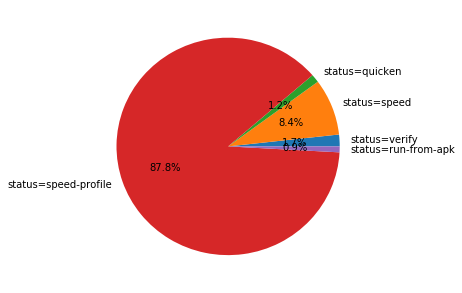

In [25]:
dexopt_lines = lp.log_sections['SERVICE package']
status_lines = grep(dexopt_lines,['status='], 1, show=False)

dexopt_state = dict()
for line in status_lines:
    if 'compilation_filter' in line:
        splited_line = line.split(',')
        status = splited_line[-1]
        dexopt_state[status] = dexopt_state.get(status, 0) + 1
    else:
        splited_line = line.split('[')
        if len(splited_line) > 0 and 'status' in splited_line[1]:         
            status = splited_line[1][:-2]
            dexopt_state[status] = dexopt_state.get(status, 0) + 1

#df.plot.pie(y='0', figsize=(5, 5), autopct='%1.1f%%', startangle=100)
print("total {} packages".format(len(status_lines)))
plt.figure(figsize=(5, 5))
plt.pie(dexopt_state.values(), labels = dexopt_state.keys(), autopct='%1.1f%%') 
plt.show() 

* kr.co.avad.diagnostictool app is uesed in A/S center.
* com.rsupport.rs.activity.rsupport.aas2 is remote service app.

In [25]:
lines = ssrm.file_lines
tmp = grep(lines,['kr.co.avad.diagnostictool', 'com.rsupport.rs.activity.rsupport.aas2'], 1)

--- Nothing ---


In [26]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Choreographer: skipped'], 1)

--- Nothing ---


* Bad apps

The PUBG game(com.tencent.ig) app have performance problem with LSI Ramen chip.

 4: name='Window{f7a5252 u0 com.autoclicker.clicker}', displayId=0, paused=false, hasFocus=false, hasWallpaper=false, visible=true, canReceiveKeys=false, flags=0x00000518, type=0x000007f6, samsungFlags=0x00000000, layer=121205, frame=[360,640][440,720], scale=1.000000, touchableRegion=[360,640][440,720], pTouchableRegion=<empty>, inputFeatures=0x00000000, ownerPid=2763, ownerUid=10837, dispatchingTimeout=5000.000ms

In [27]:
lines = ssrm.file_lines
com_lines = grep(lines,['com.cashwalk.cashwalk', 'com.tencent.ig'], 1, show=True)

--- Nothing ---


In [28]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['com.autoclicker.clicker'], 1)

--- Nothing ---


* Youtube known issue.<br>
b/155941392 [Youtube] Frequent GC operation and it causes sluggish on device

In [28]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['ImageManager: cannot preload image. Invalid dimensions given'], 1)

--- Nothing ---


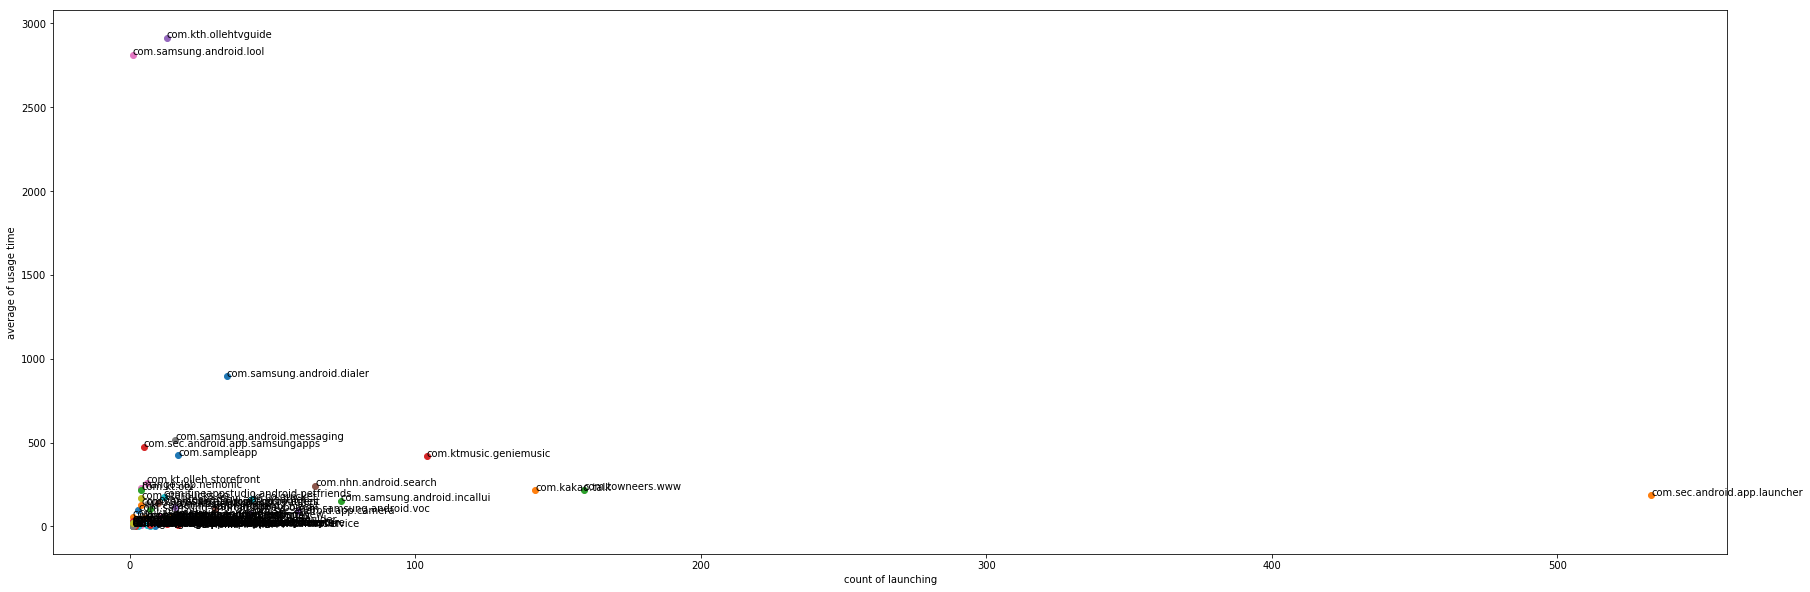

count of launching  \
com.sec.android.app.launcher                               533   
com.towneers.www                                           159   
com.kakao.talk                                             142   
com.ktmusic.geniemusic                                     104   
com.samsung.android.incallui                                74   
com.nhn.android.search                                      65   
com.samsung.android.voc                                     59   
kr.co.quicket                                               43   
com.sec.android.app.camera                                  42   
com.samsung.android.dialer                                  34   
com.appgenix.bizcal                                         30   
com.android.settings                                        24   
com.sampleapp                                               17   
com.sec.android.gallery3d                                   17   
kr.go.nema.disasteralert_new                                16   
com.samsung.android.messaging                               16   
com.kbstar.kbbank                                           16   
com.samsung.android.spay                                    15   
net.daum.android.map                                        15   
com.kth.ollehtvguide                                        13   
com.android.chrome                                          13   
com.shinhan.sbanking                                        13   
com.fineappstudio.android.petfriends                        12   
com.infraware.office.link                                   11   
com.lifeoverflow.app.weather                                10   
com.samsung.android.app.homestar                             9   
com.kbstar.liivbank                                          8   
kr.co.adt.fnsys.viewguard                                    7   
com.android.printspooler                                     7   
android                                                      7   
...                                                        ...   
com.android.vending                                          4   
com.kt.otv                                                   4   
com.samsung.android.video                                    4   
com.samsung.android.app.telephonyui                          3   
com.dbs.kurly.m2                                             3   
mok.android                                                  3   
com.samsung.android.goodlock                                 3   
com.samsung.android.honeyboard                               3   
com.sec.android.app.popupcalculator                          3   
com.sec.android.app.myfiles                                  2   
com.fourspeak.columbooks                                     2   
com.chanel.fnb.kapp                                          2   
com.google.android.permissioncontroller                      2   
co.benx.weply                                                2   
com.samsung.app.newtrim                                      1   
com.samsung.android.net.wifi.wifiguider                      1   
com.samsung.android.secsoundpicker                           1   
com.kt.ktauth                                                1   
com.google.android.packageinstaller                          1   
com.netflix.mediaclient                                      1   
com.samsung.android.app.contacts                             1   
com.coupang.mobile                                           1   
com.kbstar.starpush                                          1   
com.samsung.android.lool                                     1   
com.sec.android.app.vepreload                                1   
com.samsung.android.app.cocktailbarservice                   1   
com.android.server.telecom                                   1   
com.mwos2.mcdelivery                                         1   
com.yes24.commerce                                           1   
com.kakao.taxi    

In [31]:
lines = ssrm.file_lines
package_lines = grep(lines,['PKG', 'LCD'], 1, show=False)

packages_number = dict()
packages_runing_time = dict()

pre_time = 0

for package_line in package_lines:
    time = GetTime(package_line, 'SSRM')
    #print(time)
    if pre_time > 0:
        packages_number[pre_package][0] += 1
        if time > pre_time:
            packages_runing_time[pre_package].append((time - pre_time) / 1000)
        else:
            packages_runing_time[pre_package].append(0)
        
    if 'PKG' in package_line and 'OVHT_TYPE' not in package_line:
        package = package_line[26:]
        if ' ' in package:
            package = package.split(' ')[0]
        if not package in packages_number:
            packages_number[package] = [0]
            packages_runing_time[package] = list()
            
        pre_package = package
        pre_time = time


plt.figure(figsize=(30,10))

for package in packages_number:
    if packages_number[package][0] != 0:
        avg_launching = np.sum(packages_runing_time[package]) / packages_number[package][0]
    else:
        avg_launching = 0
    plt.text(packages_number[package][0], avg_launching, package)
    plt.scatter(packages_number[package][0], avg_launching)
    packages_number[package].append(avg_launching)

    if len(packages_runing_time[package]) > 0:
        median_launching = packages_runing_time[package][packages_number[package][0] / 2]
    else:
        median_launching = 0
    packages_number[package].append(median_launching)

plt.xlabel('count of launching')
plt.ylabel('average of usage time')
#plt.xlim(0, 100)
plt.show()

df = pd.DataFrame.from_dict(packages_number, orient='index', columns=['count of launching', 'mean of usage time', 'median of usage time'])
df = df.sort_values(by=['count of launching'], ascending=False)
display(df)

# <span style="color:blue">MEMORY</span> 

In [32]:
meminfo_lines = lp.log_sections['SERVICE HIGH meminfo']
searchers = [': Native', ': System', ': Persistent', ': Persistent Service', ': Foreground', ': Visible', ': Perceptible', ': Perceptible Low', ': A Services', ': Previous', ': B Services', ': Picked', ': Seedbed', ': Cached']
High_meminfo = list()

for searcher in searchers:
    for meminfo_line in meminfo_lines:
        if searcher in meminfo_line:
            High_meminfo.append(meminfo_line)
            break
display(High_meminfo)

['  2,003,572K: Native\n',
 '    807,831K: System\n',
 '  2,657,647K: Persistent\n',
 '    482,128K: Persistent Service\n',
 '    834,526K: Foreground\n',
 '  4,963,709K: Visible\n',
 '  1,608,112K: Perceptible\n',
 '    451,580K: Perceptible Low\n',
 '    792,884K: A Services\n',
 '    313,516K: Previous\n',
 '  1,075,268K: B Services\n',
 '  7,268,076K: Cached\n']

* if swap size of an item is large, there is a possiblity to have a memory leak problem.
* if count of cached items is under 3, there is a possiblity to have a higher memory pressure problem.

In [33]:
lines = lp.log_sections['SERVICE HIGH meminfo']
tmp = grep(lines,['Total PSS by process'], 5)
print('          :')
tmp = grep(lines,[': Picked'], 5)
print('          :')
tmp = grep(lines,[': Cached'], 10)
print('          :')
tmp = grep(lines,[': Perceptible'], 5)
print('          :')
tmp = grep(lines,[': Persistent'], 5)

Total PSS by process:
560,226K: system (pid 979)
257,613K: com.samsung.android.honeyboard (pid 4875)
235,822K: com.android.systemui (pid 1367)
213,434K: com.samsung.android.spay (pid 4095)
          :
--- Nothing ---
          :
7,268,076K: Cached
246,400K: com.google.android.gm (pid 12030)
232,608K: flipboard.boxer.app (pid 11136)
208,092K: com.samsung.android.messaging (pid 2987)
203,824K: com.android.chrome (pid 5105)
201,624K: com.android.vending (pid 10389)
190,928K: com.android.systemui:edgelighting (pid 11745)
190,768K: com.towneers.www (pid 2426)
187,600K: com.osp.app.signin (pid 5554)
166,228K: com.samsung.android.samsungpass (pid 9656)
1,110,881K: Cached
90,857K: com.android.chrome (pid 5105)
84,823K: com.google.android.gm (pid 12030)
77,552K: com.android.vending (pid 10389)
70,183K: flipboard.boxer.app (pid 11136)
58,318K: com.samsung.android.messaging (pid 2987)
49,292K: com.samsung.android.mobileservice (pid 6198)
48,746K: com.osp.app.signin (pid 5554)
48,365K: com.towneer

['------ MEMORY INFO (/proc/meminfo) ------\n',
 'MemTotal:       11564564 kB\n',
 'MemFree:         2810492 kB\n',
 'MemAvailable:    6318204 kB\n',
 'Buffers:            8360 kB\n',
 'Cached:          4252164 kB\n',
 'SwapCached:            0 kB\n',
 'Active:          3894360 kB\n',
 'Inactive:        3044084 kB\n',
 'Active(anon):    2766544 kB\n',
 'Inactive(anon):    14316 kB\n',
 'Active(file):    1127816 kB\n',
 'Inactive(file):  3029768 kB\n',
 'Unevictable:       92376 kB\n',
 'Mlocked:           92376 kB\n',
 'RbinTotal:        450560 kB\n',
 'RbinAlloced:           0 kB\n',
 'RbinPool:              0 kB\n',
 'RbinFree:         450560 kB\n',
 'RbinCached:            0 kB\n',
 'ZeroedFree:        38720 kB\n',
 'SwapTotal:       2621436 kB\n',
 'SwapFree:        2621436 kB\n']

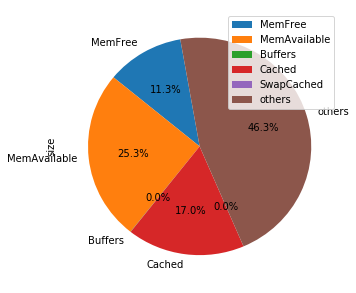

In [34]:
display(lp.log_sections['MEMORY INFO'][:23])

data = list()
sum = 0

for i in range(2,7):
    splited = lp.log_sections['MEMORY INFO'][i].split(':')
    size = int(splited[1].split('kB')[0])
    data.append([splited[0], size])
    sum += size

splited = lp.log_sections['MEMORY INFO'][1].split(':')
total = int(splited[1].split('kB')[0])
data.append(['others', total])

df = pd.DataFrame(data, columns=['id', 'size'])
df = df.set_index('id')

df.plot.pie(y='size',figsize=(5, 5), autopct='%1.1f%%', startangle=100)

plt.show()

In [35]:
lines = lp.log_sections['EVENT LOG']
am_app_dieds = grep(lines,['am_proc_died'], 1)

02-05 10:36:37.275  1000   979  1005 I am_proc_died: [0,1413,WebViewLoader-armeabi-v7a,0,-700,0,8652,1221]
02-05 10:36:37.309  1000   979  1004 I am_proc_died: [0,1427,WebViewLoader-arm64-v8a,0,-700,0,8650,1228]
02-05 10:36:43.985  1000   979  1511 I am_proc_died: [0,2817,com.samsung.android.bixby.agent,0,0,11,7417,1662]
02-05 10:36:46.552  1000   979  1510 I am_proc_died: [0,1454,com.samsung.android.themecenter,0,0,10,7353,1832]
02-05 10:38:15.879  1000   979  3795 I am_proc_died: [0,3608,com.samsung.android.honeyboard,0,200,7,6152,2393]
02-05 10:38:20.888  1000   979  2377 I am_proc_died: [0,2658,com.samsung.android.accessibility.talkback,0,999,19,4721,2983]
02-05 10:38:20.912  1000   979  1697 I am_proc_died: [0,2725,com.sec.android.app.soundalive,0,999,19,4722,2983]
02-05 10:38:21.099  1000   979  1699 I am_proc_died: [0,1904,com.samsung.android.providers.carrier,0,999,19,4712,2991]
02-05 10:38:21.112  1000   979  3739 I am_proc_died: [0,2565,com.sec.epdg,0,999,19,4701,2991]
02-05 

02-05 10:36:37.275  1000   979  1005 I am_proc_died: [0,1413,WebViewLoader-armeabi-v7a,0,-700,0,8652,1221]
02-05 10:36:37.309  1000   979  1004 I am_proc_died: [0,1427,WebViewLoader-arm64-v8a,0,-700,0,8650,1228]
02-05 10:36:43.985  1000   979  1511 I am_proc_died: [0,2817,com.samsung.android.bixby.agent,0,0,11,7417,1662]
02-05 10:36:46.552  1000   979  1510 I am_proc_died: [0,1454,com.samsung.android.themecenter,0,0,10,7353,1832]
02-05 10:38:42.266  1000   979  3811 I am_proc_died: [0,8917,com.samsung.android.aircommandmanager,51,0,11,2510,4295]


Text(0.5,1,'OOM ADJ(AM_PROC_DIED)')

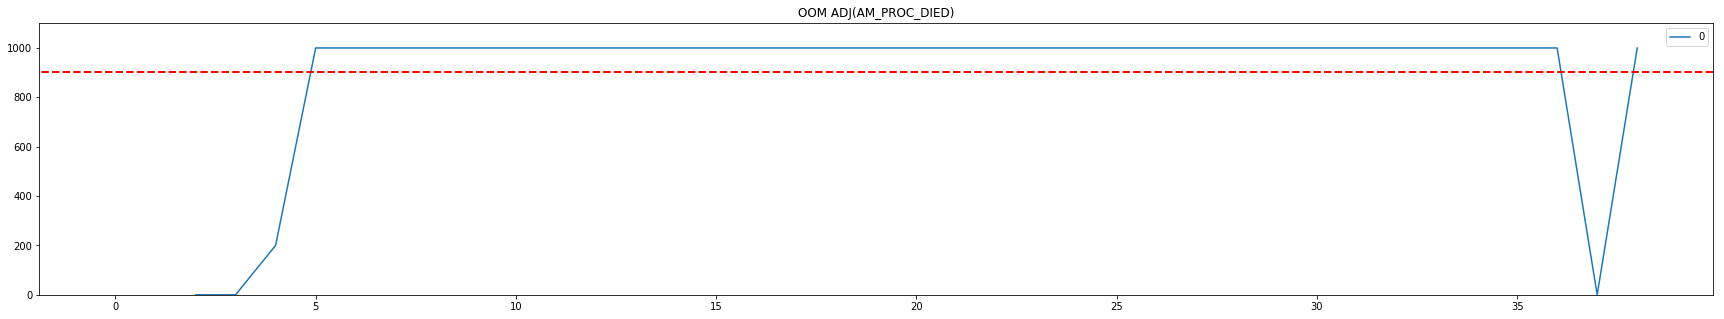

In [36]:
am_app_dieds_mem = list()

for am_app_died in am_app_dieds:
    splited = am_app_died.split(',')
    am_app_dieds_mem.append(int(splited[4]))
    if int(splited[4]) < 200 :
        print(am_app_died)
#print(am_app_dieds_mem)
df = pd.DataFrame(am_app_dieds_mem)
ax = df.plot(figsize=(30,5), ylim=(0, 1100))
ax.axhline(y=900, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
ax.set_title('OOM ADJ(AM_PROC_DIED)')

Text(0.5,1,'FREE MEMORY(AM_PROC_DIED)')

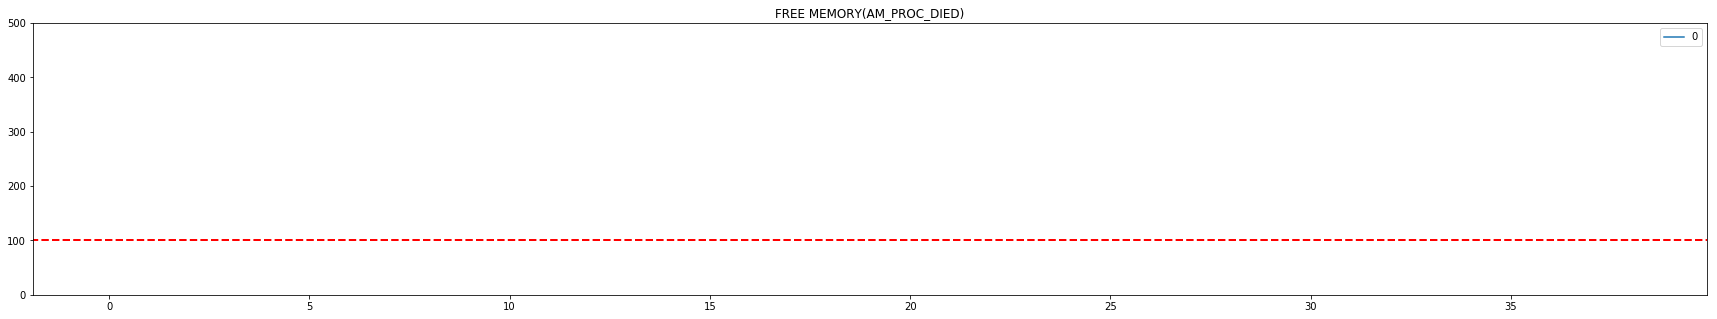

In [37]:
am_app_dieds_mem = list()

for am_app_died in am_app_dieds:
    splited = am_app_died.split(',')
    am_app_dieds_mem.append(int(splited[-2]))
#print(am_app_dieds_mem)
df = pd.DataFrame(am_app_dieds_mem)
ax = df.plot(figsize=(30,5), ylim=(0,500))
ax.axhline(y=100, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
ax.set_title('FREE MEMORY(AM_PROC_DIED)')

* If file cache size is smaller then 200, it can make some sluggish problem(in some scenario, likes take a picture with camera app).

Text(0.5,1,'FILE CACHE MEMORY(AM_PROC_DIED)')

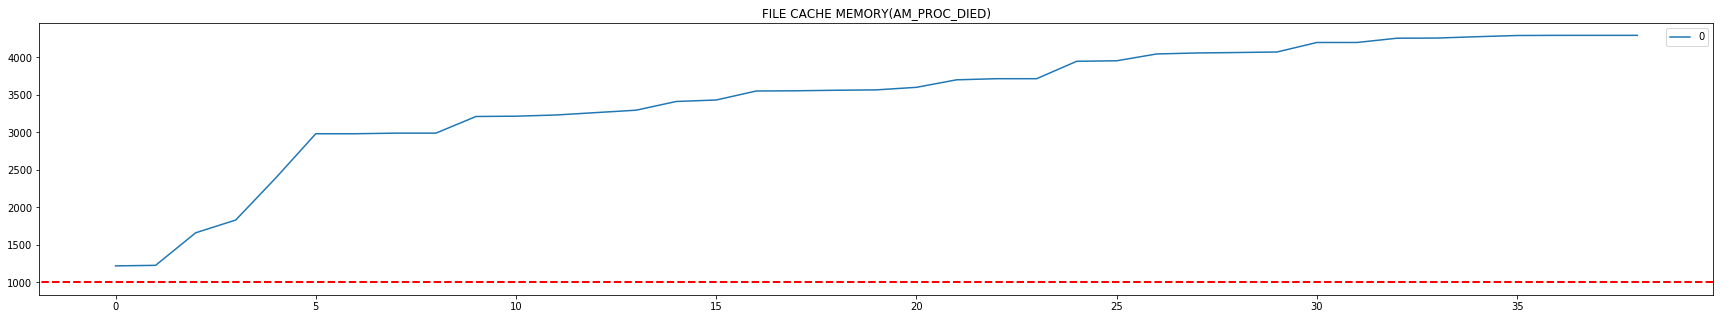

In [38]:
am_app_dieds_mem = list()

for am_app_died in am_app_dieds:
    splited = am_app_died.split(',')
    am_app_dieds_mem.append(int(splited[-1][:-1]))
#print(am_app_dieds_mem)
df = pd.DataFrame(am_app_dieds_mem)
ax = df.plot(figsize=(30,5))
ax.axhline(y=1000, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
ax.set_title('FILE CACHE MEMORY(AM_PROC_DIED)')

In [39]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['WaitForGcToComplete blocked', 'Waiting for a blocking GC Alloc'], 1)

02-05 10:36:20.286  root   537   537 I zygote64: WaitForGcToComplete blocked Explicit on None for 42.401ms
02-05 10:36:45.421 10460  2150  2176 I oadcastreceive: WaitForGcToComplete blocked ProfileSaver on AddRemoveAppImageSpace for 7.336ms
02-05 10:38:17.232 10112  1665  4795 I id.app.launche: WaitForGcToComplete blocked ClassLinker on ProfileSaver for 99.805ms
02-05 10:38:19.936 10124  3796  3909 I sdk.handwritin: WaitForGcToComplete blocked ProfileSaver on AddRemoveAppImageSpace for 264.380ms
02-05 10:38:20.235  1000  4033  4093 I io.face.servic: WaitForGcToComplete blocked ProfileSaver on AddRemoveAppImageSpace for 283.932ms
02-05 10:38:21.066  5278  4350  4442 I .android.authf: WaitForGcToComplete blocked ProfileSaver on RunEmptyCheckpoint for 82.004ms
02-05 10:38:21.299 10029  5624  5624 I d.process.medi: WaitForGcToComplete blocked ClassLinker on ClassLinker for 22.493ms
02-05 10:38:22.134 10233  4512  4582 I com.ktshow.cs: WaitForGcToComplete blocked ProfileSaver on ClassLinker

In [40]:
lines = lp.log_sections['EVENT LOG']
am_app_pss_lines = grep(lines,['am_pss', 'am_on_top_resumed_gained_called'], 1, show=False)

for am_app_pss_line in am_app_pss_lines:
    if 'am_pss' in am_app_pss_line:
        am_app_pss_line_splited = am_app_pss_line.split(',')
        if len(am_app_pss_line_splited) > 7:
            pss = am_app_pss_line_splited[-7]
            pss_MB = int(pss) / 1024 / 1024
            if (pss_MB > 50) :
                print(am_app_pss_line + "\t\t\t\t\t// PSS : " + str(pss_MB) + " MB  by " + am_app_pss_line_splited[2])
    else:
        print(am_app_pss_line)

02-05 10:36:46.696  1000   979  1020 I am_pss  : [2271,10045,com.google.android.gms.persistent,61094912,31907840,0,224026624,2,10,10]					// PSS : 58 MB  by com.google.android.gms.persistent
02-05 10:36:46.739  1000   979  1020 I am_pss  : [2809,10045,com.google.android.gms,136766464,101240832,0,301666304,2,10,13]					// PSS : 130 MB  by com.google.android.gms
02-05 10:36:47.163  1000   979  1020 I am_pss  : [1367,10012,com.android.systemui,256126976,231891968,0,441578496,2,1,16]					// PSS : 244 MB  by com.android.systemui
02-05 10:36:47.210  1000   979  1020 I am_pss  : [979,1000,system,338243584,323846144,0,515514368,2,0,22]					// PSS : 322 MB  by system
02-05 10:38:32.709  1000   979  1020 I am_pss  : [1665,10112,com.sec.android.app.launcher,282859520,239082496,0,513530880,0,2,21]					// PSS : 269 MB  by com.sec.android.app.launcher
02-05 10:38:32.729  1000   979  1020 I am_pss  : [4756,10242,com.estsoft.alyac,84054016,80715776,0,233578496,0,4,12]					// PSS : 80 MB  by com.estsof

In [41]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Couldn\'t load memtrack module', 'failed to get memory consumption'], 1)

02-05 10:40:30.467 10080 16772 16772 E memtrack: Couldn't load memtrack module


* If heap free size is 0%, it doubts a memory leak problem.

In [42]:
lines = lp.log_sections['VM TRACES JUST NOW']
heap_lines = grep(lines,['Cmd line:', 'Heap:', 'Total GC', 'Total blocking GC'], 1, show=False)

printable = list()
flag_print = False
for heap_line in heap_lines:
    if 'Cmd line:' in heap_line:
        if flag_print:
            display(printable)
            flag_print = False
        del printable[:]
    printable.append(heap_line)
    if 'Total GC count' in heap_line and re.search('[1-9][0-9][0-9][0-9][0-9]', heap_line):
        flag_print = True
    if 'Heap:' in heap_line and re.search(' [0-9]%', heap_line):
        flag_print = True

['Cmd line: system_server',
 'Heap: 8% free, 101MB/111MB; 1734657 objects',
 'Total GC count: 40',
 'Total GC time: 15.684s',
 'Total blocking GC count: 3',
 'Total blocking GC time: 9.562s']

['Cmd line: com.google.android.gms.persistent',
 'Heap: 6% free, 17MB/18MB; 331920 objects',
 'Total GC count: 12',
 'Total GC time: 1.085s',
 'Total blocking GC count: 0',
 'Total blocking GC time: 0']

['Cmd line: com.samsung.android.honeyboard',
 'Heap: 5% free, 17MB/18MB; 352316 objects',
 'Total GC count: 15',
 'Total GC time: 8.057s',
 'Total blocking GC count: 0',
 'Total blocking GC time: 0']

In [43]:
lines = lp.log_sections['LOG STATISTICS']
tmp = grep(lines,['ring buffer is'], 1)

main: ring buffer is 5 MiB (2 MiB consumed), max entry is 5120 B, max payload is 4068 B
radio: ring buffer is 512 KiB (259 KiB consumed), max entry is 5120 B, max payload is 4068 B
events: ring buffer is 256 KiB (130 KiB consumed), max entry is 5120 B, max payload is 4068 B
system: ring buffer is 2 MiB (1007 KiB consumed), max entry is 5120 B, max payload is 4068 B
crash: ring buffer is 256 KiB (0 B consumed), max entry is 5120 B, max payload is 4068 B
stats: ring buffer is 64 KiB (0 B consumed), max entry is 5120 B, max payload is 4068 B
security: ring buffer is 256 KiB (0 B consumed), max entry is 5120 B, max payload is 4068 B
kernel: ring buffer is 256 KiB (0 B consumed), max entry is 5120 B, max payload is 4068 B


* Delay of ION allocation for Camera (100 < duration < 250)

In [44]:
lines = lp.log_sections['SYSTEM LOG']
ION_allocation_lines = grep(lines,['DEBUG:duration time'], 1, show=False)
for ION_allocation_line in ION_allocation_lines:
    if re.search('[0-9][0-9][0-9] msec', ION_allocation_line) or re.search('[0-9][0-9][0-9][0-9] msec', ION_allocation_line):
        print(ION_allocation_line)

02-05 10:36:21.496  1047   583   732 I ExynosCameraInterface: DEBUG:duration time( 2620 msec):(init_func)
02-05 10:39:35.968  1047   583 14365 I ExynosCameraSec: DEBUG:duration time(  107 msec):(m_frameFactoryStartThreadFunc)
02-05 10:39:44.013  1047   583 15082 I ExynosCameraSec: DEBUG:duration time(  154 msec):(m_frameFactoryStartThreadFunc)
02-05 10:39:44.650  1047   583   583 I ExynosCameraInterface: DEBUG:duration time(  123 msec):(HAL3_camera_device_flush)


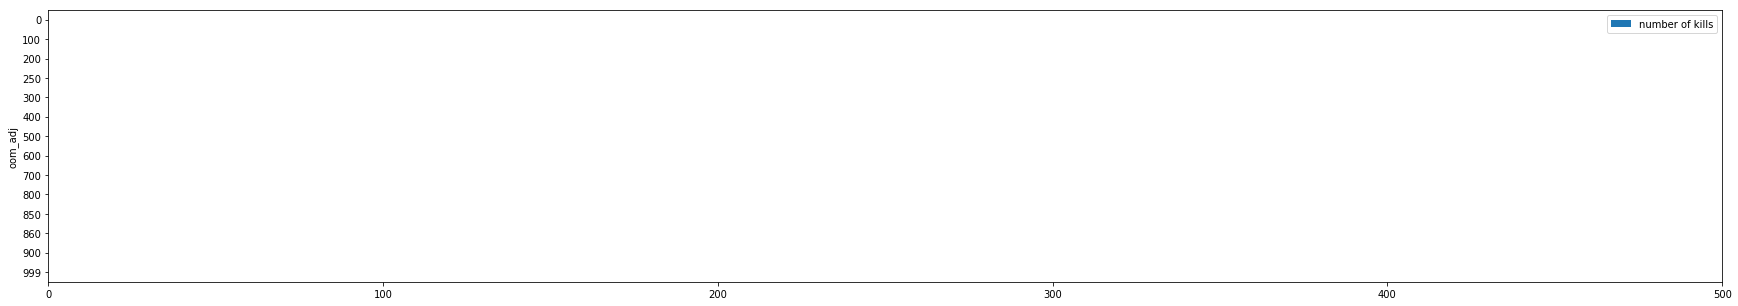

In [45]:
lines = lp.log_sections['ACTIVITY MANAGER LMK KILLS']
oom_adj_lines = grep(lines,['oom_adj'], 1, show=False)

if len(oom_adj_lines) > 0:
    lmk_kills = dict()
    lmk_kills['oom_adj'] = list()
    lmk_kills['number of kills'] = list()

    for oom_adj_line in oom_adj_lines:
        splited = oom_adj_line.split(' ')
        lmk_kills['oom_adj'].append(int(splited[-2][:-1]))
        lmk_kills['number of kills'].append(int(splited[-1]))

    df = pd.DataFrame.from_dict(lmk_kills)
    df.set_index('oom_adj', inplace=True)
    #df.sort_index(ascending=False)

    ax = df.plot(kind='barh', figsize=(30,5), xlim=(0,500))
    for index, value in enumerate(df['number of kills']):
        if value > 0 and value < 500:
            ax.text(value, index, str(value))
    plt.show()

* HeapTaskDaemon

<6>[51056.032367] [4:pool-42-thread-: 2960] heaviest_task_rss:.mobile.pguidea(28116) size:375680KB, totalram_pages:6480004KB

In [46]:
lines = lp.log_sections['SEC LOG']
lines += lp.log_sections['KERNEL LOG']

tmp = grep(lines,['heaviest_task_rss'], 1, show=True)

--- Nothing ---


* heimdall

12-23 09:05:07.849  1000   875   925 I heimdall: recv_memcg_event:1254, receiving 661 node 1 level 4 for com.skt.skaf.l001mtm091 total 1 memcg_usage 4303790080

In [47]:
lines = lp.log_sections['SYSTEM LOG']

tmp = grep(lines,['memcg_usage'], 1, show=True)

--- Nothing ---


# <span style="color:blue">[PROCSTATS]</span>

In [48]:
lines = lp.log_sections['SERVICE procstats']
cur_lines = list()
flag = False
#display(lines)
for line in lines:
    if '*' in line:
        if flag:
            display(cur_lines)
            flag = False
        del cur_lines[:]
        cur_lines = list()
        cur_lines.append(line)
    elif 'over' in line:
        #numbers = re.findall('\d+', line)
        cur_lines.append(line)
        memory = re.findall('GB', line)
        if len(memory) > 0:
            flag = True

In [49]:
lines = lp.log_sections['SERVICE procstats']
cur_lines = list()
flag = False
#display(lines)
for line in lines:
    if '*' in line:
        if flag:
            display(cur_lines)
            flag = False
        del cur_lines[:]
        cur_lines = list()
        cur_lines.append(line)
    elif 'over' in line:
        #numbers = re.findall('\d+', line)
        cur_lines.append(line)
        memory = re.findall('[7-9][0-9][0-9]MB', line)
        if len(memory) > 0:
            flag = True

['  * system / 1000 / v30:\n',
 '         TOTAL: 100% (494MB-555MB-647MB/409MB-460MB-539MB/600MB-679MB-795MB over 3)\n',
 '    Persistent: 100% (494MB-555MB-647MB/409MB-460MB-539MB/600MB-679MB-795MB over 3)\n']

['  * system / 1000 / v30:\n',
 '         TOTAL: 100% (528MB-561MB-609MB/439MB-459MB-498MB/634MB-667MB-721MB over 3)\n',
 '    Persistent: 100% (528MB-561MB-609MB/439MB-459MB-498MB/634MB-667MB-721MB over 3)\n']

['  * com.kt.otv / u0a239 / v604022:\n',
 '         TOTAL: 28% (361MB-501MB-588MB/336MB-473MB-560MB/576MB-718MB-804MB over 8)\n',
 '           Top: 26% (361MB-501MB-588MB/336MB-473MB-560MB/576MB-717MB-804MB over 6)\n',
 '       Service: 2.1% (501MB-501MB-501MB/475MB-475MB-475MB/721MB-721MB-721MB over 2)\n',
 '      (Cached): 21% (69MB-287MB-503MB/67MB-273MB-477MB/171MB-448MB-723MB over 4)\n']

['  * com.nhn.android.search / u0a272 / v10310200:\n',
 '         TOTAL: 13% (227MB-431MB-533MB/198MB-398MB-500MB/572MB-634MB-735MB over 5)\n',
 '           Top: 13% (227MB-431MB-533MB/198MB-398MB-500MB/572MB-634MB-735MB over 5)\n',
 '    (Last Act): 3.7% (386MB-386MB-386MB/352MB-352MB-352MB/587MB-587MB-587MB over 2)\n',
 '      (Cached): 56% (132MB-185MB-204MB/107MB-157MB-174MB/293MB-372MB-400MB over 4)\n']

['  * android / 1000 / v30:\n',
 '          SOff/ Mod/Persistent: 323MB-323MB-323MB/309MB-309MB-309MB/492MB-492MB-492MB over 1\n',
 '           SOn/Norm/Persistent: 547MB-556MB-566MB/504MB-506MB-509MB/824MB-807MB-824MB over 2\n',
 '        Cur time +2m27s228ms (running): 323MB-478MB-566MB/309MB-441MB-509MB/492MB-702MB-824MB over 3\n',
 '           SOn/Norm/   Service: 5.4MB-7.7MB-8.9MB/4.0MB-6.4MB-7.5MB/136MB-140MB-142MB over 3\n',
 '        Cur time +54s902ms (running): 5.4MB-7.7MB-8.9MB/4.0MB-6.4MB-7.5MB/136MB-140MB-142MB over 3\n']

['  * com.android.providers.settings / 1000 / v30:\n',
 '          SOff/ Mod/Persistent: 323MB-323MB-323MB/309MB-309MB-309MB/492MB-492MB-492MB over 1\n',
 '           SOn/Norm/Persistent: 547MB-556MB-566MB/504MB-506MB-509MB/824MB-807MB-824MB over 2\n',
 '        Cur time +2m24s333ms (running): 323MB-478MB-566MB/309MB-441MB-509MB/492MB-702MB-824MB over 3\n',
 '        <- com.samsung.android.app.ledbackcover/u0a60 (com.samsung.android.app.ledbackcover):\n',
 '        <- com.lifeoverflow.app.weather/u0a279 (com.lifeoverflow.app.weather):\n']

['  * com.android.server.telecom / 1000 / v30:\n',
 '          SOff/ Mod/Persistent: 323MB-323MB-323MB/309MB-309MB-309MB/492MB-492MB-492MB over 1\n',
 '           SOn/Norm/Persistent: 547MB-556MB-566MB/504MB-506MB-509MB/824MB-807MB-824MB over 2\n',
 '        Cur time +2m24s333ms (running): 323MB-478MB-566MB/309MB-441MB-509MB/492MB-702MB-824MB over 3\n']

['  * com.dsi.ant.server / 1000 / v30000:\n',
 '           SOn/Norm/Persistent: 547MB-547MB-547MB/504MB-504MB-504MB/789MB-789MB-789MB over 1\n',
 '        Cur time +29s97ms (running): 547MB-547MB-547MB/504MB-504MB-504MB/789MB-789MB-789MB over 1\n']

['  * com.android.networkstack.tethering.inprocess / 1000 / v30:\n',
 '          SOff/ Mod/Persistent: 323MB-323MB-323MB/309MB-309MB-309MB/492MB-492MB-492MB over 1\n',
 '           SOn/Norm/Persistent: 547MB-556MB-566MB/504MB-506MB-509MB/824MB-807MB-824MB over 2\n',
 '        Cur time +2m15s270ms (running): 323MB-478MB-566MB/309MB-441MB-509MB/492MB-702MB-824MB over 3\n']

['  * com.android.location.fused / 1000 / v30:\n',
 '          SOff/ Mod/Persistent: 323MB-323MB-323MB/309MB-309MB-309MB/492MB-492MB-492MB over 1\n',
 '           SOn/Norm/Persistent: 547MB-556MB-566MB/504MB-506MB-509MB/824MB-807MB-824MB over 2\n',
 '        Cur time +2m15s382ms (running): 323MB-478MB-566MB/309MB-441MB-509MB/492MB-702MB-824MB over 3\n']

['  * system / 1000 (6 entries):\n',
 '          SOff/ Mod/Persistent: 323MB-323MB-323MB/309MB-309MB-309MB/492MB-492MB-492MB over 1\n',
 '           SOn/Norm/Persistent: 547MB-556MB-566MB/504MB-506MB-509MB/824MB-807MB-824MB over 2\n',
 '        Cur time +2m27s228ms (running): 323MB-478MB-566MB/309MB-441MB-509MB/492MB-702MB-824MB over 3\n']

['  * system / 1000 / v30:\n',
 '         TOTAL: 97% (323MB-478MB-566MB/309MB-441MB-509MB/492MB-702MB-824MB over 3)\n',
 '    Persistent: 97% (323MB-478MB-566MB/309MB-441MB-509MB/492MB-702MB-824MB over 3)\n']

['  * com.shinhan.sbanking / u0a3676 / v422:\n',
 '          SOff/Norm/(Cch Emty): 26MB-36MB-42MB/17MB-29MB-38MB/120MB-133MB-152MB over 9\n',
 '           SOn/Norm/       Top: 159MB-414MB-614MB/102MB-385MB-591MB/634MB-624MB-813MB over 5\n',
 '                     (Cch Act): 534MB-554MB-573MB/511MB-531MB-550MB/774MB-760MB-774MB over 2\n',
 '                    (Cch Emty): 31MB-41MB-46MB/17MB-37MB-44MB/158MB-147MB-159MB over 5\n',
 '                Mod/       Top: 517MB-517MB-517MB/498MB-498MB-498MB/730MB-730MB-730MB over 1\n',
 '                    (Last Act): 361MB-361MB-361MB/341MB-341MB-341MB/573MB-573MB-573MB over 1\n']

['  * android / 1000 / v30:\n',
 '          SOff/Norm/Persistent: 486MB-579MB-723MB/401MB-486MB-622MB/634MB-690MB-863MB over 16\n',
 '                Mod/Persistent: 323MB-323MB-323MB/309MB-309MB-309MB/492MB-492MB-492MB over 1\n',
 '           SOn/Norm/Persistent: 494MB-556MB-623MB/409MB-472MB-535MB/824MB-679MB-824MB over 18\n',
 '                Mod/Persistent: 589MB-589MB-589MB/500MB-500MB-500MB/697MB-697MB-697MB over 1\n',
 '        Cur time +2m27s694ms: 323MB-478MB-566MB/309MB-441MB-509MB/492MB-702MB-824MB over 3\n',
 '           SOn/Norm/(Cch Emty): 66MB-66MB-66MB/62MB-62MB-62MB/215MB-214MB-215MB over 3\n',
 '           SOn/Norm/(Cch Emty): 13MB-13MB-13MB/10MB-10MB-11MB/134MB-135MB-137MB over 4\n',
 '          SOff/Norm/   Service: 5.5MB-5.9MB-6.3MB/884KB-4.5MB-5.0MB/95MB-103MB-110MB over 36\n',
 '           SOn/Norm/   Service: 5.4MB-6.0MB-8.9MB/524KB-4.5MB-7.5MB/136MB-107MB-142MB over 44\n',
 '                Mod/   Service: 6.0MB-6.1MB-6.3MB/4.6MB-4.7MB-4.9MB/110MB-107MB-110MB 

['  * com.android.providers.settings / 1000 / v30:\n',
 '          SOff/Norm/Persistent: 486MB-579MB-723MB/401MB-486MB-622MB/634MB-690MB-863MB over 16\n',
 '                Mod/Persistent: 323MB-323MB-323MB/309MB-309MB-309MB/492MB-492MB-492MB over 1\n',
 '           SOn/Norm/Persistent: 494MB-556MB-623MB/409MB-472MB-535MB/824MB-679MB-824MB over 18\n',
 '                Mod/Persistent: 589MB-589MB-589MB/500MB-500MB-500MB/697MB-697MB-697MB over 1\n',
 '        Cur time +2m24s799ms: 323MB-478MB-566MB/309MB-441MB-509MB/492MB-702MB-824MB over 3\n',
 '        <- com.samsung.android.app.ledbackcover/u0a60 (com.samsung.android.app.ledbackcover):\n',
 '        <- com.lifeoverflow.app.weather/u0a279 (com.lifeoverflow.app.weather):\n',
 '        <- com.sec.android.easyMover.Agent/u0a175 (com.sec.android.easyMover.Agent):\n',
 '        <- com.sec.android.easyMover.Agent/u150a175 (com.sec.android.easyMover.Agent):\n']

['  * com.android.server.telecom / 1000 / v30:\n',
 '          SOff/Norm/Persistent: 486MB-579MB-723MB/401MB-486MB-622MB/634MB-690MB-863MB over 16\n',
 '                Mod/Persistent: 323MB-323MB-323MB/309MB-309MB-309MB/492MB-492MB-492MB over 1\n',
 '           SOn/Norm/Persistent: 494MB-556MB-623MB/409MB-472MB-535MB/824MB-679MB-824MB over 18\n',
 '                Mod/Persistent: 589MB-589MB-589MB/500MB-500MB-500MB/697MB-697MB-697MB over 1\n',
 '        Cur time +2m24s799ms: 323MB-478MB-566MB/309MB-441MB-509MB/492MB-702MB-824MB over 3\n']

['  * com.dsi.ant.server / 1000 / v30000:\n',
 '          SOff/Norm/Persistent: 486MB-579MB-723MB/401MB-486MB-622MB/634MB-690MB-863MB over 16\n',
 '           SOn/Norm/Persistent: 494MB-556MB-623MB/409MB-470MB-535MB/789MB-670MB-789MB over 17\n',
 '                Mod/Persistent: 589MB-589MB-589MB/500MB-500MB-500MB/697MB-697MB-697MB over 1\n',
 '        Cur time +29s563ms: 547MB-547MB-547MB/504MB-504MB-504MB/789MB-789MB-789MB over 1\n']

['  * com.kt.otv / u0a239 / v604022:\n',
 '          SOff/Norm/(Cch Emty): 30MB-30MB-30MB/20MB-20MB-20MB/146MB-146MB-146MB over 1\n',
 '           SOn/Norm/    Imp Fg: 88MB-88MB-88MB/77MB-77MB-77MB/205MB-205MB-205MB over 3\n',
 '                       Service: 50MB-62MB-86MB/40MB-52MB-75MB/203MB-178MB-203MB over 8\n',
 '                    (Cch CAct): 86MB-86MB-86MB/76MB-76MB-76MB/203MB-203MB-203MB over 2\n',
 '                    (Cch Emty): 30MB-46MB-53MB/20MB-36MB-43MB/146MB-162MB-169MB over 5\n',
 '          SOff/Norm/(Last Act): 239MB-239MB-239MB/211MB-211MB-211MB/456MB-456MB-456MB over 1\n',
 '                    (Cch Emty): 63MB-66MB-69MB/61MB-63MB-67MB/171MB-170MB-173MB over 6\n',
 '           SOn/Norm/       Top: 361MB-470MB-588MB/336MB-444MB-560MB/576MB-676MB-804MB over 9\n',
 '                       Service: 239MB-317MB-501MB/211MB-296MB-475MB/721MB-510MB-721MB over 8\n',
 '                    (Last Act): 239MB-249MB-259MB/211MB-227MB-244MB/456MB-441MB-456MB over 2\n',
 '   

['  * com.android.networkstack.tethering.inprocess / 1000 / v30:\n',
 '          SOff/Norm/Persistent: 486MB-579MB-723MB/401MB-486MB-622MB/634MB-690MB-863MB over 16\n',
 '                Mod/Persistent: 323MB-323MB-323MB/309MB-309MB-309MB/492MB-492MB-492MB over 1\n',
 '           SOn/Norm/Persistent: 494MB-556MB-623MB/409MB-472MB-535MB/824MB-679MB-824MB over 18\n',
 '                Mod/Persistent: 589MB-589MB-589MB/500MB-500MB-500MB/697MB-697MB-697MB over 1\n',
 '        Cur time +2m15s736ms: 323MB-478MB-566MB/309MB-441MB-509MB/492MB-702MB-824MB over 3\n']

['  * com.nhn.android.search / u0a272 / v10310200:\n',
 '          SOff/Norm/       Top: 171MB-218MB-327MB/152MB-198MB-305MB/438MB-329MB-439MB over 8\n',
 '                    (Cch CAct): 164MB-164MB-165MB/145MB-145MB-145MB/273MB-273MB-273MB over 2\n',
 '                    (Cch Emty): 108MB-108MB-109MB/95MB-95MB-96MB/210MB-209MB-210MB over 4\n',
 '           SOn/Norm/    Imp Fg: 177MB-216MB-304MB/158MB-195MB-283MB/416MB-327MB-416MB over 9\n',
 '                    (Last Act): 188MB-231MB-298MB/168MB-211MB-277MB/409MB-342MB-409MB over 6\n',
 '                    (Cch CAct): 139MB-185MB-327MB/121MB-165MB-305MB/439MB-294MB-439MB over 16\n',
 '                    (Cch Emty): 108MB-109MB-113MB/95MB-96MB-100MB/243MB-213MB-243MB over 12\n',
 '        Cur time +25s826ms: 110MB-110MB-110MB/98MB-98MB-98MB/243MB-243MB-243MB over 1\n',
 '          SOff/Norm/(Cch CAct): 183MB-183MB-183MB/170MB-170MB-170MB/284MB-284MB-284MB over 1\n',
 '           SOn/Norm/    Imp Fg: 243MB-243MB-243MB/227MB-227MB-

['  * com.android.location.fused / 1000 / v30:\n',
 '          SOff/Norm/Persistent: 486MB-579MB-723MB/401MB-486MB-622MB/634MB-690MB-863MB over 16\n',
 '                Mod/Persistent: 323MB-323MB-323MB/309MB-309MB-309MB/492MB-492MB-492MB over 1\n',
 '           SOn/Norm/Persistent: 494MB-556MB-623MB/409MB-472MB-535MB/824MB-679MB-824MB over 18\n',
 '                Mod/Persistent: 589MB-589MB-589MB/500MB-500MB-500MB/697MB-697MB-697MB over 1\n',
 '        Cur time +2m15s848ms: 323MB-478MB-566MB/309MB-441MB-509MB/492MB-702MB-824MB over 3\n']

['  * com.fineappstudio.android.petfriends / u0a282 / v190:\n',
 '           SOn/Norm/       Top: 599MB-599MB-599MB/584MB-584MB-584MB/790MB-790MB-790MB over 1\n',
 '                    (Last Act): 186MB-187MB-187MB/174MB-174MB-175MB/374MB-373MB-374MB over 2\n',
 '                    (Cch Emty): 27MB-27MB-27MB/26MB-26MB-26MB/122MB-122MB-122MB over 3\n']

['  * system / 1000 (7 entries):\n',
 '          SOff/Norm/Persistent: 486MB-579MB-723MB/401MB-486MB-622MB/634MB-690MB-863MB over 16\n',
 '                Mod/Persistent: 323MB-323MB-323MB/309MB-309MB-309MB/492MB-492MB-492MB over 1\n',
 '           SOn/Norm/Persistent: 494MB-556MB-623MB/409MB-472MB-535MB/824MB-679MB-824MB over 18\n',
 '                Mod/Persistent: 589MB-589MB-589MB/500MB-500MB-500MB/697MB-697MB-697MB over 1\n',
 '        Cur time +2m27s694ms: 323MB-478MB-566MB/309MB-441MB-509MB/492MB-702MB-824MB over 3\n']

['  * system / 1000 / v30:\n',
 '         TOTAL: 100% (323MB-561MB-723MB/309MB-475MB-622MB/492MB-679MB-863MB over 36)\n',
 '    Persistent: 100% (323MB-561MB-723MB/309MB-475MB-622MB/492MB-679MB-863MB over 36)\n']

['  * com.nhn.android.search / u0a272 / v10310200:\n',
 '         TOTAL: 4.6% (227MB-368MB-571MB/198MB-336MB-533MB/572MB-568MB-778MB over 22)\n',
 '           Top: 4.5% (227MB-368MB-571MB/198MB-336MB-533MB/572MB-568MB-778MB over 22)\n',
 '    (Last Act): 2.3% (233MB-291MB-386MB/196MB-259MB-352MB/587MB-487MB-587MB over 10)\n',
 '      (Cached): 50% (63MB-160MB-318MB/29MB-134MB-288MB/185MB-326MB-524MB over 46)\n']

['  * com.kt.otv / u0a239 / v604022:\n',
 '         TOTAL: 2.4% (239MB-398MB-588MB/211MB-375MB-560MB/576MB-598MB-804MB over 17)\n',
 '           Top: 1.8% (361MB-470MB-588MB/336MB-444MB-560MB/576MB-676MB-804MB over 9)\n',
 '       Service: 0.50% (239MB-317MB-501MB/211MB-296MB-475MB/721MB-510MB-721MB over 8)\n',
 '    (Last Act): 0.90% (239MB-246MB-259MB/211MB-222MB-244MB/456MB-446MB-456MB over 3)\n',
 '      (Cached): 7.0% (60MB-133MB-503MB/50MB-126MB-477MB/171MB-260MB-723MB over 19)\n']

['  * com.shinhan.sbanking / u0a3676 / v422:\n',
 '         TOTAL: 1.3% (159MB-431MB-614MB/102MB-404MB-591MB/634MB-642MB-813MB over 6)\n',
 '           Top: 1.3% (159MB-431MB-614MB/102MB-404MB-591MB/634MB-642MB-813MB over 6)\n',
 '    (Last Act): 0.41% (361MB-361MB-361MB/341MB-341MB-341MB/573MB-573MB-573MB over 1)\n',
 '      (Cached): 32% (26MB-102MB-573MB/17MB-94MB-550MB/120MB-216MB-774MB over 16)\n']

['  * com.fineappstudio.android.petfriends / u0a282 / v190:\n',
 '         TOTAL: 0.15% (599MB-599MB-599MB/584MB-584MB-584MB/790MB-790MB-790MB over 1)\n',
 '           Top: 0.15% (599MB-599MB-599MB/584MB-584MB-584MB/790MB-790MB-790MB over 1)\n',
 '    (Last Act): 0.44% (186MB-187MB-187MB/174MB-174MB-175MB/374MB-373MB-374MB over 2)\n',
 '      (Cached): 0.51% (27MB-27MB-27MB/26MB-26MB-26MB/122MB-122MB-122MB over 3)\n']

['  * android / 1000 / v30:\n',
 '          SOff/Norm/Persistent: 528MB-573MB-647MB/439MB-473MB-539MB/634MB-692MB-795MB over 3\n',
 '                Mod/Persistent: 323MB-323MB-323MB/309MB-309MB-309MB/492MB-492MB-492MB over 1\n',
 '           SOn/Norm/Persistent: 494MB-548MB-609MB/409MB-471MB-509MB/824MB-715MB-824MB over 5\n',
 '        Cur time +2m28s572ms: 323MB-478MB-566MB/309MB-441MB-509MB/492MB-702MB-824MB over 3\n',
 '           SOn/Norm/(Cch Emty): 13MB-13MB-13MB/10MB-10MB-10MB/134MB-134MB-134MB over 2\n',
 '          SOff/Norm/   Service: 5.7MB-5.9MB-6.0MB/884KB-3.7MB-4.7MB/95MB-100MB-104MB over 4\n',
 '           SOn/Norm/   Service: 5.4MB-6.5MB-8.9MB/524KB-4.2MB-7.5MB/136MB-113MB-142MB over 10\n',
 '        Cur time +56s246ms: 5.4MB-7.7MB-8.9MB/4.0MB-6.4MB-7.5MB/136MB-140MB-142MB over 3\n']

['  * com.android.providers.settings / 1000 / v30:\n',
 '          SOff/Norm/Persistent: 528MB-573MB-647MB/439MB-473MB-539MB/634MB-692MB-795MB over 3\n',
 '                Mod/Persistent: 323MB-323MB-323MB/309MB-309MB-309MB/492MB-492MB-492MB over 1\n',
 '           SOn/Norm/Persistent: 494MB-548MB-609MB/409MB-471MB-509MB/824MB-715MB-824MB over 5\n',
 '        Cur time +2m25s677ms: 323MB-478MB-566MB/309MB-441MB-509MB/492MB-702MB-824MB over 3\n',
 '        <- com.samsung.android.app.ledbackcover/u0a60 (com.samsung.android.app.ledbackcover):\n',
 '        <- com.lifeoverflow.app.weather/u0a279 (com.lifeoverflow.app.weather):\n',
 '        <- com.sec.android.easyMover.Agent/u0a175 (com.sec.android.easyMover.Agent):\n',
 '        <- com.sec.android.easyMover.Agent/u150a175 (com.sec.android.easyMover.Agent):\n']

['  * com.android.server.telecom / 1000 / v30:\n',
 '          SOff/Norm/Persistent: 528MB-573MB-647MB/439MB-473MB-539MB/634MB-692MB-795MB over 3\n',
 '                Mod/Persistent: 323MB-323MB-323MB/309MB-309MB-309MB/492MB-492MB-492MB over 1\n',
 '           SOn/Norm/Persistent: 494MB-548MB-609MB/409MB-471MB-509MB/824MB-715MB-824MB over 5\n',
 '        Cur time +2m25s677ms: 323MB-478MB-566MB/309MB-441MB-509MB/492MB-702MB-824MB over 3\n']

['  * com.dsi.ant.server / 1000 / v30000:\n',
 '          SOff/Norm/Persistent: 528MB-573MB-647MB/439MB-473MB-539MB/634MB-692MB-795MB over 3\n',
 '           SOn/Norm/Persistent: 494MB-544MB-609MB/409MB-461MB-504MB/789MB-688MB-789MB over 4\n',
 '        Cur time +30s441ms: 547MB-547MB-547MB/504MB-504MB-504MB/789MB-789MB-789MB over 1\n']

['  * com.kt.otv / u0a239 / v604022:\n',
 '           SOn/Norm/    Imp Fg: 88MB-88MB-88MB/77MB-77MB-77MB/205MB-205MB-205MB over 3\n',
 '                       Service: 86MB-86MB-86MB/75MB-75MB-75MB/203MB-203MB-203MB over 2\n',
 '                    (Cch CAct): 86MB-86MB-86MB/76MB-76MB-76MB/203MB-203MB-203MB over 2\n',
 '          SOff/Norm/(Cch Emty): 69MB-69MB-69MB/67MB-67MB-67MB/171MB-171MB-171MB over 1\n',
 '           SOn/Norm/       Top: 361MB-501MB-588MB/336MB-473MB-560MB/576MB-717MB-804MB over 6\n',
 '                       Service: 501MB-501MB-501MB/475MB-475MB-475MB/721MB-721MB-721MB over 2\n',
 '                     (Cch Act): 503MB-503MB-503MB/477MB-477MB-477MB/723MB-723MB-723MB over 2\n',
 '                    (Cch Emty): 60MB-66MB-73MB/58MB-65MB-72MB/195MB-185MB-195MB over 2\n',
 '        Cur time +29s321ms: 60MB-60MB-60MB/58MB-58MB-58MB/195MB-195MB-195MB over 1\n']

['  * com.android.networkstack.tethering.inprocess / 1000 / v30:\n',
 '          SOff/Norm/Persistent: 528MB-573MB-647MB/439MB-473MB-539MB/634MB-692MB-795MB over 3\n',
 '                Mod/Persistent: 323MB-323MB-323MB/309MB-309MB-309MB/492MB-492MB-492MB over 1\n',
 '           SOn/Norm/Persistent: 494MB-548MB-609MB/409MB-471MB-509MB/824MB-715MB-824MB over 5\n',
 '        Cur time +2m16s614ms: 323MB-478MB-566MB/309MB-441MB-509MB/492MB-702MB-824MB over 3\n']

['  * com.nhn.android.search / u0a272 / v10310200:\n',
 '          SOff/Norm/       Top: 326MB-326MB-327MB/304MB-304MB-305MB/438MB-438MB-439MB over 2\n',
 '                    (Cch Emty): 109MB-109MB-109MB/95MB-95MB-95MB/210MB-210MB-210MB over 1\n',
 '           SOn/Norm/    Imp Fg: 296MB-300MB-304MB/274MB-279MB-283MB/416MB-412MB-416MB over 2\n',
 '                    (Last Act): 298MB-298MB-298MB/277MB-277MB-277MB/409MB-409MB-409MB over 2\n',
 '                    (Cch CAct): 139MB-212MB-327MB/121MB-192MB-305MB/439MB-320MB-439MB over 5\n',
 '                    (Cch Emty): 109MB-109MB-110MB/95MB-96MB-98MB/243MB-216MB-243MB over 5\n',
 '        Cur time +25s826ms: 110MB-110MB-110MB/98MB-98MB-98MB/243MB-243MB-243MB over 1\n',
 '          SOff/Norm/       Top: 370MB-370MB-370MB/335MB-335MB-335MB/572MB-572MB-572MB over 1\n',
 '                    (Cch Emty): 132MB-132MB-132MB/107MB-107MB-107MB/293MB-293MB-293MB over 1\n',
 '           SOn/Norm/       Top: 227MB-447MB-533MB/198MB-414MB-500

['  * com.android.location.fused / 1000 / v30:\n',
 '          SOff/Norm/Persistent: 528MB-573MB-647MB/439MB-473MB-539MB/634MB-692MB-795MB over 3\n',
 '                Mod/Persistent: 323MB-323MB-323MB/309MB-309MB-309MB/492MB-492MB-492MB over 1\n',
 '           SOn/Norm/Persistent: 494MB-548MB-609MB/409MB-471MB-509MB/824MB-715MB-824MB over 5\n',
 '        Cur time +2m16s726ms: 323MB-478MB-566MB/309MB-441MB-509MB/492MB-702MB-824MB over 3\n']

['  * system / 1000 (6 entries):\n',
 '          SOff/Norm/Persistent: 528MB-573MB-647MB/439MB-473MB-539MB/634MB-692MB-795MB over 3\n',
 '                Mod/Persistent: 323MB-323MB-323MB/309MB-309MB-309MB/492MB-492MB-492MB over 1\n',
 '           SOn/Norm/Persistent: 494MB-548MB-609MB/409MB-471MB-509MB/824MB-715MB-824MB over 5\n',
 '        Cur time +2m28s572ms: 323MB-478MB-566MB/309MB-441MB-509MB/492MB-702MB-824MB over 3\n']

['  * system / 1000 / v30:\n',
 '         TOTAL: 100% (323MB-531MB-647MB/309MB-453MB-539MB/492MB-683MB-824MB over 9)\n',
 '    Persistent: 100% (323MB-531MB-647MB/309MB-453MB-539MB/492MB-683MB-824MB over 9)\n']

['  * com.kt.otv / u0a239 / v604022:\n',
 '         TOTAL: 9.9% (361MB-501MB-588MB/336MB-473MB-560MB/576MB-718MB-804MB over 8)\n',
 '           Top: 9.1% (361MB-501MB-588MB/336MB-473MB-560MB/576MB-717MB-804MB over 6)\n',
 '       Service: 0.74% (501MB-501MB-501MB/475MB-475MB-475MB/721MB-721MB-721MB over 2)\n',
 '      (Cached): 7.5% (60MB-241MB-503MB/58MB-230MB-477MB/171MB-397MB-723MB over 5)\n']

['  * com.nhn.android.search / u0a272 / v10310200:\n',
 '         TOTAL: 4.6% (227MB-431MB-533MB/198MB-398MB-500MB/572MB-634MB-735MB over 5)\n',
 '           Top: 4.5% (227MB-431MB-533MB/198MB-398MB-500MB/572MB-634MB-735MB over 5)\n',
 '    (Last Act): 1.3% (386MB-386MB-386MB/352MB-352MB-352MB/587MB-587MB-587MB over 2)\n',
 '      (Cached): 32% (130MB-158MB-204MB/107MB-131MB-174MB/293MB-330MB-400MB over 9)\n']

In [50]:
lines = lp.log_sections['SERVICE procstats']
cur_lines = list()
flag = False
#display(lines)
for line in lines:
    if '*' in line:
        if flag:
            display(cur_lines)
            flag = False
        del cur_lines[:]
        cur_lines = list()
        cur_lines.append(line)
    elif 'over' in line:
        #numbers = re.findall('\d+', line)
        cur_lines.append(line)
        memory = re.findall('[0-9].[0-9][0-9]GB', line)
        if len(memory) > 0:
            flag = True

# <span style="color:blue">AP Reset</span> 

* The behaviour of user, likes a term of reboot should be checked.
* MP : Force Reset
* KP : Kernel Panic
* PF_SR (PLATFORM_SILENT_RESET) : Force sending signal to reboot the device. In this case, the dropbox should include system_server_crash log, but this is not effect to the performance.  
* silent.sec : Automation Restart(Normal Operation)
* PF_EX (PLATFORM_EXCEPTION)

In [51]:
lines = lp.log_sections['AP RESET INFO']
tmp = grep(lines,['AP RESET INFO'])

------ AP RESET INFO EXTEND (/data/system/users/service/data/eRR.p) ------
2020-10-29 23:33:11+0900 |   LPM    |
2020-10-29 23:33:11+0900 |    ON    | RP    | N971NKSU1CTG3 / OFFSRC: - / ONSRC: ACOKB / RSTSTAT: SWRESET
2020-11-01 00:50:40+0900 | SHUTDOWN |       | REASON: no power
2020-11-06 17:09:43+0900 | SHUTDOWN |       | REASON: no power
2020-11-06 17:41:07+0900 |          | NP    | OFFSRC:: PWRHOLD / ONSRC:: ACOKB / RSTSTAT:: PINRESET RSVD30 / RCNT: - / PC: - LR: -
2020-11-06 17:41:07+0900 |   LPM    |
2020-11-06 17:41:07+0900 |    ON    | RP    | N971NKSU1CTG3 / OFFSRC: - / ONSRC: ACOKB / RSTSTAT: SWRESET
2020-11-11 11:06:16+0900 |  REBOOT  |       | REASON: userrequested
2020-11-11 11:10:33+0900 |    ON    | RP    | N971NKSU1CTG3 / OFFSRC: - / ONSRC: ACOKB / RSTSTAT: SWRESET
2020-11-13 20:55:55+0900 | SHUTDOWN |       | REASON: no power
2020-11-13 21:28:15+0900 |          | NP    | OFFSRC:: PWRHOLD / ONSRC:: ACOKB / RSTSTAT:: PINRESET RSVD30 / RCNT: - / PC: - LR: -
2020-11-13 2

# <span style="color:blue">CRASH</span> 

* In the case of fatal exception, data_app_crash should be confirmed togather.
* In the case of data_app_anr, app launch should be confirmed togather. 
* Crashlytics Exception could not effect to the performance.
* NPE by silent reset : Force sending signal to reboot the device. In this case, the dropbox should include system_server_crash log, but this is not effect to the performance.

In [52]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['FATAL EXCEPTION', 'Fatal signal'], 4)

--- Nothing ---


In [53]:
lines = lp.log_sections['SERVICE dropbox']
tmp = grep(lines,['system_app_anr', 'system_app_crash', 'data_app_crash', 'data_app_anr', 'system_app_native_crash', 'data_app_native_crash'], 2)

--- Nothing ---


In [54]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Sending signal'], 1)

02-05 10:36:43.926  5018  2817  2817 I Process : Sending signal. PID: 2817 SIG: 9
02-05 10:36:46.472  1000  1454  1454 I Process : Sending signal. PID: 1454 SIG: 9
02-05 10:38:15.589 10504  3608  3608 I Process : Sending signal. PID: 3608 SIG: 9
02-05 10:38:41.518  1000  8917  8917 I Process : Sending signal. PID: 8917 SIG: 9
02-05 10:39:02.670  1000  9009  9009 I Process : Sending signal. PID: 9009 SIG: 9
02-05 10:39:40.206 10039 14511 14511 I Process : Sending signal. PID: 14511 SIG: 9
02-05 10:39:47.628 10039 14480 14480 I Process : Sending signal. PID: 14480 SIG: 9
02-05 10:39:58.601 10039 16247 16247 I Process : Sending signal. PID: 16247 SIG: 9
02-05 10:40:01.640 10039 16506 16506 I Process : Sending signal. PID: 16506 SIG: 9


# <span style="color:blue">[FILESYSTEM]</span> 


* Check whether sdcard is inserted or not.
* Check the available space of media.(It should be remained over 10% at least)

In [55]:
lines = lp.log_sections['FILESYSTEMS & FREE SPACE']
filesystem_lines = grep(lines,['FILESYSTEMS & FREE SPACE'])

------ FILESYSTEMS & FREE SPACE (df) ------
Filesystem       1K-blocks     Used Available Use% Mounted on
/dev/root          6130592  5918644    211948  97% /
tmpfs              5551720     1684   5550036   1% /dev
tmpfs              5551720        0   5551720   0% /mnt
/dev/block/dm-1     198300    44988    153312  23% /product
/dev/block/dm-2    1259748  1073964    185784  86% /vendor
tmpfs              5551720        0   5551720   0% /apex
tmpfs              5557000        0   5557000   0% /mnt/sde
/dev/block/sda30     46288       24     46264   1% /omr
/dev/block/sda29    596544    21520    575024   4% /cache
/dev/block/sda34 240949228 66045984 174772172  28% /data
/dev/block/sda22     12008      264     11744   3% /keydata
/dev/block/sda21     12008      288     11720   3% /keyrefuge
/dev/block/sda7      16040     6096      9944  39% /efs
/dev/block/sda33     46280       20     46260   1% /spu
/dev/fuse        240928748 66177056 174751692  28% /storage/emulated
------ 0.028s was t

* Answer.

Some applications ( TikTok , Google Photos, Amazon Shopping ) were installed in sdcard in the user's device.<br>
When user entered those apps, It could be delayed.<br>
Please move those apps to the internal sdcard.<br>

/dev/block/dm-7                  9600    83   9517    1% /mnt/asec/com.zhiliaoapp.musically-w19U2VUWNRRfS9yi<br>
/dev/block/dm-8                  4448    23   4425    1% /mnt/asec/com.google.android.apps.photos-u7BcCB7ySRx2Bd4O<br>
/dev/block/dm-10                 5232    35   5197    1% /mnt/asec/com.amazon.mShop.android.shopping-Hys1Miat8tY5nhTH<br>

If the problem will happen again, after treating those apps.<br>
A dumpstate collected by Samsung Members application has a limited buffer size.<br>
So, it may not include the issue that you mentioned.<br>
Please report the issue right after it happens and elaborate on it.<br>
For better analysis, we need the name of application that is related to the issue and the time when it happens.

In [56]:
sdcard_lines = grep(filesystem_lines,['/mnt/asec'])

--- Nothing ---


* SD card insert/remove

[119612.122688] [    kworker/3:2, 14008] mmc0: new ultra high speed SDR104 SDXC card at address 59b4<br>
[119612.132593] [    kworker/3:2, 14008] mmcblk0: mmc0:59b4 USDU1 59.8 GiB

In [57]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['card at address'], 1)

--- Nothing ---


In [58]:
lines = lp.log_sections['STORAGE BUFFER']
tmp = grep(lines,['insertion detected'], 1)

--- Nothing ---


* SD card error

<3>[855725.987054]  [6:   kworker/6:1H:  337] mmc0: Card stuck in wrong state! mmcblk0 card_busy_detect status: 0xf00<br>
<3>[855729.375238]  [6:   kworker/6:1H:  337] Buffer I/O error on dev mmcblk0p1, logical block 3848, lost async page write<br>
<3>[50825.096294]  [0:   kworker/0:2H:11790] mmcblk0: recovery failed!

In [59]:
lines = lp.log_sections['KERNEL LOG']
lines += lp.log_sections['LAST KMSG']
tmp = grep(lines,['card_busy_detect', 'Buffer I/O error', 'Card stuck in wrong state', 'recovery failed', 'mmc_rescan'], 1)

--- Nothing ---


* history of MMC blk0 error

If the count is under 100, it could be happenning during lcd on/off.

In [60]:
lines = lp.log_sections['MMC blk0 error']
display(lines)

[]

In [61]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Filesystem check failed', 'failed filesystem check'], 1)

--- Nothing ---


In [62]:
lines = lp.log_sections['STORAGED IO INFO']
#display(lines)
read_write = list()
for line in lines:
    splited_line = line.replace('\n', '').split(' ')
    if len(splited_line) > 0 and '.' in splited_line[0]:
        read_write.append(splited_line)
        #print(splited_line)
#tmp = grep(lines,['Filesystem check failed', 'failed filesystem check'], 1)
print(lines[1].replace('\n', '').split(' '))
io_df = pd.DataFrame(read_write, columns=lines[1].replace('\n', '').split(' '))
io_df = io_df.set_index('name/uid')
io_df = io_df.astype(int)

['name/uid', 'fg_rchar', 'fg_wchar', 'fg_rbytes', 'fg_wbytes', 'bg_rchar', 'bg_wchar', 'bg_rbytes', 'bg_wbytes', 'fg_fsync', 'bg_fsync']


In [63]:
io_df.sort_values(by=['fg_rchar'], ascending=False).head()

fg_rchar  fg_wchar   fg_rbytes  fg_wbytes  \
name/uid                                                                
shared:android.uid.system  572213567  70692961  1161277440   82792448   
com.kt.ollehusimmanager    151824676    839523     5283840    1331200   
com.samsung.android.spay   113262087   6111457    86134784    6782976   
shared:android.uid.phone    81397012  18954250   133005312    1302528   
com.ktshow.cs               71084440   1666039    43143168    2342912   

                             bg_rchar  bg_wchar  bg_rbytes  bg_wbytes  \
name/uid                                                                
shared:android.uid.system           0         0          0          0   
com.kt.ollehusimmanager     166323817     30266          0          0   
com.samsung.android.spay   2754475586   1063419  608038912    1220608   
shared:android.uid.phone            0         0          0          0   
com.ktshow.cs               526728139     41622    1024000          0   

                           fg_fsync  bg_fsync  
name/uid                                       
shared:android.uid.system      1141         0  
com.kt.ollehusimmanager           1         1  
com.samsung.android.spay          8         3  
shared:android.uid.phone         44         0  
com.ktshow.cs                     3         1

In [64]:
io_df.sort_values(by=['fg_wchar'], ascending=False).head()

fg_rchar  fg_wchar   fg_rbytes  fg_wbytes  \
name/uid                                                                  
shared:android.uid.system    572213567  70692961  1161277440   82792448   
com.samsung.android.voc       38351386  33650713    16084992   34615296   
shared:android.uid.phone      81397012  18954250   133005312    1302528   
com.samsung.android.spay     113262087   6111457    86134784    6782976   
shared:android.uid.systemui   56682862   1718148   126668800     413696   

                               bg_rchar  bg_wchar  bg_rbytes  bg_wbytes  \
name/uid                                                                  
shared:android.uid.system             0         0          0          0   
com.samsung.android.voc             112        64     221184          0   
shared:android.uid.phone              0         0          0          0   
com.samsung.android.spay     2754475586   1063419  608038912    1220608   
shared:android.uid.systemui       42932   1432548    1236992    1294336   

                             fg_fsync  bg_fsync  
name/uid                                         
shared:android.uid.system        1141         0  
com.samsung.android.voc            21         0  
shared:android.uid.phone           44         0  
com.samsung.android.spay            8         3  
shared:android.uid.systemui         8         0

In [65]:
io_df.sort_values(by=['fg_rbytes'], ascending=False).head()

fg_rchar  fg_wchar   fg_rbytes  \
name/uid                                                                   
shared:android.uid.system                572213567  70692961  1161277440   
shared:android.uid.phone                  81397012  18954250   133005312   
shared:android.uid.systemui               56682862   1718148   126668800   
com.google.android.googlequicksearchbox    3874422    975572   111869952   
com.samsung.android.spay                 113262087   6111457    86134784   

                                         fg_wbytes    bg_rchar  bg_wchar  \
name/uid                                                                   
shared:android.uid.system                 82792448           0         0   
shared:android.uid.phone                   1302528           0         0   
shared:android.uid.systemui                 413696       42932   1432548   
com.google.android.googlequicksearchbox    1187840     3658147   3281666   
com.samsung.android.spay                   6782976  2754475586   1063419   

                                         bg_rbytes  bg_wbytes  fg_fsync  \
name/uid                                                                  
shared:android.uid.system                        0          0      1141   
shared:android.uid.phone                         0          0        44   
shared:android.uid.systemui                1236992    1294336         8   
com.google.android.googlequicksearchbox    5120000    3989504         8   
com.samsung.android.spay                 608038912    1220608         8   

                                         bg_fsync  
name/uid                                           
shared:android.uid.system                       0  
shared:android.uid.phone                        0  
shared:android.uid.systemui                     0  
com.google.android.googlequicksearchbox        59  
com.samsung.android.spay                        3

In [66]:
io_df.sort_values(by=['fg_wbytes'], ascending=False).head()

fg_rchar  fg_wchar   fg_rbytes  fg_wbytes  \
name/uid                                                                
shared:android.uid.system  572213567  70692961  1161277440   82792448   
com.samsung.android.voc     38351386  33650713    16084992   34615296   
com.samsung.android.spay   113262087   6111457    86134784    6782976   
com.ktshow.cs               71084440   1666039    43143168    2342912   
com.kt.otv                  68968783    808799    56127488    1695744   

                             bg_rchar  bg_wchar  bg_rbytes  bg_wbytes  \
name/uid                                                                
shared:android.uid.system           0         0          0          0   
com.samsung.android.voc           112        64     221184          0   
com.samsung.android.spay   2754475586   1063419  608038912    1220608   
com.ktshow.cs               526728139     41622    1024000          0   
com.kt.otv                  140276741     50476          0          0   

                           fg_fsync  bg_fsync  
name/uid                                       
shared:android.uid.system      1141         0  
com.samsung.android.voc          21         0  
com.samsung.android.spay          8         3  
com.ktshow.cs                     3         1  
com.kt.otv                        6         1

In [67]:
io_df.sort_values(by=['bg_rchar'], ascending=False).head()

fg_rchar  fg_wchar  fg_rbytes  fg_wbytes  \
name/uid                                                              
com.samsung.android.spay  113262087   6111457   86134784    6782976   
com.ktshow.cs              71084440   1666039   43143168    2342912   
com.kth.ollehtvguide              0         0          0          0   
com.kt.ollehusimmanager   151824676    839523    5283840    1331200   
com.kt.otv                 68968783    808799   56127488    1695744   

                            bg_rchar  bg_wchar  bg_rbytes  bg_wbytes  \
name/uid                                                               
com.samsung.android.spay  2754475586   1063419  608038912    1220608   
com.ktshow.cs              526728139     41622    1024000          0   
com.kth.ollehtvguide       198186292   1827349   17211392    2117632   
com.kt.ollehusimmanager    166323817     30266          0          0   
com.kt.otv                 140276741     50476          0          0   

                          fg_fsync  bg_fsync  
name/uid                                      
com.samsung.android.spay         8         3  
com.ktshow.cs                    3         1  
com.kth.ollehtvguide             0         2  
com.kt.ollehusimmanager          1         1  
com.kt.otv                       6         1

In [68]:
io_df.sort_values(by=['bg_wchar'], ascending=False).head()

fg_rchar  fg_wchar  fg_rbytes  \
name/uid                                                                 
shared:android.uid.shell                       18        41          0   
shared:com.google.uid.shared                    0         0          0   
shared:android.uid.honeyboard                  18       268          0   
flipboard.boxer.app                             0         0          0   
com.google.android.googlequicksearchbox   3874422    975572  111869952   

                                         fg_wbytes  bg_rchar  bg_wchar  \
name/uid                                                                 
shared:android.uid.shell                         0  41790813  22068982   
shared:com.google.uid.shared                     0  58471112   6112648   
shared:android.uid.honeyboard                    0  35808141   3991270   
flipboard.boxer.app                              0  22377554   3462149   
com.google.android.googlequicksearchbox    1187840   3658147   3281666   

                                         bg_rbytes  bg_wbytes  fg_fsync  \
name/uid                                                                  
shared:android.uid.shell                   2252800    5464064         0   
shared:com.google.uid.shared             305176576   17125376         0   
shared:android.uid.honeyboard            112222208    3522560         0   
flipboard.boxer.app                       43073536    4538368         0   
com.google.android.googlequicksearchbox    5120000    3989504         8   

                                         bg_fsync  
name/uid                                           
shared:android.uid.shell                      141  
shared:com.google.uid.shared                  270  
shared:android.uid.honeyboard                  16  
flipboard.boxer.app                            16  
com.google.android.googlequicksearchbox        59

In [69]:
io_df.sort_values(by=['bg_rbytes'], ascending=False).head()

fg_rchar  fg_wchar  fg_rbytes  fg_wbytes  \
name/uid                                                                   
com.samsung.android.spay       113262087   6111457   86134784    6782976   
shared:com.google.uid.shared           0         0          0          0   
com.sec.android.app.launcher     6729811    461141   17006592     372736   
com.ktcs.whowho                  4378124     10760   22392832      16384   
shared:android.uid.honeyboard         18       268          0          0   

                                 bg_rchar  bg_wchar  bg_rbytes  bg_wbytes  \
name/uid                                                                    
com.samsung.android.spay       2754475586   1063419  608038912    1220608   
shared:com.google.uid.shared     58471112   6112648  305176576   17125376   
com.sec.android.app.launcher     34054231    483608  121200640     368640   
com.ktcs.whowho                  73788001    533579  117059584    2293760   
shared:android.uid.honeyboard    35808141   3991270  112222208    3522560   

                               fg_fsync  bg_fsync  
name/uid                                           
com.samsung.android.spay              8         3  
shared:com.google.uid.shared          0       270  
com.sec.android.app.launcher          2         6  
com.ktcs.whowho                       1        57  
shared:android.uid.honeyboard         0        16

In [70]:
io_df.sort_values(by=['bg_wbytes'], ascending=False).head()

fg_rchar  fg_wchar  fg_rbytes  \
name/uid                                                                 
shared:com.google.uid.shared                    0         0          0   
com.android.chrome                        1126751      2413   12505088   
shared:android.uid.shell                       18        41          0   
flipboard.boxer.app                             0         0          0   
com.google.android.googlequicksearchbox   3874422    975572  111869952   

                                         fg_wbytes  bg_rchar  bg_wchar  \
name/uid                                                                 
shared:com.google.uid.shared                     0  58471112   6112648   
com.android.chrome                               0   9922011    645839   
shared:android.uid.shell                         0  41790813  22068982   
flipboard.boxer.app                              0  22377554   3462149   
com.google.android.googlequicksearchbox    1187840   3658147   3281666   

                                         bg_rbytes  bg_wbytes  fg_fsync  \
name/uid                                                                  
shared:com.google.uid.shared             305176576   17125376         0   
com.android.chrome                        50380800    6811648         0   
shared:android.uid.shell                   2252800    5464064         0   
flipboard.boxer.app                       43073536    4538368         0   
com.google.android.googlequicksearchbox    5120000    3989504         8   

                                         bg_fsync  
name/uid                                           
shared:com.google.uid.shared                  270  
com.android.chrome                             18  
shared:android.uid.shell                      141  
flipboard.boxer.app                            16  
com.google.android.googlequicksearchbox        59

In [71]:
lines = lp.log_sections['SYSTEM LOG']
olog_lines = grep(lines,['MEDIA_SCANNER_SCAN_FILE'], 1)

--- Nothing ---


# <span style="color:blue">[APP LAUNCH TIME]</span> 

In [72]:
lines = lp.log_sections['EVENT LOG']
am_app_transitions = grep(lines,['am_app_transition'], 1)

02-05 10:38:29.688  1000   979  1020 I am_app_transition: [com.sec.android.app.launcher,com.sec.android.app.launcher.activities.LauncherActivity,WINDOWS_DRAWN,1534,-1,-1,1533,WARM,speed-profile]
02-05 10:38:35.644  1000   979  1020 I am_app_transition: [com.samsung.android.voc,com.samsung.android.voc.initialize.datainitialize.InitializeActivity,WINDOWS_DRAWN,467,-1,-1,461,WARM,speed-profile]


In [73]:
for am_app_transition in am_app_transitions:
    #for item in am_app_transition.split(','):
    items = am_app_transition.split(',')
    if '.voc' in am_app_transition:
        print('VOC  >>> ' + am_app_transition)
        
    if int(items[-3]) > 1000:
        print('TIME >>> ' + am_app_transition)
        
    if items[-2] == 'COLD':
        print('COLD >>> ' + am_app_transition)

TIME >>> 02-05 10:38:29.688  1000   979  1020 I am_app_transition: [com.sec.android.app.launcher,com.sec.android.app.launcher.activities.LauncherActivity,WINDOWS_DRAWN,1534,-1,-1,1533,WARM,speed-profile]
VOC  >>> 02-05 10:38:35.644  1000   979  1020 I am_app_transition: [com.samsung.android.voc,com.samsung.android.voc.initialize.datainitialize.InitializeActivity,WINDOWS_DRAWN,467,-1,-1,461,WARM,speed-profile]


In [74]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Displayed'], 1)

02-05 10:38:17.991 10082  2987  3013 I ORC/ContactCacheEngine: workingAfterDisplayed : start
02-05 10:38:18.991 10082  2987  3013 I ORC/ContactCacheEngine: workingAfterDisplayed: finished
02-05 10:38:29.697  1000   979  1020 I ActivityTaskManager: Displayed com.sec.android.app.launcher/.activities.LauncherActivity: +1s533ms
02-05 10:38:35.659  1000   979  1020 I ActivityTaskManager: Displayed com.samsung.android.voc/.initialize.datainitialize.InitializeActivity: +461ms
02-05 10:38:36.078  1000   979  1020 I ActivityTaskManager: Displayed com.samsung.android.voc/.home.HomeActivity: +1s252ms
02-05 10:38:37.171  1000   979  1020 I ActivityTaskManager: Displayed com.samsung.android.voc/.feedback.gate.GateActivity: +246ms
02-05 10:38:46.755  1000   979  1020 I ActivityTaskManager: Displayed com.samsung.android.voc/.feedback.askandreport.ReportActivity: +175ms
02-05 10:38:48.387  1000   979  1020 I ActivityTaskManager: Displayed com.samsung.android.voc/.feedback.askandreport.ReportActivity: 

In [75]:
lines = lp.log_sections['OLOG']
applaunch_lines = grep(lines,['APPLAUNCH', 'LCDV'], 1)

[02-05 10:36:38.933 2   979     0 ( 38)][EVT][APPLAUNCH] com.android.settings/.FallbackHome [S]
[02-05 10:36:38.948 2   979     0 ( 24)][EVT][APPLAUNCH] com.android.settings [C]
[02-05 10:36:40.810 2   979     0 ( 24)][EVT][APPLAUNCH] com.android.settings [C]
[02-05 10:36:44.137 2   979     0 ( 24)][EVT][APPLAUNCH] com.android.settings [C]
[02-05 10:37:00.765 1   979     0 ( 12)][LOG][LCDV] DOZE_SUSPEND
[02-05 10:37:06.100 2   979     0 ( 24)][EVT][APPLAUNCH] com.android.settings [C]
[02-05 10:37:06.131 1   979     0 (  4)][LOG][LCDV] DOZE
[02-05 10:37:06.336 1   979     0 ( 12)][LOG][LCDV] DOZE_SUSPEND
[02-05 10:37:24.081 1   979     0 (  4)][LOG][LCDV] DOZE
[02-05 10:37:24.203 1   979     0 ( 12)][LOG][LCDV] DOZE_SUSPEND
[02-05 10:37:34.062 2   979     0 ( 24)][EVT][APPLAUNCH] com.android.settings [C]
[02-05 10:38:00.102 1   979     0 (  4)][LOG][LCDV] DOZE
[02-05 10:38:00.369 1   979     0 ( 12)][LOG][LCDV] DOZE_SUSPEND
[02-05 10:38:04.077 1   979     0 (  4)][LOG][LCDV] DOZE
[02-05

In [76]:
applaunch_times = dict()
#applaunch_times.append(list())
#applaunch_times.append(list())
for applaunch_line in applaunch_lines:
    if '[C]' not in applaunch_line and '[S]' not in applaunch_line and '[E]' not in applaunch_line:
        print(applaunch_line)
        applaunch_splited = applaunch_line.split('[')
        if len(applaunch_splited) > 4:
            app_name = applaunch_splited[4].split(']')[0]
            app_launchtime = int(applaunch_splited[4].split(']')[1].split(',')[6])
            
            if app_name not in applaunch_times:
                applaunch_times[app_name] = [0, '']
            #applaunch_times[app_name].append(app_launchtime)
            if (applaunch_times[app_name][0] < app_launchtime):
                applaunch_times[app_name][0] = app_launchtime
                applaunch_times[app_name][1] = applaunch_line[1:20]
            #applaunch_times[0].append(applaunch_splited[4].split(']')[0])
            #applaunch_times[1].append(int(applaunch_splited[4].split(']')[1].split(',')[6]))

[02-05 10:37:00.765 1   979     0 ( 12)][LOG][LCDV] DOZE_SUSPEND
[02-05 10:37:06.131 1   979     0 (  4)][LOG][LCDV] DOZE
[02-05 10:37:06.336 1   979     0 ( 12)][LOG][LCDV] DOZE_SUSPEND
[02-05 10:37:24.081 1   979     0 (  4)][LOG][LCDV] DOZE
[02-05 10:37:24.203 1   979     0 ( 12)][LOG][LCDV] DOZE_SUSPEND
[02-05 10:38:00.102 1   979     0 (  4)][LOG][LCDV] DOZE
[02-05 10:38:00.369 1   979     0 ( 12)][LOG][LCDV] DOZE_SUSPEND
[02-05 10:38:04.077 1   979     0 (  4)][LOG][LCDV] DOZE
[02-05 10:38:05.109 1   979     0 ( 12)][LOG][LCDV] DOZE_SUSPEND
[02-05 10:38:08.098 1   979     0 (  4)][LOG][LCDV] DOZE
[02-05 10:38:08.106 1   979     0 (  2)][LOG][LCDV] ON
[02-05 10:38:29.688 1   979     0 (136)][LOG][APPLAUNCH] [com.sec.android.app.launcher],com.sec.android.app.launcher.activities.LauncherActivity,WINDOWS_DRAWN,1534,-1,-1,1533,WARM,speed-profile
[02-05 10:38:35.644 1   979     0 (141)][LOG][APPLAUNCH] [com.samsung.android.voc],com.samsung.android.voc.initialize.datainitialize.Initiali

In [77]:
pd.DataFrame(applaunch_times).T

0                    1
com.samsung.android.voc        461  02-05 10:38:35.644 
com.sec.android.app.launcher  1533  02-05 10:38:29.688

# <span style="color:blue">[KEYBOARD]</span> 
* Open and close keybboard

In [78]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['HoneyBoardService onWindow'], 1)

02-05 10:38:49.776 10504  4875  4875 I HBD     : HoneyBoardService onWindowShown


* Honeyboard issue with this logs.<br>
[KeyboardContainer] OnLayoutChangeListener: do not send BoardScrap cause by layout is not changed

In [79]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['do not send BoardScrap cause by layout is not changed'], 1)

--- Nothing ---


In [80]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['App Policy disabled'], 1)

--- Nothing ---


In [81]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['setNetworkState error currentNetworkCapabilities is null '], 1)

--- Nothing ---


# <span style="color:blue">[INPUT]</span> 

In [82]:
lines = lp.log_sections['KERNEL LOG']
sec_input_lines = grep(lines,['sec_input', '@Sync'], 1)

<6>[   51.505494]  [4:   Binder:485_2: 3483] [sec_input] gpio_keys_gpio_report_event: 114 (0/0)
<6>[   51.505516]  [4:   Binder:485_2: 3483] [sec_input] gpio_keys_gpio_report_event: 115 (0/0)
<6>[   51.505533]  [4:   Binder:485_2: 3483] [sec_input] gpio_keys_gpio_report_event: 116 (0/0)
<6>[   53.110160]  [1:   Binder:485_2: 3483] [sec_input] gpio_keys_gpio_report_event: 114 (0/0)
<6>[   53.110178]  [1:   Binder:485_2: 3483] [sec_input] gpio_keys_gpio_report_event: 115 (0/0)
<6>[   53.110194]  [1:   Binder:485_2: 3483] [sec_input] gpio_keys_gpio_report_event: 116 (0/0)
<6>[   54.113526]  [1:   Binder:485_2: 3483] [sec_input] gpio_keys_gpio_report_event: 114 (0/0)
<6>[   54.113543]  [1:   Binder:485_2: 3483] [sec_input] gpio_keys_gpio_report_event: 115 (0/0)
<6>[   54.113559]  [1:   Binder:485_2: 3483] [sec_input] gpio_keys_gpio_report_event: 116 (0/0)
<6>[   55.953666]  [2:   Binder:485_2: 3483] [sec_input] gpio_keys_gpio_report_event: 114 (0/0)
<6>[   55.953684]  [2:   Binder:485_2: 3

<6>[   63.569799]  [1: irq/469-sec_ts:  219] sec_ts 4-0048: [sec_input] [P] tID:0.0 z:43 major:11 minor:11 loc:C.C tc:1 type:0 noise:(0,00), nlvl:3, maxS:136, hid:0
<6>[   63.719688]  [2: irq/469-sec_ts:  219] sec_ts 4-0048: [sec_input] [R] tID:0 loc:e.C dd:2135,-694 mp:126,-122 mc:17 tc:0 p:0 noise:(0,00) nlvl:5, maxS:144, hid:1
<6>[   65.228272]  [0: irq/469-sec_ts:  219] sec_ts 4-0048: [sec_input] [P] tID:1.2 z:12 major:3 minor:3 loc:e.N tc:2 type:0 noise:(0,00), nlvl:3, maxS:44, hid:0
<6>[   65.236605]  [0: irq/469-sec_ts:  219] sec_ts 4-0048: [sec_input] [R] tID:1 loc:e.N dd:0,0 mp:0,0 mc:0 tc:1 p:0 noise:(0,00) nlvl:3, maxS:44, hid:0



tID : 0,     Count of press : 4,  Count of release : 4


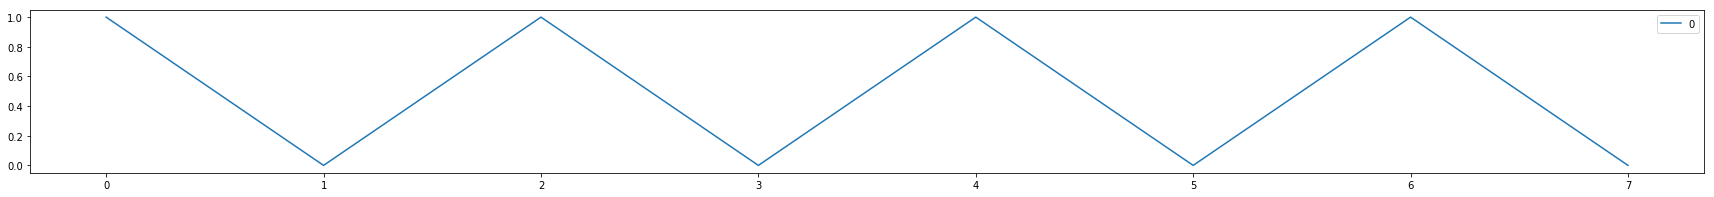

tID : 1,     Count of press : 9,  Count of release : 9


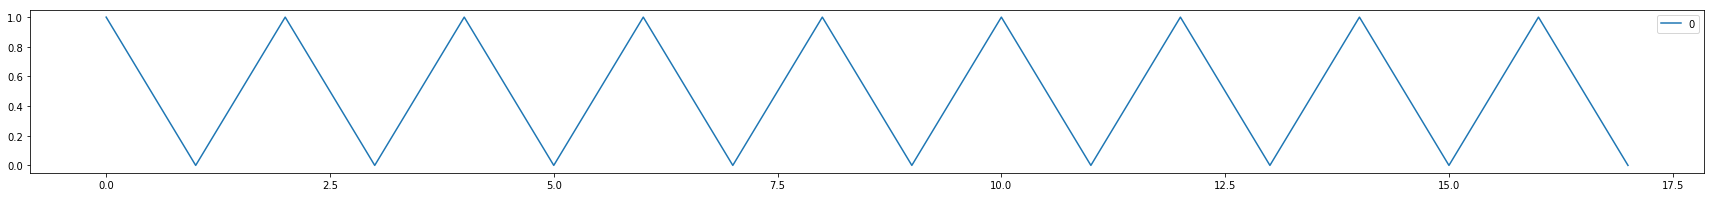

In [83]:
tID_list = dict()
tID_cur = dict()
tID_press = dict()
tID_release = dict()

for sec_input_line in sec_input_lines:
    if 'tID:' in sec_input_line:
        #print(sec_input_line)
        splited_sec_input = sec_input_line.split('tID:')[1]
        numbers = re.findall('\d+', splited_sec_input)
        tID = int(numbers[0])
        
        #display(tID)
        if tID not in tID_list:
            tID_list[tID] = list()
        if tID not in tID_cur:
            tID_cur[tID] = 0
        if tID not in tID_press:
            tID_press[tID] = 0
        if tID not in tID_release:
            tID_release[tID] = 0          

        if '[P]' in sec_input_line:
            tID_cur[tID] += 1
            tID_press[tID] += 1
        elif '[R]' in sec_input_line:
            tID_cur[tID] -= 1
            tID_release[tID] += 1

        if tID_cur[tID] not in tID_list[tID]:
            print(sec_input_line)

        tID_list[tID].append(tID_cur[tID])

print('\n\n')
for key in tID_list.keys():
    print('tID : {},     Count of press : {},  Count of release : {}'.format(key, tID_press[key], tID_release[key]))
    pd.DataFrame(tID_list[key]).plot(figsize=(30,3))
    plt.show()

* The count of noise in sec_input log should be kept with zero.

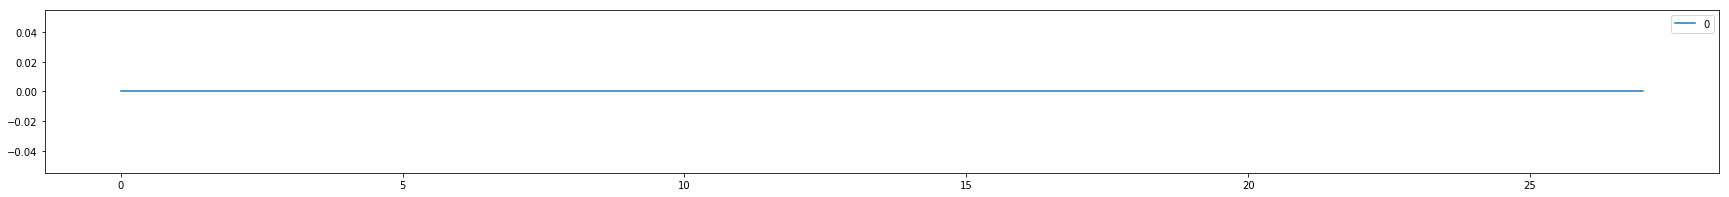

In [84]:
sec_input_noise = list()

for sec_input_line in sec_input_lines:
    #print(sec_input_line)
    if 'noise:(' in sec_input_line:
        #print(sec_input_line.split('noise:(')[1])
        number_of_noise = int(sec_input_line.split('noise:(')[1].split(',')[0])
        sec_input_noise.append(number_of_noise)
        if number_of_noise > 0:
            print(sec_input_line)
    elif 'noise:' in sec_input_line:
        #print(sec_input_line.split('noise:')[1])
        try:
            number_of_noise = int(sec_input_line.split('noise:')[1].split(',')[0])
        except:
            try:
                number_of_noise = int(sec_input_line.split('noise:')[1].split(' ')[0])
            except:
                number_of_noise = int(sec_input_line.split('noise:')[1].split('/')[0])
        sec_input_noise.append(number_of_noise)
        if number_of_noise > 0:
            print(sec_input_line)
if len(sec_input_noise):
    df = pd.DataFrame(sec_input_noise)
    df.plot(figsize=(30,3))
else:
    print('---No data---')

* This logs are shown when processing input events normally after a problem happened.

In [85]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Conflicting pointer actions'], 1)

--- Nothing ---


* Volume up : InputReader: Input event: ... code=114
* Volume dn : InputReader: Input event: ... code=115
* Power key : InputReader: Input event: ... code=116 
* Touch key is same with normal touch.
<br>
* Those log makes a problem.<br>
4347099790 - 01-19 07:31:39.790  1000  1197  2071 I InputDispatcher: Delivering touch to (5379): action: 0x1, f=0x20000000, d=0, '79427d5', t=1 +(-357,-2333)<br>
4347099792 - 01-19 07:31:39.792  1000  1197  2371 D InputDispatcher: Inject motion (2575): action=0x0, time=1050741000000, f=0x20000000, d=0<br>
4347099792 - 01-19 07:31:39.792  1000  1197  2071 I InputDispatcher: Delivering touch to (5379): action: 0x0, f=0x20000000, d=0, '79427d5', t=1 +(-357,-2333)<br>
4347099792 - 01-19 07:31:39.792  1000  1197  2371 D InputDispatcher: Inject motion (2575): action=0x1, time=1050742000000, f=0x20000000, d=0<br>
4347099792 - 01-19 07:31:39.792  1000  1197  2071 I InputDispatcher: Delivering touch to (5379): action: 0x1, f=0x20000000, d=0, '79427d5', t=1 +(-357,-2333)<br>
4347099794 - 01-19 07:31:39.794  1000  1197  2371 D InputDispatcher: Inject motion (2575): action=0x0, time=1050741000000, f=0x20000000, d=0<br>


In [86]:
def printandinit():
    if checklog['kernel'] is False:
        print('>>>>> KERNEL LOG is missing!!! <<<<<')

    if checklog['reader'] is False:
        print('>>>>> InputReader LOG is missing!!! <<<<<')

    if checklog['dispatcher'] is False:
        print('>>>>> InputDispatcher LOG is missing!!! <<<<<')

    checklog['kernel'] = False
    checklog['reader'] = False
    checklog['dispatcher'] = False

lines = lp.log_sections['SYSTEM LOG']
Reader_Dispatchers = grep(lines,['InputDispatcher', 'InputReader'], 1, show=False)

lines = lp.log_sections['KERNEL LOG']
kernel_sec_inputs = grep(lines,['sec_input', '@Sync'], 1, show=False)

idx_reader_dispatcher = 0
idx_sec_input = 0

checklog = dict()
checklog['kernel'] = False
checklog['reader'] = False
checklog['dispatcher'] = False

sync_time = None
sync_kernel_log = None

while True:
    if idx_sec_input >= len(kernel_sec_inputs):
        break
    
    if idx_reader_dispatcher >= len(Reader_Dispatchers):
        break

    reader_dispatcher = Reader_Dispatchers[idx_reader_dispatcher]
    kernel_sec_input = kernel_sec_inputs[idx_sec_input]
    
    if '@Sync' in kernel_sec_input:
        androidtime = GetTime(kernel_sec_input)
        kerneltime = GetKernelTime(kernel_sec_input)

        if androidtime >= 0 and kerneltime >= 0:
            GAP_OF_TIME = androidtime - kerneltime
            sync_time = '[ SYNC {} = {} - {} ]'.format(GAP_OF_TIME, androidtime, kerneltime)
            sync_kernel_log = kernel_sec_input
        
        idx_sec_input += 1
        if idx_sec_input >= len(kernel_sec_inputs):
            break
        kernel_sec_input = kernel_sec_inputs[idx_sec_input]
            
    
    reader_dispatcher_time = GetTime(reader_dispatcher)
    if '[P]' in kernel_sec_input or '[R]' in kernel_sec_input or ' 114,' in kernel_sec_input or ' 115,' in kernel_sec_input or ' 116,' in kernel_sec_input:
        kernel_sec_input_time = GetKernelTime(kernel_sec_input) + GAP_OF_TIME
    elif 'Finger' in kernel_sec_input or 'gpio_keys_gpio_report_event' in kernel_sec_input:
        kernel_sec_input_time = GetKernelTime(kernel_sec_input) + GAP_OF_TIME
    else:
        idx_sec_input += 1
        continue
    
    if reader_dispatcher_time < kernel_sec_input_time:
        if 'InputReader' in reader_dispatcher:
            checklog['reader'] = True
            if checklog['kernel'] is False:
                if 'Btn_touch' in reader_dispatcher or 'Input event' in reader_dispatcher:
                    printandinit()
                    print("")
        if 'InputDispatcher' in reader_dispatcher:
            checklog['dispatcher'] = True
        print("{} - {}".format(reader_dispatcher_time, reader_dispatcher))
        idx_reader_dispatcher += 1
    else:
        printandinit()

        if sync_time is not None:
            print("")
            print(sync_time)
            print(sync_kernel_log)
            sync_time = None

        print("")
        if ' 114,' in kernel_sec_input:
            print("[[[ VOL UP KEY ]]]")
        elif ' 115,' in kernel_sec_input:
            print("[[[ VOL DN KEY ]]]")
        elif ' 116,' in kernel_sec_input:
            print("[[[ POWER KEY ]]]")
        print("{} - {}".format(kernel_sec_input_time, kernel_sec_input))
        idx_sec_input += 1
        checklog['kernel'] = True

5481389235 - 02-05 10:36:29.235  1000   979   979 D InputReader: Constructor for InputReader()
5481389347 - 02-05 10:36:29.347  5555   513   513 E audit   : type=1400 audit(1612488989.339:97): avc:  denied  { read } for  pid=979 comm="InputReader" name="name" dev="sysfs" ino=31855 scontext=u:r:system_server:s0 tcontext=u:object_r:sysfs:s0 tclass=file permissive=0 SEPF_SM-N971N_11_0006 audit_filtered
5481389347 - 02-05 10:36:29.347  5555   513   513 E audit   : type=1300 audit(1612488989.339:97): arch=c00000b7 syscall=56 success=no exit=-13 a0=ffffff9c a1=717b0f7f10 a2=0 a3=0 items=0 ppid=537 pid=979 auid=4294967295 uid=1000 gid=1000 euid=1000 suid=1000 fsuid=1000 egid=1000 sgid=1000 fsgid=1000 tty=(none) ses=4294967295 comm="InputReader" exe="/system/bin/app_process64" subj=u:r:system_server:s0 key=(null)
5481389350 - 02-05 10:36:29.350  1000   979   979 D InputDispatcher: mTalkBackMode : 0
5481389384 - 02-05 10:36:29.384  5555   513   513 E audit   : type=1400 audit(1612488989.379:98)

In [87]:
Reader_Dispatchers = grep(lines,['Touch event\'s action is'], 1, show=False)
for line in Reader_Dispatchers:
    if 'Btn_touch' in line:
        print('')
    print(line)

--- Nothing ---


In [88]:
lines = lp.log_sections['OLOG']
olog_locks = grep(lines, ['INPUTD'], 1)

--- Nothing ---


* Touch HW error<br>
ex) An error occured at Rx36<br>
[    5.247112] sec_ts 2-0048 : Rx34 |  307 319 320 322 327 327 328 333 334 332 329 327 326 323 321 319 324<br>
[    5.247129] sec_ts 2-0048 : Rx35 |  313 325 327 329 333 333 335 340 342 340 337 335 333 331 329 325 330<br>
[    5.247146] sec_ts 2-0048 : Rx36 |   -1   0   0  -1   0   0   0   0   0   0   0   0   0   0   0   0   0<br>
[    5.247163] sec_ts 2-0048 : Rx37 |  207 254 256 258 261 261 262 268 226 268 264 262 261 259 257 255 228<br>

In [89]:
lines = lp.log_sections['KERNEL LOG']
sec_input_lines = grep(lines,['sec_ts'], 1, show=False)
lines = lp.log_sections['TSP RAW DATA']
sec_input_lines += grep(lines,['sec_ts'], 1, show=False)

x = list()
x_ = list()
for sec_input_line in sec_input_lines:
    if re.search("Rx00", sec_input_line):
        if len(x_) > 0:
            x.append(x_)
            x_ = list()
            print("")
    if re.search("Rx[0-9][0-9]", sec_input_line):
        print(sec_input_line)
        splited = sec_input_line.split('|')
        if len(splited) > 0:
            splited_items = splited[1].split(' ')
            for splited_item in splited_items:
                if len(splited_item) > 0:
                    x_.append(int(splited_item))
x.append(x_)

[    3.345308] sec_ts 4-0048 : Rx00 |   20  36  42  34  36  40  42  42  43  43  41  39  39  41  43  39  22
[    3.345323] sec_ts 4-0048 : Rx01 |   32  52  56  52  54  52  52  50  51  53  51  51  55  57  59  59  34
[    3.345339] sec_ts 4-0048 : Rx02 |   34  56  52  46  45  45  41  43  44  44  40  44  48  50  56  62  35
[    3.345355] sec_ts 4-0048 : Rx03 |   35  51  47  37  35  35  33  31  32  34  32  34  43  43  51  57  36
[    3.345370] sec_ts 4-0048 : Rx04 |   32  52  42  30  30  28  24  26  24  22  24  26  33  37  45  51  36
[    3.345386] sec_ts 4-0048 : Rx05 |   36  52  40  28  23  21  21  17  18  20  22  24  33  33  47  53  34
[    3.345401] sec_ts 4-0048 : Rx06 |   39  53  37  29  25  21  17  19  18  18  18  22  28  36  44  52  36
[    3.345417] sec_ts 4-0048 : Rx07 |   38  50  40  32  24  20  22  18  20  22  20  22  29  35  45  53  36
[    3.345433] sec_ts 4-0048 : Rx08 |   40  52  42  30  24  24  18  18  22  18  18  18  30  36  46  56  40
[    3.345448] sec_ts 4-0048 : Rx09 |

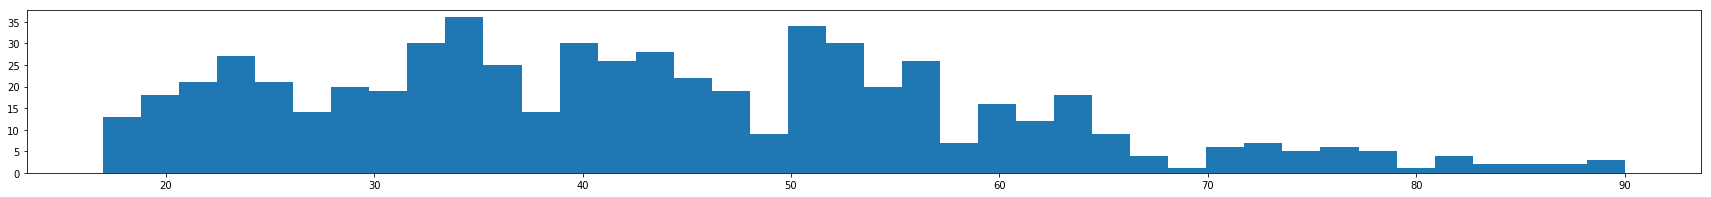

mean : 43.4411764706,  standard deviation : 15.8270308588


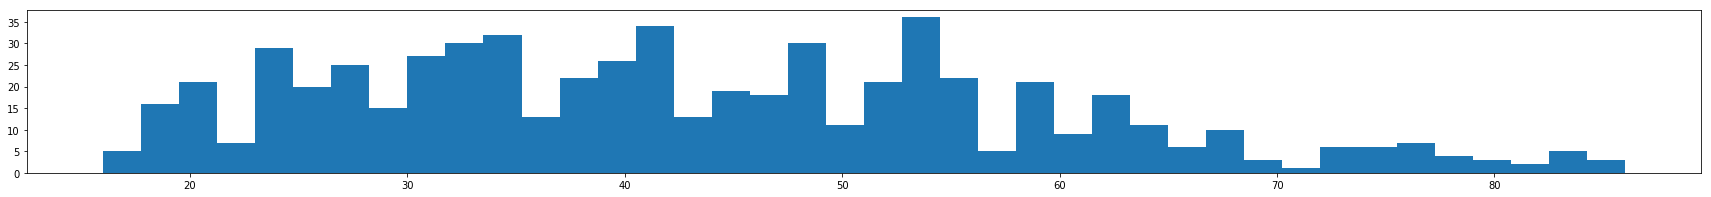

mean : 43.1633986928,  standard deviation : 15.7566077088


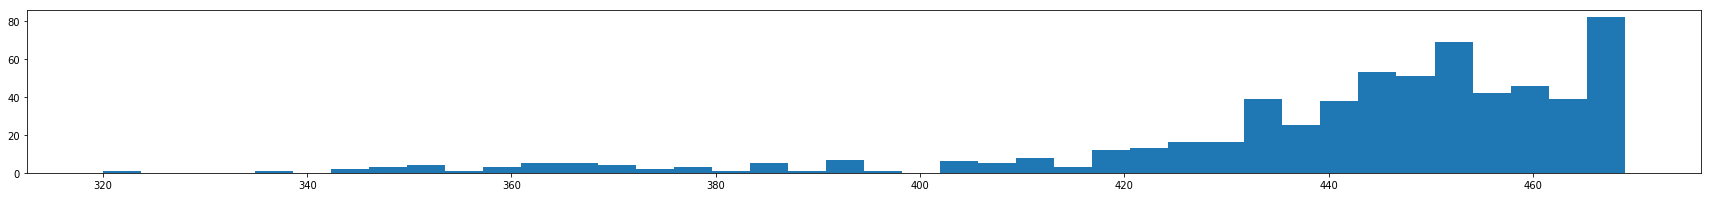

mean : 441.578431373,  standard deviation : 26.4000530827


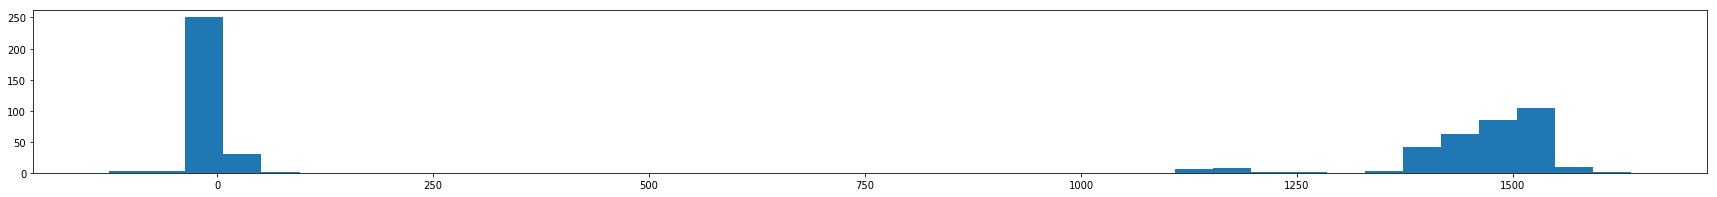

mean : 768.985294118,  standard deviation : 735.51164761


In [90]:
for x_ in x:
    plt.figure(figsize=(30, 3))
    plt.hist(x_, bins = 40)
    plt.show()

    arr = np.array(x_)
    print("mean : {},  standard deviation : {}".format(arr.mean(), arr.std()))

# <span style="color:blue">[BOTTLENECKS]</span> 

* If 'dalvik.vm.lockprof.threshold' property is not exist, lock monitor contention is off.

In [91]:
lines = lp.log_sections['SYSTEM PROPERTIES']
tmp = grep(lines,['dalvik.vm.lockprof.threshold'], 1)

[dalvik.vm.lockprof.threshold]: [500]


In [92]:
lines = lp.log_sections['SYSTEM LOG']
Long_monitor_lines = grep(lines,['Long monitor contention with owner'], 1)

02-05 10:36:36.409  1000   979  1020 W system_server: Long monitor contention with owner main (979) at void com.android.server.pm.AppsFilter.lambda$create$0(com.android.server.pm.PackageManagerService$Injector, com.android.server.pm.AppsFilter$StateProvider$CurrentStateCallback)(AppsFilter.java:345) waiters=0 in android.content.pm.ProviderInfo com.android.server.pm.ComponentResolver.queryProvider(java.lang.String, int, int) for 3.402s
02-05 10:36:36.411  1000   979  1013 W system_server: Long monitor contention with owner main (979) at void com.android.server.pm.AppsFilter.lambda$create$0(com.android.server.pm.PackageManagerService$Injector, com.android.server.pm.AppsFilter$StateProvider$CurrentStateCallback)(AppsFilter.java:345) waiters=2 in int com.android.server.pm.PackageManagerService.getPackageUidInternal(java.lang.String, int, int, int) for 2.519s
02-05 10:36:36.439  1000   979  1301 W system_server: Long monitor contention with owner main (979) at boolean com.android.server.pm.

In [93]:
lines = lp.log_sections['SYSTEM LOG']
Long_monitor_lines = grep(lines,['Slow delivery took'], 1)

02-05 10:36:38.081  1000   979  1233 W Looper  : Slow delivery took 325ms PackageManagerHandlerThread h=android.os.Handler c=<recycled PooledLambda@20d3405> m=0
02-05 10:36:38.669  1000   979   979 W Looper  : Slow delivery took 14805ms main h=android.app.PropertyInvalidatedCache$AutoCorker$1 c=null m=0
02-05 10:36:42.382  1000   979   979 W Looper  : Slow delivery took 412ms main h=com.android.server.job.controllers.QuotaController$QcHandler c=null m=3
02-05 10:36:49.506  1000   979  1233 W Looper  : Slow delivery took 212ms PackageManagerHandlerThread h=android.os.Handler c=<recycled PooledLambda@e4b5094> m=0
02-05 10:37:15.047  1000   979   979 W Looper  : Slow delivery took 215ms main h=android.os.Handler c=ServiceConnector@45(Intent { act=android.app.role.RoleControllerService cmp=com.google.android.permissioncontroller/com.android.permissioncontroller.role.service.RoleControllerServiceImpl }, user: 0)[Unbinding...] m=0
02-05 10:38:13.484  1000   979  1011 W Looper  : Slow deliver

In [94]:
tmp = grep(Long_monitor_lines,['[0-9].[0-9][0-9][0-9]s', '[5-9][0-9][0-9]ms'], 1)

02-05 10:36:38.669  1000   979   979 W Looper  : Slow delivery took 14805ms main h=android.app.PropertyInvalidatedCache$AutoCorker$1 c=null m=0
02-05 10:38:13.484  1000   979  1011 W Looper  : Slow delivery took 1548ms android.fg h=com.android.server.AppStateTracker$MyHandler c=null m=6
02-05 10:38:15.615  1000   979   979 W Looper  : Slow delivery took 613ms main h=com.android.server.job.JobSchedulerService$JobHandler c=null m=7
02-05 10:38:25.829  1000   979   979 W Looper  : Slow delivery took 589ms main h=android.os.Handler c=android.app.-$$Lambda$LoadedApk$ReceiverDispatcher$Args$_BumDX2UKsnxLVrE6UJsJZkotuA@aa5ff68 m=0
02-05 10:39:24.082  1000   979   979 W Looper  : Slow delivery took 517ms main h=android.os.Handler c=android.app.-$$Lambda$LoadedApk$ReceiverDispatcher$Args$_BumDX2UKsnxLVrE6UJsJZkotuA@21a2336 m=0
02-05 10:39:27.056  1000   979   979 W Looper  : Slow delivery took 530ms main h=android.app.ActivityThread$H c=null m=121
02-05 10:39:35.189  1000   979  1012 W Looper  

In [95]:
lines = lp.log_sections['EVENT LOG']
tmp = grep(lines,['dvm_lock_sample'], 1)

02-05 10:36:36.410  1000   979  1020 I dvm_lock_sample: [system_server,0,android.bg,3402,ComponentResolver.java,363,android.content.pm.ProviderInfo com.android.server.pm.ComponentResolver.queryProvider(java.lang.String, int, int),AppsFilter.java,345,void com.android.server.pm.AppsFilter.lambda$create$0(com.android.server.pm.PackageManagerService$Injector, com.android.server.pm.AppsFilter$StateProvider$CurrentStateCallback),100]
02-05 10:36:36.411  1000   979  1013 I dvm_lock_sample: [system_server,0,android.io,2519,PackageManagerService.java,5800,int com.android.server.pm.PackageManagerService.getPackageUidInternal(java.lang.String, int, int, int),AppsFilter.java,345,void com.android.server.pm.AppsFilter.lambda$create$0(com.android.server.pm.PackageManagerService$Injector, com.android.server.pm.AppsFilter$StateProvider$CurrentStateCallback),100]
02-05 10:36:36.439  1000   979  1301 I dvm_lock_sample: [system_server,0,wifiRttService,2603,PackageManagerService.java,5800,int com.android.s

* Critical issues in OLOG.

In [96]:
lines = lp.log_sections['OLOG']
olog_locks = grep(lines, ['MAINLOOPER', 'LOCKCONTENTION', 'LOADAPK', 'INPUTD'], 1)

[02-05 10:36:36.410 2   979     0 ( 18)][EVT][LOCKCONTENTION] [DELAY_INFO] LOCKC
[02-05 10:36:36.410 2   979     0 (212)][EVT][LOCKCONTENTION] android.bg/3402/AppsFilter.java/345/void com.android.server.pm.AppsFilter.lambda$create$0(com.android.server.pm.PackageManagerService$Injector, com.android.server.pm.AppsFilter$StateProvider$CurrentStateCallback)
[02-05 10:36:36.411 2   979     0 ( 18)][EVT][LOCKCONTENTION] [DELAY_INFO] LOCKC
[02-05 10:36:36.411 2   979     0 (212)][EVT][LOCKCONTENTION] android.io/2519/AppsFilter.java/345/void com.android.server.pm.AppsFilter.lambda$create$0(com.android.server.pm.PackageManagerService$Injector, com.android.server.pm.AppsFilter$StateProvider$CurrentStateCallback)
[02-05 10:36:36.439 2   979     0 ( 18)][EVT][LOCKCONTENTION] [DELAY_INFO] LOCKC
[02-05 10:36:36.439 2   979     0 (143)][EVT][LOCKCONTENTION] wifiRttService/2603/ComponentResolver.java/466/boolean com.android.server.pm.ComponentResolver.isActivityDefined(android.content.ComponentName)
[

In [97]:
olog_locks = grep(olog_locks, ['[0-9][0-9][0-9][0-9]ms',], 1)

[02-05 10:38:15.615 1   979     0 ( 97)][LOG][MAINLOOPER]  Slowdispatch took 1015ms main h=com.android.server.job.JobSchedulerService$JobHandler c=null m=7


In [98]:
lines = lp.log_sections['OLOG']
olog_locks = grep(lines, ['LOCKCONTENTION',], 1)

[02-05 10:36:36.410 2   979     0 ( 18)][EVT][LOCKCONTENTION] [DELAY_INFO] LOCKC
[02-05 10:36:36.410 2   979     0 (212)][EVT][LOCKCONTENTION] android.bg/3402/AppsFilter.java/345/void com.android.server.pm.AppsFilter.lambda$create$0(com.android.server.pm.PackageManagerService$Injector, com.android.server.pm.AppsFilter$StateProvider$CurrentStateCallback)
[02-05 10:36:36.411 2   979     0 ( 18)][EVT][LOCKCONTENTION] [DELAY_INFO] LOCKC
[02-05 10:36:36.411 2   979     0 (212)][EVT][LOCKCONTENTION] android.io/2519/AppsFilter.java/345/void com.android.server.pm.AppsFilter.lambda$create$0(com.android.server.pm.PackageManagerService$Injector, com.android.server.pm.AppsFilter$StateProvider$CurrentStateCallback)
[02-05 10:36:36.439 2   979     0 ( 18)][EVT][LOCKCONTENTION] [DELAY_INFO] LOCKC
[02-05 10:36:36.439 2   979     0 (143)][EVT][LOCKCONTENTION] wifiRttService/2603/ComponentResolver.java/466/boolean com.android.server.pm.ComponentResolver.isActivityDefined(android.content.ComponentName)
[

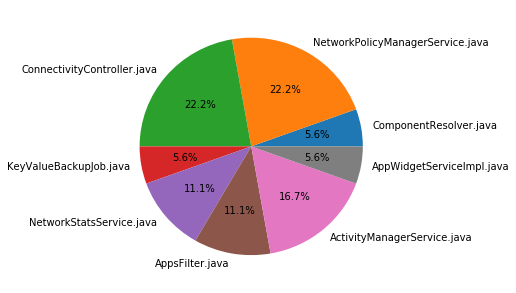

In [99]:
locks_state = dict()
for line in olog_locks:
    if 'LOCKCONTENTION' in line:
        splited_line = line.split('/')
        if len(splited_line) > 2:
            status = splited_line[2]
            locks_state[status] = locks_state.get(status, 0) + 1

#df.plot.pie(y='0', figsize=(5, 5), autopct='%1.1f%%', startangle=100)
plt.figure(figsize=(5, 5))
plt.pie(locks_state.values(), labels = locks_state.keys(), autopct='%1.1f%%') 
plt.show() 

In [100]:
lines = lp.log_sections['OLOG']
olog_locks = grep(lines, ['MUTEX'], 1)

[02-05 10:38:31.318 1  5340     0 (195)][LOG][MUTEX] 64 jiffies f2fs_issue_checkpoint+0xa0/0x234 f2fs_sync_fs+0x11c/0x19c f2fs_do_sync_file+0x518/0x840 f2fs_ioctl+0x16ac/0x29cc do_vfs_ioctl+0x69c/0xa14 SyS_ioctl+0x88/0x98 __sys_trace_return+0x0/0x4
[02-05 10:38:40.222 1  5738     0 (209)][LOG][MUTEX] 45 jiffies f2fs_issue_checkpoint+0xa0/0x234 f2fs_sync_fs+0x11c/0x19c f2fs_do_sync_file+0x518/0x840 f2fs_ioctl+0x16ac/0x29cc f2fs_compat_ioctl+0x228/0x248 compat_SyS_ioctl+0x128/0x248 __sys_trace_return+0x0/0x4


In [101]:
lines = lp.log_sections['OLOG']
olog_locks = grep(lines, ['PSI'], 1)

--- Nothing ---


In [102]:
lines = lp.log_sections['OLOG']
tmp = grep(lines,['APPLAUNCH', 'LCDV'], 1)

[02-05 10:36:38.933 2   979     0 ( 38)][EVT][APPLAUNCH] com.android.settings/.FallbackHome [S]
[02-05 10:36:38.948 2   979     0 ( 24)][EVT][APPLAUNCH] com.android.settings [C]
[02-05 10:36:40.810 2   979     0 ( 24)][EVT][APPLAUNCH] com.android.settings [C]
[02-05 10:36:44.137 2   979     0 ( 24)][EVT][APPLAUNCH] com.android.settings [C]
[02-05 10:37:00.765 1   979     0 ( 12)][LOG][LCDV] DOZE_SUSPEND
[02-05 10:37:06.100 2   979     0 ( 24)][EVT][APPLAUNCH] com.android.settings [C]
[02-05 10:37:06.131 1   979     0 (  4)][LOG][LCDV] DOZE
[02-05 10:37:06.336 1   979     0 ( 12)][LOG][LCDV] DOZE_SUSPEND
[02-05 10:37:24.081 1   979     0 (  4)][LOG][LCDV] DOZE
[02-05 10:37:24.203 1   979     0 ( 12)][LOG][LCDV] DOZE_SUSPEND
[02-05 10:37:34.062 2   979     0 ( 24)][EVT][APPLAUNCH] com.android.settings [C]
[02-05 10:38:00.102 1   979     0 (  4)][LOG][LCDV] DOZE
[02-05 10:38:00.369 1   979     0 ( 12)][LOG][LCDV] DOZE_SUSPEND
[02-05 10:38:04.077 1   979     0 (  4)][LOG][LCDV] DOZE
[02-05

In [103]:
lines = lp.log_sections['OLOG']
olog_locks = grep(lines, ['AVG=[5-9][0-9]'], -30)

--- Nothing ---


In [104]:
lines = lp.log_sections['OLOG']
olog_locks = grep(lines, ['INPUTD'], 1)

--- Nothing ---


# <span style="color:blue">[GAME]</span> 

### History of game packages

In [105]:
lines = ssrm.file_lines
game_lines = grep(lines,['DSS :', 'PKG'], 1, show=False)
game_lines = grep(game_lines,['DSS :'], 2)

--- Nothing ---


In [106]:
lines = ssrm.file_lines
game_lines = grep(lines,['DSS :', 'SPA', 'GAMESDK', 'GameThermalCpuControl'], 1)

--- Nothing ---


In [107]:
searchers = dict()
searchers['FPS'] = 0
searchers['CF'] = 1
searchers['GF'] = 1
searchers['Lv'] = 0

fps_cf = DictFromPickedUp(game_lines, searchers)

#display(fps_cf['Lv-'])

if len(game_lines) > 0:
    df = pd.DataFrame(fps_cf)
    df = df.replace(1, CPU_MAX_FREQ/1000)

    if 'FPS' in df.columns and len(df['FPS']) > 0:
        df['FPS'].plot(figsize=(30,4), legend=True)
        plt.ylim(0, 120)
    if 'CF' in df.columns and len(df['CF']) > 0:
        df['CF'].plot(secondary_y=True, color='red', figsize=(30,4), legend=True)
    if 'FPS' in df.columns and len(df['FPS']) > 0 and 'CF' in df.columns and len(df['CF']) > 0:
        df.plot.scatter('FPS', 'CF', figsize=(30,10))
        plt.xlim(0, 120)

In [108]:
if len(game_lines) > 0:
    if 'FPS' in df.columns and len(df['FPS']) > 0:
        df['FPS'].plot(figsize=(30,4), legend=True)
        plt.ylim(0, 120)
    if 'GF' in df.columns and len(df['GF']) > 0:
        df['GF'].plot(secondary_y=True, figsize=(30,4), legend=True)
    if 'FPS' in df.columns and len(df['FPS']) > 0 and 'GF' in df.columns and len(df['GF']) > 0:
        df.plot.scatter('FPS', 'GF', figsize=(30,10))
        plt.xlim(0, 120)

In [109]:
if len(game_lines) > 0:
    df = pd.DataFrame(fps_cf)

    if 'FPS' in df.columns and len(df['FPS']) > 0:
        df['FPS'].plot(figsize=(30,4), legend=True)
        plt.ylim(0, 120)
    if 'Lv' in df.columns and len(df['Lv']) > 0:
        df['Lv'].plot(secondary_y=True, color='purple', figsize=(30,4), legend=True)

# <span style="color:blue">[TENDS]</span> 

* Focus on the lines on TOP logs when LCD on, because TOP logs have to be false alarm when LCD is off.

In [110]:
lines = ssrm.file_lines
top_lines = grep(lines,['TOP', 'LCD', 'PKG', '===== '], 1, show=False)

top_lines_with_LCD_on = MarkupLCDON(top_lines)

TOP DUMP Based on SIOP Level============================================================================================================================================================================================================
2021-02-03 17:11:35 [SET] [NF0XOOOMHXXXXXXWXX / Wifi:"KT_WLAN_5E78_5GHz",5220MHz] [LCD] ON 7976  [sleep_count = 137, sleep_time_sec = 997]
 LCDON >>> 2021-02-03 17:11:42 [PKG] com.appgenix.bizcal
2021-02-03 17:12:44 [SET] [NF0XXOOMHXXXXXXWXX / Wifi:"KT_WLAN_5E78_5GHz",5220MHz] [LCD] OFF 8010
2021-02-03 17:13:40 [TOP] [com.samsung.android.app.notes=10.94%] [system_server=2.73%] [com.android.systemui=0.49%] [android.system.suspend@1.0-service=0.40%] [logd=0.36%]
2021-02-03 17:15:35 [SET] [NF0XOOOMHXXXXXXWXX / Wifi:"KT_WLAN_5E78_5GHz",5220MHz] [LCD] ON 8200  [sleep_count = 6, sleep_time_sec = 23]
 LCDON >>> 2021-02-03 17:15:44 [PKG] com.sec.android.app.launcher
2021-02-03 17:16:54 [SET] [NF0XXOOMHXXXXXXWXX / Wifi:"KT_WLAN_5E78_5GHz",5220MHz] [LCD] OFF 8265
202

* Frequncy of cpu usage of each packages

In [111]:
rawdata = dict()
for line in top_lines_with_LCD_on:
    if 'LCDON' in line:
        curdata = orderbyeq(line)
        for key in curdata.keys():
            if key not in rawdata:
                rawdata[key] = list()
            rawdata[key].append(curdata[key])    
    
if len(rawdata) == 0:
    for line in top_lines_with_LCD_on:
        curdata = orderbyeq(line)
        for key in curdata.keys():
            if key not in rawdata:
                rawdata[key] = list()
            rawdata[key].append(curdata[key])
#display(top_lines_with_LCD_on)

df = DataframeFromDictSortByCount(rawdata)
df_dis = df.fillna('-')
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)
display(df_dis)

/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  after removing the cwd from sys.path.


0   1   2   3   4   5    \
system_server                                         1   2   2   1   2   1   
surfaceflinger                                        1   1   1   0   0   1   
com.samsung.android.honeyboard                        0   1   0   1   0   1   
audioserver                                           0   0   0   0   0   0   
sugov:6                                               0   0   0   0   0   0   
com.android.systemui                                  0   0   0   0   0   0   
com.samsung.android.voc                               1   2   0   1   2   2   
com.sec.android.app.camera                            1   0   0   1   1   0   
com.kt.otv                                            0   0   4   2   0   1   
com.nhn.android.search                                1   6   0   1   2   0   
com.google.android.webview:sandboxed_process0:o...    1   2   3   0   1   0   
mediaserver                                           0   0   0   2   2   2   
com.lifeoverflow.app.weather                          0   3   1   1   1   1   
com.samsung.android.lool                              0   0   0   0   0   0   
com.android.bluetooth                                 1   0   2   1   1   1   
android.system.suspend@1.0-service                    0   0   0   0   0   0   
vendor.samsung.hardware.camera.provider@4.0-ser...    0   3   1   1   4   5   
com.towneers.www                                      0   0   1   0   0   0   
sugov:0                                               0   0   0   0   0   0   
com.kakao.talk                                        0   4   0   1   0   0   
com.nhn.android.search:sandboxed_process0:org.c...    1   1   0   0   0   2   
com.kt.ollehusimmanager                               3   2   1   1   2   1   
com.samsung.ipservice                                 1   0   0   1   1   0   
com.appgenix.bizcal                                   0   0   0   0   0   0   
com.fineappstudio.android.petfriends                  2   1   0   2   3   -   
com.kt.otv:audio                                      3   1   2  11   1   -   
tz_worker_threa                                       0   0   0   0   0   -   
com.samsung.android.app.notes                         3   6   6   2   0   -   
com.sec.android.app.launcher                          0   0   0   0   -   -   
statsd                                                0   0   0   -   -   -   
com.kbstar.liivbank                                   0   0   0   -   -   -   
com.kt.ktauth                                         3   3   3   -   -   -   
android.hardware.audio.service                        0   0   0   -   -   -   
com.google.android.gms.persistent                     0   1   0   -   -   -   
com.ahnlab.v3mobileplus                               0   0   0   -   -   -   
com.samsung.android.dialer                            0   0   0   -   -   -   
com.shinhan.sbanking                                  3   2   3   -   -   -   
com.samsung.android.bixby.agent                       1   0   0   -   -   -   
com.cashwalk.cashwalk                                 0   0   -   -   -   -   
com.kakao.taxi                                        0   1   -   -   -   -   
mangoslab.nemonic                                     1   4   -   -   -   -   
com.samsung.android.messaging                         0   0   -   -   -   -   
kr.co.adt.fnsys.viewguard                             0   5   -   -   -   -   
net.daum.android.map                                  0   0   -   -   -   -   
com.sampleapp                                         0   2   -   -   -   -   
com.google.android.googlequicksearchbox:search        0   0   -   -   -   -   
media.codec                                           0   2   -   -   -   -   
com.kbstar.kbbank                                     0   1   -   -   -   -   
com.android.vending                                   1   0   -   -   -   -   
com.android.settings                                  0   1   -   -   -   -   
com.ktmusic.geniemusic 

* This shows cpu usage over 10 percent.
* In the case of cpu usage in SSRM, it can have unexpectible value by idle time reset when core is offline.<br>
(ex. Sum of the usage is over 100%. Under 0.)

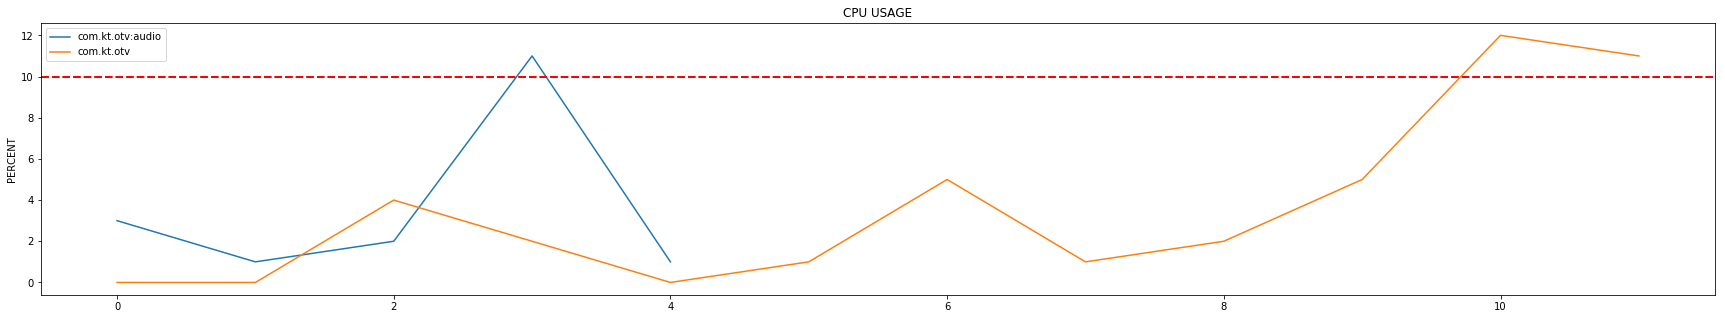

In [112]:
PlotFromDict(rawdata, 10, 'CPU USAGE', 'PERCENT')

# COM Information in SSRM log

In [113]:
lines = ssrm.file_lines
set_lines = grep(lines,['SET'], 1, show=True)

SSRM SETTINGS ENGINE
[SET] [NDX0XWXOXXXXXXX] => [PowerSavingMode/UltraPowerSavingMode/EmgergencyMode/NormalMode, ChargingStatus(aFc, Ac, Usb, Wireless, Charge, Discharge), Cooldown, KnoxMode, Screen, AOD, AutoBright, DisplayType, HrrMode, CameraOn, MusicOn, VideoPlaying, UsbTethering, CallState, SilentLog, Radio or WiFi, BTEnable, BTConnect / WiFi Info / BT Info]
2021-02-03 17:11:35 [SET] [NF0XOOOMHXXXXXXWXX / Wifi:"KT_WLAN_5E78_5GHz",5220MHz] [LCD] ON 7976  [sleep_count = 137, sleep_time_sec = 997]
2021-02-03 17:11:35 [SET] [NF0XOOOMHXXXXXXWXX / Wifi:"KT_WLAN_5E78_5GHz",5220MHz] CP Low Mode : false (r:0)
2021-02-03 17:12:04 [SET] [NF0XOOOMHXXXXXXWXX / Wifi:"KT_WLAN_5E78_5GHz",5220MHz] >>> [5G] Usage State (SIM # : 0) = (Total : 464, Nr2 : 464_0, Nr3 : 0_0, NrB1 : 0_0, NrB2 : 0_0)
2021-02-03 17:12:44 [SET] [NF0XXOOMHXXXXXXWXX / Wifi:"KT_WLAN_5E78_5GHz",5220MHz] [LCD] OFF 8010
2021-02-03 17:12:45 [SET] [NF0XXOOMHXXXXXXWXX / Wifi:"KT_WLAN_5E78_5GHz",5220MHz] CP Low Mode : true (r:4)
2021

H : performance mode<br>
P : PowerSavingMode<br>
U : UltraPowerSavingMode<br>
E : EmgergencyMode<br>
N : NormalMode

In [114]:
power_saving_mode = list()
for line in set_lines:
    splited_line = line.split("[")
    if len(splited_line) > 2:
        mode = splited_line[2]
        power_saving_mode.append(mode[0])
        
print(power_saving_mode)

['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',

In [115]:
lines = ssrm.file_lines
com_lines = grep(lines,['COM', 'PKG', 'LCD', '===== '], 1, show=True)

tmp = MarkupLCDON(com_lines)

[COM] [(SIOP Level)(AP_temp,PST_temp,BAT_temp,USB_temp,CHG_temp,PA_temp,CP_temp,MMW_temp,WIFI_temp,CF_temp,BLK_temp,SUBBAT_temp,LRP_temp,LRP2_temp<LRP2_type>,(BAT_level,Inow_avg,Isys_avg)(RSSI[common,Gsm/Cdma/Lte],Radio_data,Radio_RxTput,Radio_TxTput,Wifi_data,Wifi_signal_Level,Wifi_RxTput,Wif_TxTput)(Brightness,FPS,HRR),(Vidoe_Audio,AudioDevice:Volume)]
2021-02-03 17:06:14 [COM] [(-2->-2)(37,36,32,32,38,34,33,--,34,--,--,--,33,--:    -)( 75, 1753, 131)([ -92_1, 4G13],R:   0K,Rx:  0.0Mbps,Tx:  0.0Mbps,W:  28M,Lv-4,Rx:  0.1Mbps,Tx:  0.1Mbps)(BL: 92,FPS: 1.3,NA)(__,SPK: 0)][Core:0-7][CF! 520/2730,GF| 156/ 754,CG: -1,WT: -1,AD: 5,LB: -1,SB:-1,HT: -1,CL: 4,VL:-1,BG: -1,CO:-1,DR:-1,WP: -1] [LRPs => LRF:336 LRB:336] ScreenOff LowTput CPU : -1
2021-02-03 17:07:25 [COM] [(-2->-2)(35,36,32,31,37,33,32,--,33,--,--,--,32,--:    -)( 76, 1638, 250)([ -80_1, 4G13],R:   0K,Rx:  0.0Mbps,Tx:  0.0Mbps,W:   2M,Lv-4,Rx:  0.3Mbps,Tx:  0.2Mbps)(BL: 92,FPS: 1.5,NA)(__,SPK: 0)][Core:0-7][CF! 520/2730,GF| 156/

Text(0,0.5,'MHz')

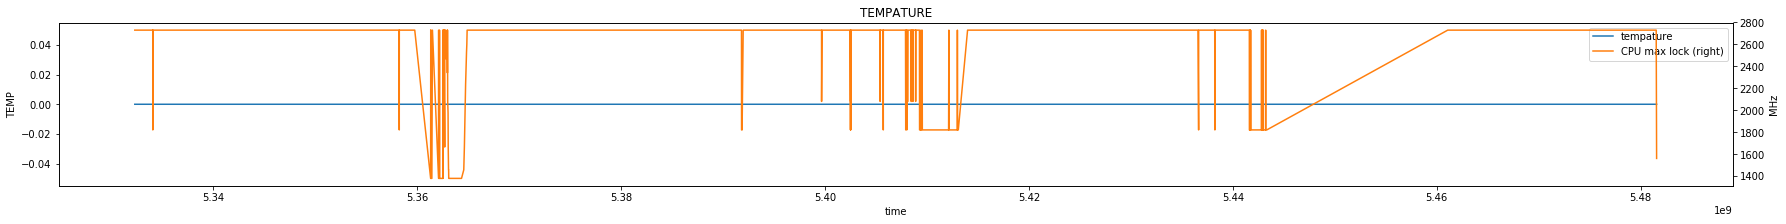

In [116]:
cpu_max_lock = dict()

cpu_max_lock['time'] = list()
cpu_max_lock['CPU max lock'] = list()
cpu_max_lock['tempature'] = list()

for com_line in com_lines:
    if 'ScreenOff' not in com_line and 'SIOP Level' not in com_line:
        #print(com_line)
        splited_line = com_line.split('[')

        tempature = 0
        if len(splited_line) > 2:
            ssrm_infor = splited_line[2].split(',')
            #display(ssrm_infor)
            if len(ssrm_infor) > 10:
                if ssrm_infor[10] == '--':
                    ssrm_infor[10] = '0'
                try:
                    tempature = int(ssrm_infor[10])
                except:
                    tempature = int(ssrm_infor[1])

        max_cf = pickedup(com_line, 'CF', index=1)
        if max_cf is None:
            continue
        if max_cf == 1:
            max_cf = CPU_MAX_FREQ/1000
        
        cpu_max_lock['time'].append(GetTime(com_line, type='SSRM'))
        cpu_max_lock['tempature'].append(tempature)
        cpu_max_lock['CPU max lock'].append(max_cf)
#display(cpu_max_lock['tempature'])
df = pd.DataFrame(cpu_max_lock)
df.index = df['time']
ax = df['tempature'].plot(figsize=(30,5), legend=True)
ax.set_title('TEMPATURE')
ax.set_ylabel('TEMP')

ax = df['CPU max lock'].plot(secondary_y=True, figsize=(30,3), legend=True)
ax.set_ylabel('MHz')

In [117]:
searchers = dict()
searchers['BL:'] = 0
searchers['CF'] = 1
without_screenoff = list()

for com_line in com_lines:
    if 'ScreenOff' not in com_line and 'SIOP Level' not in com_line:
        without_screenoff.append(com_line)

fps_cf = DictFromPickedUp(without_screenoff, searchers)

if len(game_lines) > 0:
    df = pd.DataFrame(fps_cf)
    df = df.replace(1, CPU_MAX_FREQ/1000)

    ax = df['BL:'].plot(figsize=(30,3), legend=True)
    ax.set_title('BACKLIGHT')
    ax.set_ylabel('BACKLIGHT')
    
    ax = df['CF'].plot(secondary_y=True, figsize=(30,3), legend=True)
    ax.set_ylabel('MHz')

# <span style="color:blue">[ACCESSIBILITY]</span> 

* Check the each items whether those are set as ture, except for this case.
    - mAccessibilityFocusOnlyInActiveWindow = true
<br><br>
* This feature could make a delay with 250 ms.
    - <span style="color:red">mIsDisplayMagnificationEnabled = true</span>
<br><br>
* If enabled services are exist, those could make loads on the core.
    - Ex) <br> 
    com.skt.tjunior, <br>
    com.samsung.accessory.fridaymgr process
<br><br>
* If the accessibility service use <span style="color:red">ally service</span>, it could make a sluggish problem.

In [118]:
lines = lp.log_sections['SERVICE accessibility']
accessibilities = grep(lines,['ACCESSIBILITY MANAGER'])

for accessibility in accessibilities:
    if 'true' in accessibility:
        print(' TRUE >>> ' + accessibility)

ACCESSIBILITY MANAGER (dumpsys accessibility)

currentUserId=0
User state[
attributes:{id=0
mIsMagniferWindowEnabled = false
mIsFollowTypingFocusEnabled = false
mIsTapDurationEnabled = false
mIsTouchBlockingEnabled = false
mIsStickyKeysEnabled = false
mIsBounceKeysEnabled = false
mIsSlowKeysEnabled = false
mIsTouchExplorationEnabled = false
mServiceHandlesDoubleTap =false
mRequestMultiFingerGestures = false
mIsTextHighContrastEnabled = false
mIsDisplayMagnificationEnabled = false
mIsAutoclickEnabled = false
mIsPerformGesturesEnabled = false
mIsFilterKeyEventsEnabled = false
mUserNonInteractiveUiTimeout = 0
mUserInteractiveUiTimeout = 0
mBindInstantServiceAllowed = false
mIsGestureNaviBar = false
}
shortcut key:{[]}
button:{[]}
directaccess:{[com.samsung.accessibility/com.samsung.accessibility.shortcut.ColorInversionShortcut]}
button target:{null}

installed services: {
0 : com.ktcs.whowho/.service.WhoWhoAccessibilityService
1 : com.microsoft.appmanager/com.microsoft.mmx.screenmirroring

* Refer the answer from accesibility if a problem to be related for accessibilty is exist in the PLM.

접근성 서비스의 경우 아래와 같은 대표적인 기능이 있습니다.<br>
 · 각 app의 현재 상태, 구조 정보 획득<br>
 · 각 app에서 발생하는 이벤트 및 알림(notification) 정보를 가져 올 수 있음 (카톡 등과 같은 메신저의 미리보기 서비스 이용하여 메시지 캐치가 가능)<br>
 · 사용자의 키보드 입력 정보 (검색어 등 사용자가 입력한 값 추출 가능)<br>
 · 사용자의 제스처(터치) 동작 인식<br>

이런 강력한 기능 및 권한들이 원래는 Android OS에서 사회적 약자(장애인, 노약자, 어린이 등)를 위한 접근성 기능들을 제공하기 위한 서비스로서 개발 된 것들이나 각종 3rd party 앱들이 이러한 기능 및 장점을 임의로 활용하여 마구 개발하는 것으로 보입니다.<br>
특히 Acessibility service를 이상한 용도 (다른 앱이 등록하는 Noti 나 event 를 실시간으로 캐치, 사용자의 제스처 인식 기능)로 활용하기 위해 사용되는 경우가 많습니다.<br>
이러한 접근성 서비스 권한을 가지고 있는 앱들을 사용하게 되면 접근성 서비스의 특성 상 모든 입력의 일정한 지연으로 인한 단말 버벅임들을 느낄 수 밖에 없게 됩니다.<br>
3rd party 앱에서 접근성 서비스 권한을 요구하는 앱들은 사용을 자제해주셔야 단말 버벅임을 체감하지 않을 수 있게 됩니다.<br>

   Android OS have the powerful features being able to impact to the performance,<br>
    : gathering informaion of current app.<br>
    : gathering event or alarm of each app.<br>
    : to inject into some events likes input text and touches.<br>
    : to recognize gesture and touch.<br>
   An app have to use those features to support convinience services for a person with disability or the ederly.<br>
   But some app use them for other purposes and make to impact to the performance.<br>
   Please turn off it in the settings menu.<br>
   Settings > Accessibility > Installed services > Turn off some unnecessary services<br>

# <span style="color:blue">[SYSTEMSERVER]</span> 

* This not a problem, just refer this.

In [119]:
lines = lp.log_sections['SYSTEM LOG']
top_lines = grep(lines,['Insufficient pre-allocated space to mmap vdex'], 1)

--- Nothing ---


* This is percenties of binder in system server.

In [120]:
lines = lp.log_sections['SERVICE binder_calls_stats']
tmp = grep(lines,['Per-UID Summary'], 10)

--- Nothing ---


* Pending Intent Record<br>
If the number of pending intent is over 1000, it could impact to the performance.

In [121]:
lines = lp.log_sections['ACTIVITY MANAGER PENDING INTENTS']
PendingIntent_lines = grep(lines,['PendingIntentRecord', '\#[0-9][0-9][0-9][0-9][0-9]: android.app.PendingIntent'], 5, show=False)

printable = list()
for PendingIntent_line in PendingIntent_lines:
    if 'PendingIntentRecord' in PendingIntent_line:
        if len(printable) > 5:
            for i in range(5):
                print(printable[i])
            print("          :")
            for i in range(1, 5):
                print(printable[-i])
            print("")
        del printable[:]
    printable.append(PendingIntent_line)

In [122]:
lines = lp.log_sections['SERVICE binder_calls_stats']
tmp = grep(lines,['ws_logcat_filte'], 10)

--- Nothing ---


* If system server has many pending intents, 'Total blocking GC' should be checked too.

In [123]:
lines = lp.log_sections['VM TRACES JUST NOW']
system_server = grep(lines,['Cmd line: system_server'], 100, show=False)
tmp = grep(system_server,['Cmd line: system_server', 'Total blocking GC', 'Heap:'], 1)

Cmd line: system_server
Heap: 8% free, 101MB/111MB; 1734657 objects
Cmd line: system_server


* Those are sorted by time(ms).<br>
log format : time, total call count (recorded call count)<br>
Sampling rate : 
   - debug level mid 1/10
   - debug level low 1/1000

In [124]:
lines = lp.log_sections['DUMP OF SERVICE binder_calls_stats']
#display(lines)

number_of_print = 0
previous_line = 0

for line in lines:
    if number_of_print == 5:
        time = (int)(line.split(',')[1])
        if time >= 500000:
            print("")
            print(previous_line.strip())
            print("Top of time : " + (str)(time/1000) + "ms")
        else:
            number_of_print = 0
    if number_of_print > 0:
        print(line.strip())
        number_of_print -= 1
    if re.search('Time Duration', line):
        number_of_print = 5
    previous_line = line

# <span style="color:blue">[GRAPHIC]</span> 

* "dequeueBuffer failed" can be happened by delay of renderring. So "DrawPending" log is a porblem.<br>
08-21 21:36:35.310 10253  9629 25141 W OpenGLRenderer: dequeueBuffer failed, error = -110; switching to fallback<br>
08-21 21:36:35.310 10253  9629 25141 D OpenGLRenderer: prevDequeueSurface : 0x717ce96000, currDequeueSurface : 0x717ce96000, frameDiff : 913

In [125]:
lines = lp.log_sections['SYSTEM LOG']
top_lines = grep(lines,['dequeueBuffer failed, error', 'Cannot find entry', 'DrawPending'], 1)

02-05 10:36:17.835  1000   415   415 I hwservicemanager: getTransport: Cannot find entry android.hardware.keymaster@3.0::IKeymasterDevice/default in either framework or device manifest.
02-05 10:36:17.963  1000   415   415 I hwservicemanager: getTransport: Cannot find entry android.hardware.keymaster@3.0::IKeymasterDevice/default in either framework or device manifest.
02-05 10:36:17.967  1000   415   415 I hwservicemanager: getTransport: Cannot find entry android.hardware.keymaster@3.0::IKeymasterDevice/default in either framework or device manifest.
02-05 10:36:18.365  1000   415   415 I hwservicemanager: getTransport: Cannot find entry android.hardware.audio@6.0::IDevicesFactory/default in either framework or device manifest.
02-05 10:36:18.397  1000   415   415 I hwservicemanager: getTransport: Cannot find entry android.hardware.audio.effect@6.0::IEffectsFactory/default in either framework or device manifest.
02-05 10:36:18.411  1000   415   415 I hwservicemanager: getTransport: Ca

In [126]:
lines = lp.log_sections['SYSTEM LOG']
top_lines = grep(lines,['queueBuffer: slot', 'cancelBuffer: slot'], 1)

--- Nothing ---


In [127]:
lines = lp.log_sections['SYSTEM LOG']
top_lines = grep(lines,['getSlotFromBufferLocked', 'can not return buffer', 'Exynos_OMX_ComponentStateSet'], 1)

--- Nothing ---


* VSYNC error : This is a display team problem.

In [128]:
lines = lp.log_sections['SYSTEM LOG']
top_lines = grep(lines,['Faking VSYNC due to driver', 'Ignoring duplicate VSYNC event from HWC for display'], 1)

--- Nothing ---


* Check what apps have janky frames.

In [129]:
lines = lp.log_sections['DUMP OF SERVICE gfxinfo']
janky_frame_lines = grep(lines,['Graphics info for pid'], 15, show=False)

printable = list()
flag_print = False
for janky_frame_line in janky_frame_lines:
    if 'Graphics info for pid' in janky_frame_line:
        if flag_print :
            display(printable)
        flag_print = False
        del printable[:]

    if 'Janky frames' in janky_frame_line and re.search('[1-9][0-9].[0-9][0-9]%', janky_frame_line):
        flag_print = True

    printable.append(janky_frame_line)

['** Graphics info for pid 4875 [com.samsung.android.honeyboard] **',
 '',
 'Stats since: 84531519439ns',
 'Total frames rendered: 395',
 'Janky frames: 154 (38.99%)',
 '50th percentile: 10ms',
 '90th percentile: 21ms',
 '95th percentile: 25ms',
 '99th percentile: 65ms',
 'Number Missed Vsync: 6',
 'Number High input latency: 385',
 'Number Slow UI thread: 9',
 'Number Slow bitmap uploads: 1',
 'Number Slow issue draw commands: 4',
 'Number Frame deadline missed: 10']

['** Graphics info for pid 1665 [com.sec.android.app.launcher] **',
 '',
 'Stats since: 69396182219ns',
 'Total frames rendered: 50',
 'Janky frames: 12 (24.00%)',
 '50th percentile: 6ms',
 '90th percentile: 150ms',
 '95th percentile: 650ms',
 '99th percentile: 650ms',
 'Number Missed Vsync: 0',
 'Number High input latency: 48',
 'Number Slow UI thread: 0',
 'Number Slow bitmap uploads: 0',
 'Number Slow issue draw commands: 0',
 'Number Frame deadline missed: 0']

['** Graphics info for pid 9634 [com.samsung.android.service.peoplestripe] **',
 '',
 'Stats since: 101844832773ns',
 'Total frames rendered: 3',
 'Janky frames: 2 (66.67%)',
 '50th percentile: 105ms',
 '90th percentile: 150ms',
 '95th percentile: 150ms',
 '99th percentile: 150ms',
 'Number Missed Vsync: 2',
 'Number High input latency: 1',
 'Number Slow UI thread: 2',
 'Number Slow bitmap uploads: 0',
 'Number Slow issue draw commands: 1',
 'Number Frame deadline missed: 2']

['** Graphics info for pid 9574 [com.samsung.android.app.cocktailbarservice] **',
 '',
 'Stats since: 101796574850ns',
 'Total frames rendered: 30',
 'Janky frames: 5 (16.67%)',
 '50th percentile: 5ms',
 '90th percentile: 24ms',
 '95th percentile: 53ms',
 '99th percentile: 89ms',
 'Number Missed Vsync: 1',
 'Number High input latency: 22',
 'Number Slow UI thread: 1',
 'Number Slow bitmap uploads: 0',
 'Number Slow issue draw commands: 1',
 'Number Frame deadline missed: 2']

['** Graphics info for pid 1367 [com.android.systemui] **',
 '',
 'Stats since: 25637999635ns',
 'Total frames rendered: 621',
 'Janky frames: 108 (17.39%)',
 '50th percentile: 6ms',
 '90th percentile: 36ms',
 '95th percentile: 113ms',
 '99th percentile: 550ms',
 'Number Missed Vsync: 54',
 'Number High input latency: 163',
 'Number Slow UI thread: 72',
 'Number Slow bitmap uploads: 8',
 'Number Slow issue draw commands: 7',
 'Number Frame deadline missed: 78']

* Wifi error logs(This is minor log)<br>
08-26 17:29:14.405  wifi  2651  2651 E WifiHAL : Failed to execute bssid blacklist request, result = -22<br>
08-26 17:29:14.405  wifi  2651  2651 E WifiHAL : wifi_configure_roaming: Failed to configure blacklist bssids<br>
08-26 17:29:14.405  1000  4456  4638 E WifiVendorHal: configureRoaming(l.2084) failed {.code = ERROR_UNKNOWN, .description = unknown}<br>

In [110]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Failed to execute bssid blacklist request', 'Failed to configure blacklist bssids', 'failed {.code = ERROR_UNKNOWN'], 1)

--- Nothing ---


* Some delay related for telecom could be founded, if the count of registration is large number.

09-18 13:58:56.701  1000  4398  4398 W Looper  : Slow system_server main looper dispatch took 3908ms  h=android.telecom.Connection$VideoProvider$VideoProviderHandler c=null m=9

In [111]:
lines = lp.log_sections['DUMP OF SERVICE telephony.registry']
tmp = grep(lines,['registrations'], 1)

registrations: count=80


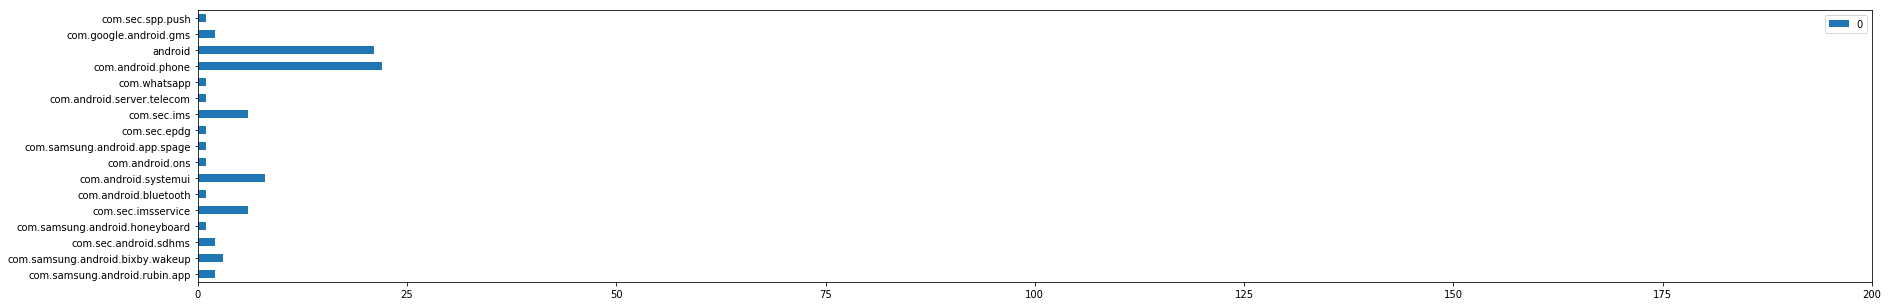

In [112]:
lines = lp.log_sections['DUMP OF SERVICE telephony.registry']
callingPackages = grep(lines,['callingPackage'], 1, show=False)

callingPackages_dict = dict()
for callingPackage in callingPackages:
    current_data = callingPackage.split(' ')[0][16:]
    callingPackages_dict[current_data] = callingPackages_dict.get(current_data, 0) + 1

df = pd.DataFrame.from_dict(callingPackages_dict, orient='index')
df.plot(kind='barh', figsize=(30,5), xlim=(0,200))
plt.show()

In [121]:
rawdata = dict()
for line in net_lines:
    curdata = orderbyeq(line)
    for key in curdata.keys():
        if key not in rawdata:
            rawdata[key] = list()
        if curdata[key] > 50000:
            print(line)
        rawdata[key].append(curdata[key])

df = DataframeFromDictSortByCount(rawdata)
df_dis = df.fillna('-')
pd.set_option('display.max_columns',500)
display(df_dis)

/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  after removing the cwd from sys.path.


0      1     2      3   \
com.nbt.moves                                       8      1    26     20   
com.google.android.gms                              1      1     1      2   
1000                                                1      1     1      1   
com.sds.mysinglesquare                              1      6     1      4   
com.kakao.talk                                      3      1     1      1   
com.skplanet.ocb.locker                             1      1     1      1   
com.instagram.android                              16      3     1      1   
com.imbc.mini                                      23     20   485     54   
com.facebook.katana                                27      4     1      1   
com.sweettracker.smartparcel                        1      1   244   1172   
com.sec.android.app.sbrowser                      124      8    39      4   
com.skmc.okcashbag.home_google                      1      1     1      1   
com.towneers.www                                  412    196     7    189   
com.sds.mms.ui                                      4      1     2      1   
com.ebay.kr.auction                                 1      1     1      1   
com.android.vending                               416   2001   652    552   
com.Mobile.JDSports                                 1  13724  8373   7857   
com.marriott.mrt                                    1      6    16      3   
com.aboutjsp.thedaybefore                           1      1     2      1   
com.watch.vod.phone.vn100                          12   3197   648    827   
kr.co.quicket                                      29     25     6     24   
com.samsung.android.oneconnect                      1      2    61     38   
net.eduwill.study                                   1      1     1      1   
com.mgoogle.android.gms                             1      1     1      1   
com.swallaby.walkon                                 1      1     1      1   
com.microsoft.appmanager                            1      1    31      7   
com.ahnlab.v3mobileplus                             3      8     5      2   
com.skt.skaf.A000Z00040                             2      2     1      2   
com.samsung.accessory                               2      1     1  35449   
GPS                                                 1      1     1      1   
com.samsung.android.scloud                          2      1     1      1   
com.android.chrome                                  1      1     5      1   
com.samsungpop.android.mpop                        15     59    17    303   
com.skt.skaf.OA00026910                             1      1    11     15   
com.nhn.android.navercafe                          26     60   252      1   
com.samsung.hrnoti                                  1      1     1      1   
com.miraeasset.trade                              627    296    79      2   
2919                                              619   4718  5725   1528   
com.coupang.mobile                                 92     88   125    130   
com.nhn.android.band                                1      1     1      1   
com.sec.android.app.shealth                         1      2     1      3   
com.skt.skaf.OA00018282                             1      1     1      1   
com.google.android.googlequicksearchbox             1      1     1      1   
com.elevenst                                       99     24     8     17   
com.psdipcam1.ipcam                                 1     55    12     34   
com.tuck.hellomarket                              103     13     3      3   
com.samsung.android.samsungpass                     1      1     1      -   
com.iloen.melon                                     1      1     1      -   
com.vanced.android.youtube                          1     14     1      -   
com.samsung.android.rubin.app                       3     44    26      -   
com.samsung.familynetmall                         376   2870  3482      -   
com.sec.android.daemonapp                      

In [122]:
PlotFromDict(rawdata, 50000, 'NET information in SSRM', '[NET]')

In [123]:
lines = ssrm.file_lines
net_lines = grep(lines,['COM'], 1)

[COM] [(SIOP Level)(AP_temp,PST_temp,BAT_temp,USB_temp,CHG_temp,PA_temp,CP_temp,MMW_temp,WIFI_temp,CF_temp,BLK_temp,SUBBAT_temp,LRP_temp,LRP2_temp<LRP2_type>,(BAT_level,Inow_avg,Isys_avg)(RSSI[common,Gsm/Cdma/Lte],Radio_data,Radio_RxTput,Radio_TxTput,Wifi_data,Wifi_signal_Level,Wifi_RxTput,Wif_TxTput)(Brightness,FPS,HRR),(Vidoe_Audio,AudioDevice:Volume)]
2020-12-29 23:48:33 [COM] [( 0-> 0)(37,37,36,34,39,38,38,--,37,37, 0, 0,35,36:WIFIF)( 83, 3279,   0)([ -89_1, 4G13],R:   9K,Rx:  0.0Mbps,Tx:  0.0Mbps,W:   0K,Lv-2,Rx:  0.0Mbps,Tx:  0.0Mbps)(BL: 54,FPS: 1.1, 60 1)(__,SPK: 0)][Core:0-7][CF|   0/2600,GF| 130/ 676,OL:2184000,CG: -1,WT: -1,AD: 5,LB: -1,SB:-1,LH:-1,HT: -1,CL: 4,DC:1,BG:100,CO: 1,DR: 1,WP: -1] [LRPs => LRF:357 LRB:359 AP2:364 CHG2:363 DC2:364 WIFI2:365 RMMW2:363 LMMW2:346 RCV2:362 SPK2:343] ScreenOff LowTput
2020-12-29 23:49:03 [COM] [( 0-> 0)(37,37,36,34,38,37,38,--,37,36, 0, 0,35,36:WIFIF)( 83, 3271,   0)([ -92_1, 4G13],R:   5K,Rx:  0.0Mbps,Tx:  0.0Mbps,W:   0K,Lv-2,Rx:  0.

Text(0,0.5,'Mbps')

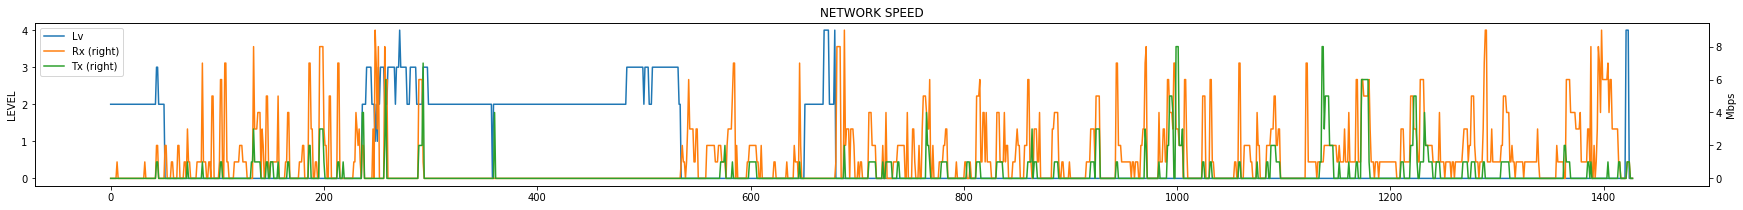

In [124]:
searchers = dict()
searchers['Lv'] = 0
searchers['Rx'] = 1
searchers['Tx'] = 1
network = DictFromPickedUp(net_lines, searchers)

#display(network['Lv'])
df = pd.DataFrame(network)
ax = df['Lv'].plot(figsize=(30,5), legend=True)
ax.set_title('NETWORK SPEED')
ax.set_ylabel('LEVEL')

ax = df['Rx'].plot(secondary_y=True, figsize=(30,3), legend=True)
ax = df['Tx'].plot(secondary_y=True, figsize=(30,3), legend=True)
ax.set_ylabel('Mbps')

In [125]:
lines = lp.log_sections['SERVICE wifi']
tmp = grep(lines,['setWifiEnabled'], 1)

--- Nothing ---


* Netwrok error with NETWORK_VALIDATION_FAILED(This is MAJOR log)<br>
ex) ConnectivityMetricsEvent(2020-08-20 13:28:44.085, netId=604, CELLULAR): NetworkEvent(NETWORK_VALIDATION_FAILED, 0ms)

In [126]:
lines = lp.log_sections['DUMP OF SERVICE connmetrics']
tmp = grep(lines,['FAILED'], 1)

--- Nothing ---


* Wifi error logs(This is minor log)<br>
08-26 17:29:14.405  wifi  2651  2651 E WifiHAL : Failed to execute bssid blacklist request, result = -22<br>
08-26 17:29:14.405  wifi  2651  2651 E WifiHAL : wifi_configure_roaming: Failed to configure blacklist bssids<br>
08-26 17:29:14.405  1000  4456  4638 E WifiVendorHal: configureRoaming(l.2084) failed {.code = ERROR_UNKNOWN, .description = unknown}<br>

In [127]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Failed to execute bssid blacklist request', 'Failed to configure blacklist bssids', 'failed {.code = ERROR_UNKNOWN'], 1)

--- Nothing ---


* Wifi error logs

If there are many APs likes below, those could effect to the current network.

Latest scan results:<br>
    BSSID.............Frequency.......RSSI.......BSS Load Element......Age(sec)...SSID..................................Flags<br>
  10:6f:3f:09:27:63.......2412........-55................null...........23.081....106F3F092763......................[WPA2-PSK-CCMP+TKIP][RSN-PSK-CCMP+TKIP][WPA-PSK-CCMP+TKIP][ESS][WPS]<br>
  bc:96:80:a6:44:e1.......2427........-59................null...........23.081....U+Net44E3.........................[WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS]<br>
  f8:b4:6a:ff:d3:73.......2432........-60................null...........23.081....DIRECT-72-SA SL-J2160W Series.....[WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS][WPS]<br>
  bc:96:80:a6:44:e4.......2427........-60................null...........23.081....U+zone............................[WPA2-EAP-CCMP][RSN-EAP-CCMP][ESS]<br>
  70:5d:cc:58:79:34.......2432........-65................null...........23.081....iptime_seonhui....................[WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS][WPS]<br>
  bc:96:80:a6:44:e0.......2427........-67................null...........23.081......................................[WPA-PSK-TKIP][ESS]<br>
  88:36:6c:8d:14:cc.......2417........-77..........000000127A...........23.081....iptime............................[WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS][WPS]<br>
  b4:a9:4f:4f:d3:5a.......2427........-86..........00000D127A...........23.081....KT_GiGA_2G_Wave2_D356.............[WPA-PSK-CCMP+TKIP][WPA2-PSK-CCMP+TKIP][RSN-PSK-CCMP+TKIP][ESS][WPS]<br>
  18:c5:01:c5:d1:de.......2427........-88................null...........23.081....U+NetD1DC.........................[WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS]<br>
  00:07:89:6b:56:32.......2432........-89................null...........23.081....olleh_WiFi_562F...................[WPA2-PSK-CCMP+TKIP][RSN-PSK-CCMP+TKIP][WPA-PSK-CCMP+TKIP][ESS][WPS]<br>
  86:25:19:2f:a6:11.......2412........-91................null...........23.081....DIRECT-ujC48x Series..............[WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS][WPS]<br>
  88:3c:1c:ed:90:22.......2412........-93................null...........23.081....U+Net9023.........................[WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS]<br>
  f4:d9:fb:20:64:c9.......2412........-93................null...........23.081....KT_WLAN_19E0......................[WPA2-PSK-CCMP+TKIP][RSN-PSK-CCMP+TKIP][WPA-PSK-CCMP+TKIP][ESS]<br>
  54:d1:63:2e:8e:f3.......2412........-96................null...........23.081....t-broad8EED.......................[WPA-PSK-TKIP+CCMP][WPA2-PSK-TKIP+CCMP][RSN-PSK-TKIP+CCMP][ESS][WPS]<br>

In [128]:
lines = lp.log_sections['DUMP OF SERVICE wifiscanner']
tmp = grep(lines,['Latest scan results'], 30)

Latest scan results:
BSSID              Frequency      RSSI           Age(sec)     SSID                                 Flags
08:10:77:93:ad:40       2442        -41              8.103    netis                             [ESS]
0a:ae:d6:c1:ac:ef       2437        -63              8.103    AndroidHotspot1000                [WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS]
08:5d:dd:38:7e:0f       2462        -77              8.103    olleh_WiFi_7E0B                   [WPA-PSK-TKIP+CCMP][WPA2-PSK-TKIP+CCMP][RSN-PSK-TKIP+CCMP][ESS][WPS]
8a:36:6c:ce:23:8c       2412        -84              8.103    iptime                            [WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS][WPS]
08:5d:dd:38:7e:0e       5180        -89              8.103    olleh_GiGA_WiFi_7E0B              [WPA-PSK-TKIP+CCMP][WPA2-PSK-TKIP+CCMP][RSN-PSK-TKIP+CCMP][ESS][WPS]
88:36:6c:ae:23:8c       5745        -91              8.103    iptime5G                          [WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS][WPS]
90:9f:33:23:73:fc       2467        -93

* Some delay related for telecom could be founded, if the count of registration is large number.

09-18 13:58:56.701  1000  4398  4398 W Looper  : Slow system_server main looper dispatch took 3908ms  h=android.telecom.Connection$VideoProvider$VideoProviderHandler c=null m=9

In [129]:
lines = lp.log_sections['DUMP OF SERVICE telephony.registry']
tmp = grep(lines,['registrations'], 1)

registrations: count=87


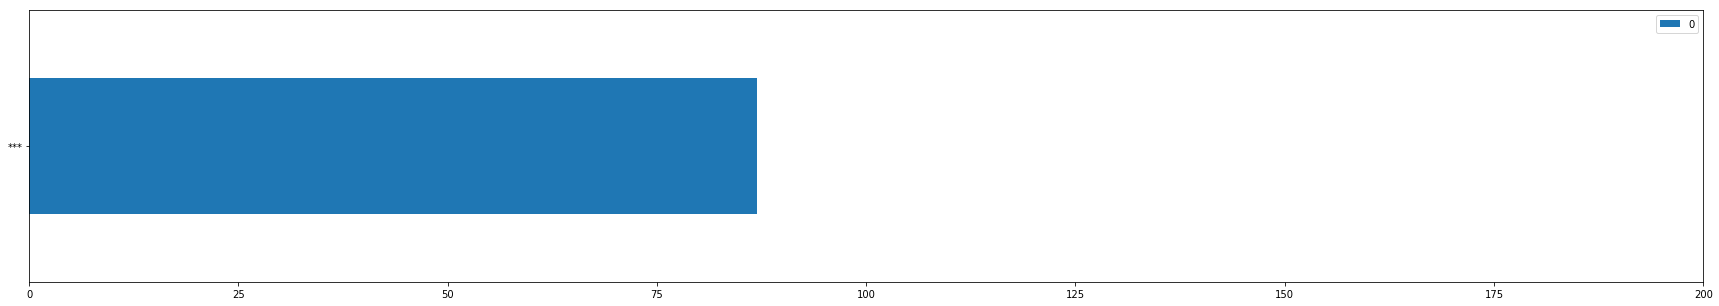

In [130]:
lines = lp.log_sections['DUMP OF SERVICE telephony.registry']
callingPackages = grep(lines,['callingPackage'], 1, show=False)

callingPackages_dict = dict()
for callingPackage in callingPackages:
    current_data = callingPackage.split(' ')[0][16:]
    callingPackages_dict[current_data] = callingPackages_dict.get(current_data, 0) + 1

df = pd.DataFrame.from_dict(callingPackages_dict, orient='index')
df.plot(kind='barh', figsize=(30,5), xlim=(0,200))
plt.show()

* This is reaction time of medem.

19:50:00.000: {netId=618, CELLULAR, dns avg=2048ms max=14381ms err=4.5% tot=44, connect avg=0ms max=1ms err=0.0% tot=44, tcp avg_loss=0.0% total_sent=14092 total_lost=0, tcp rtt=595ms, tcp sent-ack_diff=-4110ms}<br>
19:55:00.000: {netId=618, CELLULAR, dns avg=3259ms max=9457ms err=7.1% tot=14, connect avg=0ms max=3ms err=0.0% tot=224, tcp avg_loss=0.3% total_sent=13517 total_lost=45, tcp rtt=2860ms, tcp sent-ack_diff=-3084ms}

In [131]:
lines = lp.log_sections['DUMP OF SERVICE connmetrics']
network_logs = grep(lines,['dns avg'], 1, show=False)
network_logs = grep(network_logs, ['max=[0-9][0-9][0-9][0-9]ms', 'err=[0-9][0-9].[0-9]%'], 1)

13:04:29.354: {netId=501, CELLULAR, dns avg=0ms max=0ms err=0.0% tot=0, connect avg=0ms max=0ms err=9.1% tot=11, tcp avg_loss=0.0% total_sent=0 total_lost=0, tcp rtt=0ms, tcp sent-ack_diff=0ms}, {netId=605, CELLULAR, dns avg=473ms max=5115ms err=0.0% tot=13, connect avg=0ms max=0ms err=3.1% tot=32, tcp avg_loss=0.0% total_sent=133 total_lost=0, tcp rtt=82ms, tcp sent-ack_diff=36456ms}
13:06:00.000: {netId=605, CELLULAR, dns avg=29ms max=111ms err=22.2% tot=9, connect avg=0ms max=2ms err=0.0% tot=11, tcp avg_loss=0.0% total_sent=329 total_lost=0, tcp rtt=46ms, tcp sent-ack_diff=-176ms}
13:08:00.000: {netId=605, CELLULAR, dns avg=43ms max=182ms err=54.5% tot=11, connect avg=0ms max=1ms err=0.0% tot=12, tcp avg_loss=0.0% total_sent=56 total_lost=0, tcp rtt=99ms, tcp sent-ack_diff=-4773ms}
13:11:00.000: {netId=605, CELLULAR, dns avg=40ms max=95ms err=18.2% tot=11, connect avg=0ms max=0ms err=0.0% tot=18, tcp avg_loss=0.0% total_sent=58674 total_lost=0, tcp rtt=53ms, tcp sent-ack_diff=-150m

# <span style="color:blue">Proc stats</span>

In [132]:
lines = lp.log_sections['SERVICE procstats']
cur_lines = list()
flag = False
#display(lines)
for line in lines:
    if '*' in line:
        if flag:
            display(cur_lines)
            flag = False
        del cur_lines[:]
        cur_lines = list()
        cur_lines.append(line)
    elif 'over' in line:
        #numbers = re.findall('\d+', line)
        cur_lines.append(line)
        memory = re.findall('GB', line)
        if len(memory) > 0:
            flag = True

['  * com.ahnlab.v3mobileplus / u0a463 / v1864:\n',
 '         TOTAL: 4.7% (420MB-624MB-759MB/289MB-564MB-696MB/0.89GB-746MB-0.89GB over 8)\n',
 '        Imp Fg: 4.7% (420MB-624MB-759MB/289MB-564MB-696MB/0.89GB-746MB-0.89GB over 8)\n',
 '      (Cached): 6.9% (15MB-120MB-151MB/11MB-89MB-141MB/114MB-200MB-254MB over 12)\n']

['  * com.ahnlab.v3mobileplus / u0a463 / v1864:\n',
 '          SOff/Norm/(Cch Emty): 16MB-123MB-145MB/13MB-62MB-115MB/229MB-170MB-229MB over 8\n',
 '                Mod/(Cch Emty): 16MB-99MB-151MB/12MB-86MB-140MB/253MB-197MB-253MB over 3\n',
 '               Crit/(Cch Emty): 146MB-146MB-146MB/75MB-75MB-75MB/184MB-184MB-184MB over 1\n',
 '           SOn/Norm/    Imp Fg: 342MB-588MB-759MB/280MB-535MB-696MB/0.89GB-711MB-0.89GB over 12\n',
 '                    (Cch Emty): 15MB-88MB-151MB/11MB-80MB-141MB/143MB-191MB-254MB over 11\n',
 '                Mod/    Imp Fg: 322MB-328MB-334MB/240MB-245MB-249MB/412MB-416MB-420MB over 2\n',
 '                    (Cch Emty): 127MB-127MB-127MB/110MB-110MB-110MB/232MB-232MB-232MB over 1\n',
 '        Cur time +29s108ms: 18MB-18MB-18MB/14MB-14MB-14MB/108MB-108MB-108MB over 1\n']

['  * com.instagram.android / u0a573 / v264009024:\n',
 '          SOff/Norm/   Service: 27MB-37MB-43MB/732KB-2.4MB-3.9MB/106MB-103MB-106MB over 3\n',
 '                    (Cch Emty): 20MB-30MB-45MB/580KB-16MB-43MB/129MB-111MB-138MB over 25\n',
 '                Mod/   Service: 27MB-27MB-27MB/3.6MB-3.6MB-3.6MB/103MB-103MB-103MB over 1\n',
 '                    (Cch Emty): 24MB-36MB-46MB/1.5MB-16MB-44MB/99MB-106MB-132MB over 5\n',
 '                Low/(Cch Emty): 19MB-19MB-19MB/2.0MB-2.0MB-2.0MB/97MB-97MB-97MB over 1\n',
 '               Crit/   Service: 26MB-26MB-26MB/21MB-21MB-21MB/120MB-120MB-120MB over 1\n',
 '           SOn/Norm/   Service: 23MB-32MB-45MB/5.7MB-18MB-38MB/121MB-119MB-137MB over 21\n',
 '                    (Cch Emty): 19MB-29MB-47MB/8.0KB-12MB-44MB/88MB-105MB-140MB over 61\n',
 '                Mod/   Service: 22MB-30MB-44MB/436KB-16MB-37MB/121MB-113MB-139MB over 6\n',
 '                    (Cch Emty): 19MB-28MB-46MB/4.0KB-8.6MB-42MB/108MB-99MB-138MB over 27\n',
 

['  * com.instagram.android / u0a573 / v264009024:\n',
 '         TOTAL: 2.0% (253MB-431MB-0.92GB/216MB-373MB-698MB/402MB-514MB-823MB over 13)\n',
 '           Top: 1.9% (253MB-431MB-0.92GB/216MB-373MB-698MB/402MB-514MB-823MB over 13)\n',
 '      (Cached): 67% (46MB-125MB-468MB/5.5MB-50MB-228MB/119MB-163MB-364MB over 150)\n']

['  * com.ahnlab.v3mobileplus / u0a463 / v1864:\n',
 '         TOTAL: 1.2% (322MB-551MB-759MB/240MB-493MB-696MB/412MB-669MB-0.89GB over 14)\n',
 '        Imp Fg: 1.1% (322MB-551MB-759MB/240MB-493MB-696MB/412MB-669MB-0.89GB over 14)\n',
 '      (Cached): 2.0% (15MB-105MB-151MB/11MB-76MB-141MB/143MB-186MB-254MB over 24)\n']

In [133]:
lines = lp.log_sections['SERVICE procstats']
cur_lines = list()
flag = False
#display(lines)
for line in lines:
    if '*' in line:
        if flag:
            display(cur_lines)
            flag = False
        del cur_lines[:]
        cur_lines = list()
        cur_lines.append(line)
    elif 'over' in line:
        #numbers = re.findall('\d+', line)
        cur_lines.append(line)
        memory = re.findall('[5-9][0-9][0-9]MB', line)
        if len(memory) > 0:
            flag = True

['  * system / 1000 / v30:\n',
 '         TOTAL: 100% (343MB-425MB-534MB/229MB-317MB-434MB/367MB-465MB-588MB over 10)\n',
 '    Persistent: 100% (343MB-425MB-534MB/229MB-317MB-434MB/367MB-465MB-588MB over 10)\n']

['  * com.samsung.android.app.ledbackcover / u0a99 / v132700000:\n',
 '         TOTAL: 100% (212MB-316MB-585MB/2.6MB-143MB-464MB/92MB-265MB-652MB over 16)\n',
 '        Imp Fg: 100% (212MB-316MB-585MB/2.6MB-143MB-464MB/92MB-265MB-652MB over 16)\n']

['  * com.ahnlab.v3mobileplus / u0a463 / v1864:\n',
 '         TOTAL: 3.0% (334MB-480MB-701MB/249MB-430MB-679MB/420MB-596MB-836MB over 5)\n',
 '        Imp Fg: 3.0% (334MB-480MB-701MB/249MB-430MB-679MB/420MB-596MB-836MB over 5)\n',
 '      (Cached): 3.2% (127MB-130MB-132MB/110MB-119MB-123MB/232MB-244MB-251MB over 3)\n']

['  * com.instagram.android / u0a573 / v264009024:\n',
 '         TOTAL: 0.90% (259MB-296MB-364MB/247MB-279MB-336MB/402MB-437MB-500MB over 3)\n',
 '           Top: 0.88% (259MB-296MB-364MB/247MB-279MB-336MB/402MB-437MB-500MB over 3)\n',
 '      (Cached): 98% (61MB-81MB-125MB/14MB-40MB-69MB/134MB-158MB-225MB over 14)\n']

['  * com.skt.prod.dialer / u0a297 / v9819:\n',
 '         TOTAL: 0.68% (400MB-420MB-439MB/297MB-328MB-360MB/445MB-477MB-510MB over 2)\n',
 '           Top: 0.56% (439MB-439MB-439MB/360MB-360MB-360MB/510MB-510MB-510MB over 1)\n',
 '        Imp Fg: 0.11% (400MB-400MB-400MB/297MB-297MB-297MB/445MB-445MB-445MB over 1)\n',
 '      (Cached): 13% (227MB-240MB-253MB/107MB-184MB-238MB/237MB-315MB-370MB over 6)\n']

['  * system / 1000 / v30:\n',
 '         TOTAL: 100% (377MB-405MB-478MB/265MB-293MB-378MB/401MB-419MB-501MB over 29)\n',
 '    Persistent: 100% (377MB-405MB-478MB/265MB-293MB-378MB/401MB-419MB-501MB over 29)\n']

['  * com.samsung.android.app.ledbackcover / u0a99 / v132700000:\n',
 '         TOTAL: 100% (80MB-271MB-550MB/744KB-134MB-543MB/84MB-230MB-674MB over 43)\n',
 '        Imp Fg: 99% (80MB-271MB-550MB/744KB-134MB-543MB/84MB-230MB-674MB over 43)\n']

['  * kr.co.quicket / u0a394 / v150070407:\n',
 '         TOTAL: 6.0% (228MB-321MB-358MB/210MB-279MB-307MB/366MB-478MB-517MB over 6)\n',
 '           Top: 6.0% (228MB-321MB-358MB/210MB-279MB-307MB/366MB-478MB-517MB over 6)\n',
 '    (Last Act): 0.32% (204MB-204MB-204MB/132MB-132MB-132MB/322MB-322MB-322MB over 1)\n',
 '      (Cached): 11% (119MB-128MB-141MB/12MB-41MB-96MB/132MB-187MB-264MB over 3)\n']

['  * com.facebook.katana / u0a375 / v263723548:\n',
 '         TOTAL: 5.9% (69MB-299MB-568MB/40MB-262MB-497MB/154MB-408MB-692MB over 11)\n',
 '           Top: 3.5% (274MB-456MB-568MB/231MB-400MB-497MB/389MB-575MB-692MB over 6)\n',
 '        Imp Fg: 1.6% (69MB-129MB-190MB/40MB-109MB-177MB/154MB-219MB-285MB over 2)\n',
 '        Imp Bg: 0.38% (98MB-110MB-122MB/95MB-105MB-115MB/198MB-212MB-227MB over 2)\n',
 '      Receiver: 0.13% (77MB-77MB-77MB/55MB-55MB-55MB/174MB-174MB-174MB over 1)\n',
 '    (Last Act): 19% (60MB-104MB-135MB/31MB-89MB-127MB/129MB-200MB-242MB over 14)\n',
 '      (Cached): 59% (58MB-98MB-165MB/11MB-76MB-146MB/132MB-187MB-281MB over 48)\n']

['  * com.ahnlab.v3mobileplus / u0a463 / v1864:\n',
 '         TOTAL: 4.7% (420MB-624MB-759MB/289MB-564MB-696MB/0.89GB-746MB-0.89GB over 8)\n',
 '        Imp Fg: 4.7% (420MB-624MB-759MB/289MB-564MB-696MB/0.89GB-746MB-0.89GB over 8)\n',
 '      (Cached): 6.9% (15MB-120MB-151MB/11MB-89MB-141MB/114MB-200MB-254MB over 12)\n']

['  * com.towneers.www / u0a590 / v60702:\n',
 '         TOTAL: 2.7% (236MB-329MB-400MB/226MB-315MB-379MB/362MB-453MB-519MB over 3)\n',
 '           Top: 2.7% (236MB-329MB-400MB/226MB-315MB-379MB/362MB-453MB-519MB over 3)\n',
 '    (Last Act): 3.6% (84MB-98MB-105MB/16MB-60MB-82MB/147MB-198MB-225MB over 3)\n',
 '      (Cached): 46% (33MB-66MB-77MB/5.7MB-23MB-47MB/99MB-122MB-151MB over 18)\n']

['  * com.skmc.okcashbag.home_google / u0a320 / v156:\n',
 '         TOTAL: 0.71% (412MB-412MB-412MB/361MB-361MB-361MB/563MB-563MB-563MB over 1)\n',
 '           Top: 0.13% (412MB-412MB-412MB/361MB-361MB-361MB/563MB-563MB-563MB over 1)\n',
 '      (Cached): 58% (76MB-110MB-184MB/45MB-79MB-124MB/203MB-254MB-321MB over 53)\n']

['  * kr.co.ssg / u0a405 / v29001:\n',
 '         TOTAL: 0.42% (319MB-335MB-352MB/291MB-307MB-323MB/471MB-487MB-503MB over 2)\n',
 '           Top: 0.40% (319MB-335MB-352MB/291MB-307MB-323MB/471MB-487MB-503MB over 2)\n',
 '      (Cached): 0.32% (49MB-49MB-49MB/34MB-34MB-34MB/153MB-153MB-153MB over 1)\n']

['  * com.skmc.okcashbag.home_google / u0a320 / v156:\n',
 '          SOff/Norm/    Imp Fg: 124MB-197MB-261MB/56MB-96MB-124MB/295MB-249MB-303MB over 8\n',
 '                     (Cch Act): 167MB-167MB-167MB/77MB-77MB-77MB/185MB-185MB-185MB over 1\n',
 '                    (Cch Emty): 89MB-90MB-91MB/51MB-51MB-51MB/227MB-225MB-227MB over 2\n',
 '                Mod/    Imp Fg: 124MB-124MB-124MB/56MB-56MB-56MB/139MB-139MB-139MB over 1\n',
 '                     (Cch Act): 169MB-169MB-169MB/73MB-73MB-73MB/178MB-178MB-178MB over 1\n',
 '                    (Cch Emty): 67MB-74MB-81MB/37MB-41MB-45MB/207MB-191MB-207MB over 2\n',
 '               Crit/    Imp Fg: 127MB-127MB-127MB/35MB-35MB-35MB/117MB-117MB-117MB over 1\n',
 '           SOn/Norm/       Top: 345MB-345MB-345MB/311MB-311MB-311MB/514MB-514MB-514MB over 1\n',
 '                        Imp Fg: 120MB-162MB-205MB/48MB-98MB-147MB/346MB-256MB-346MB over 2\n',
 '                     (Cch Act): 123MB-167MB-214MB/30MB-87MB-137MB/191MB-259MB

['  * com.nbt.moves / u0a565 / v37796:\n',
 '          SOff/Norm/    Imp Fg: 104MB-158MB-221MB/30MB-84MB-140MB/297MB-238MB-321MB over 20\n',
 '                Mod/    Imp Fg: 126MB-159MB-218MB/36MB-71MB-117MB/256MB-209MB-284MB over 6\n',
 '                Low/    Imp Fg: 150MB-150MB-150MB/62MB-62MB-62MB/210MB-210MB-210MB over 1\n',
 '           SOn/Norm/       Top: 232MB-292MB-342MB/160MB-220MB-264MB/301MB-356MB-392MB over 3\n',
 '                        Imp Fg: 88MB-152MB-176MB/29MB-107MB-155MB/299MB-263MB-314MB over 28\n',
 '                Mod/       Top: 412MB-412MB-412MB/368MB-368MB-368MB/525MB-525MB-525MB over 1\n',
 '                        Imp Fg: 87MB-141MB-164MB/33MB-88MB-142MB/173MB-245MB-317MB over 7\n',
 '        Cur time +1m45s386ms (running): 88MB-151MB-176MB/29MB-90MB-122MB/279MB-238MB-279MB over 5\n']

['  * android / 1000 / v30:\n',
 '          SOff/Norm/Persistent: 387MB-412MB-434MB/269MB-288MB-315MB/411MB-397MB-429MB over 7\n',
 '                Mod/Persistent: 394MB-414MB-443MB/266MB-293MB-322MB/402MB-402MB-438MB over 4\n',
 '               Crit/Persistent: 591MB-591MB-591MB/468MB-468MB-468MB/597MB-597MB-597MB over 1\n',
 '           SOn/Norm/Persistent: 389MB-422MB-469MB/273MB-305MB-356MB/388MB-419MB-463MB over 6\n',
 '                Mod/Persistent: 377MB-402MB-457MB/248MB-284MB-330MB/452MB-399MB-452MB over 6\n',
 '                Low/Persistent: 364MB-364MB-364MB/255MB-255MB-255MB/369MB-369MB-369MB over 1\n',
 '        Cur time +10h12m41s939ms (running): 265MB-411MB-591MB/213MB-299MB-468MB/377MB-428MB-661MB over 74\n',
 '          SOff/Norm/   Service: 5.6MB-6.3MB-7.8MB/340KB-1.8MB-4.8MB/58MB-78MB-85MB over 12\n',
 '                Mod/   Service: 5.7MB-5.9MB-6.3MB/340KB-386KB-548KB/58MB-72MB-81MB over 5\n',
 '               Crit/   Service: 6.1MB-6.1MB-6.1MB/404KB-404KB-404KB

['  * com.skt.prod.dialer / u0a297 / v9819:\n',
 '          SOff/Norm/   Service: 299MB-305MB-318MB/95MB-106MB-124MB/247MB-211MB-247MB over 4\n',
 '                    (Cch Emty): 240MB-241MB-242MB/181MB-196MB-211MB/324MB-315MB-324MB over 2\n',
 '                Mod/   Service: 299MB-309MB-320MB/95MB-106MB-133MB/259MB-216MB-259MB over 5\n',
 '           SOn/Norm/       Top: 285MB-371MB-487MB/164MB-254MB-375MB/560MB-401MB-560MB over 3\n',
 '                       Service: 282MB-312MB-351MB/95MB-144MB-214MB/382MB-275MB-382MB over 6\n',
 '                    (Cch Emty): 213MB-240MB-251MB/121MB-210MB-246MB/362MB-327MB-362MB over 4\n',
 '                Mod/       Top: 382MB-440MB-499MB/254MB-337MB-421MB/607MB-517MB-607MB over 2\n',
 '                       Service: 299MB-300MB-300MB/92MB-105MB-118MB/189MB-204MB-219MB over 2\n',
 '                    (Cch Emty): 199MB-201MB-203MB/62MB-65MB-68MB/173MB-176MB-178MB over 2\n',
 '                Low/(Cch Emty): 201MB-201MB-201MB/58MB-58MB-58MB/1

['  * com.android.providers.settings / 1000 / v30:\n',
 '          SOff/Norm/Persistent: 387MB-412MB-434MB/269MB-288MB-315MB/411MB-397MB-429MB over 7\n',
 '                Mod/Persistent: 394MB-414MB-443MB/266MB-293MB-322MB/402MB-402MB-438MB over 4\n',
 '               Crit/Persistent: 591MB-591MB-591MB/468MB-468MB-468MB/597MB-597MB-597MB over 1\n',
 '           SOn/Norm/Persistent: 389MB-422MB-469MB/273MB-305MB-356MB/388MB-419MB-463MB over 6\n',
 '                Mod/Persistent: 377MB-402MB-457MB/248MB-284MB-330MB/452MB-399MB-452MB over 6\n',
 '                Low/Persistent: 364MB-364MB-364MB/255MB-255MB-255MB/369MB-369MB-369MB over 1\n',
 '        Cur time +10h12m41s616ms (running): 265MB-411MB-591MB/213MB-299MB-468MB/377MB-428MB-661MB over 74\n',
 '        <- com.samsung.android.localeoverlaymanager/1000 (com.samsung.android.localeoverlaymanager):\n',
 '        <- com.sec.android.cover.ledcover/u0a62 (com.sec.android.cover.ledcover):\n',
 '        <- com.samsung.android.app.ledback

['  * com.android.server.telecom / 1000 / v30:\n',
 '          SOff/Norm/Persistent: 387MB-412MB-434MB/269MB-288MB-315MB/411MB-397MB-429MB over 7\n',
 '                Mod/Persistent: 394MB-414MB-443MB/266MB-293MB-322MB/402MB-402MB-438MB over 4\n',
 '               Crit/Persistent: 591MB-591MB-591MB/468MB-468MB-468MB/597MB-597MB-597MB over 1\n',
 '           SOn/Norm/Persistent: 389MB-422MB-469MB/273MB-305MB-356MB/388MB-419MB-463MB over 6\n',
 '                Mod/Persistent: 377MB-402MB-457MB/248MB-284MB-330MB/452MB-399MB-452MB over 6\n',
 '                Low/Persistent: 364MB-364MB-364MB/255MB-255MB-255MB/369MB-369MB-369MB over 1\n',
 '        Cur time +10h12m41s616ms (running): 265MB-411MB-591MB/213MB-299MB-468MB/377MB-428MB-661MB over 74\n']

['  * com.samsung.android.app.ledbackcover / u0a99 / v132700000:\n',
 '      Process com.samsung.android.app.ledbackcover (unique, 13 entries):\n',
 '          SOff/Norm/    Imp Fg: 208MB-343MB-560MB/4.6MB-250MB-549MB/413MB-339MB-643MB over 12\n',
 '                Mod/    Imp Fg: 211MB-264MB-431MB/3.1MB-138MB-413MB/73MB-218MB-508MB over 6\n',
 '           SOn/Norm/    Imp Fg: 216MB-245MB-340MB/2.8MB-154MB-324MB/318MB-244MB-411MB over 7\n',
 '                Mod/    Imp Fg: 212MB-216MB-221MB/1.5MB-4.5MB-7.0MB/92MB-77MB-92MB over 5\n',
 '                Low/    Imp Fg: 85MB-163MB-240MB/6.5MB-7.6MB-8.6MB/78MB-84MB-89MB over 2\n',
 '        myID=54f7152 mCommonProcess=54f7152 mPackage=com.samsung.android.app.ledbackcover\n',
 '      Service com.samsung.android.app.ledbackcover.service.LCoverIcon:\n',
 '        Process: com.samsung.android.app.ledbackcover\n',
 '      Service com.samsung.android.app.ledbackcover.service.LCoverNLS:\n',
 '        Process: com.samsung.android.app.ledbackcover

['  * com.samsung.android.singletake.service / u0a133 / v210038100:\n',
 '          SOff/Norm/(Cch Emty): 112MB-112MB-112MB/13MB-13MB-13MB/112MB-112MB-112MB over 1\n',
 '                Mod/(Cch Emty): 110MB-110MB-110MB/11MB-11MB-11MB/109MB-109MB-109MB over 1\n',
 '                Low/(Cch Emty): 128MB-128MB-128MB/54MB-54MB-54MB/161MB-161MB-161MB over 1\n',
 '               Crit/(Cch Emty): 112MB-112MB-112MB/26MB-26MB-26MB/133MB-133MB-133MB over 1\n',
 '           SOn/Norm/    Imp Fg: 324MB-428MB-545MB/239MB-341MB-484MB/419MB-455MB-597MB over 3\n',
 '                    (Cch Emty): 8.4MB-11MB-14MB/2.5MB-7.1MB-12MB/91MB-86MB-91MB over 2\n',
 '        Cur time +1m12s255ms: 8.4MB-11MB-14MB/2.5MB-7.1MB-12MB/91MB-86MB-91MB over 2\n']

['  * com.samsung.android.gearnplugin / u0a288 / v120122351:\n',
 '          SOff/Norm/    Imp Fg: 72MB-78MB-85MB/36MB-45MB-56MB/135MB-119MB-135MB over 8\n',
 '                Mod/    Imp Fg: 70MB-73MB-78MB/34MB-39MB-43MB/113MB-111MB-116MB over 4\n',
 '                Low/    Imp Fg: 70MB-70MB-70MB/35MB-35MB-35MB/107MB-107MB-107MB over 1\n',
 '           SOn/Norm/    Imp Fg: 71MB-75MB-77MB/28MB-38MB-41MB/124MB-106MB-124MB over 5\n',
 '                Mod/    Imp Fg: 72MB-78MB-85MB/17MB-37MB-47MB/126MB-115MB-129MB over 5\n',
 '                Low/    Imp Fg: 73MB-74MB-74MB/38MB-41MB-44MB/118MB-114MB-118MB over 2\n',
 '        Cur time +10h12m36s276ms (running): 56MB-79MB-359MB/6.5MB-40MB-285MB/194MB-133MB-534MB over 78\n',
 '          SOff/Norm/    Imp Fg: 12MB-12MB-12MB/368KB-386KB-404KB/53MB-48MB-53MB over 7\n',
 '                Mod/    Imp Fg: 12MB-12MB-12MB/368KB-387KB-404KB/53MB-49MB-53MB over 5\n',
 '               Crit/    Imp Fg: 12MB-12MB-12MB/368KB-368KB-368KB/40MB-40MB-40MB 

['  * com.android.location.fused / 1000 / v30:\n',
 '          SOff/Norm/Persistent: 387MB-412MB-434MB/269MB-288MB-315MB/411MB-397MB-429MB over 7\n',
 '                Mod/Persistent: 394MB-414MB-443MB/266MB-293MB-322MB/402MB-402MB-438MB over 4\n',
 '               Crit/Persistent: 591MB-591MB-591MB/468MB-468MB-468MB/597MB-597MB-597MB over 1\n',
 '           SOn/Norm/Persistent: 389MB-422MB-469MB/273MB-305MB-356MB/388MB-419MB-463MB over 6\n',
 '                Mod/Persistent: 377MB-402MB-457MB/248MB-284MB-330MB/452MB-399MB-452MB over 6\n',
 '                Low/Persistent: 364MB-364MB-364MB/255MB-255MB-255MB/369MB-369MB-369MB over 1\n',
 '        Cur time +10h12m37s582ms (running): 265MB-411MB-591MB/213MB-299MB-468MB/377MB-428MB-661MB over 74\n']

['  * kr.co.quicket / u0a394 / v150070407:\n',
 '          SOff/Norm/ (Cch Act): 96MB-96MB-96MB/46MB-46MB-46MB/155MB-155MB-155MB over 1\n',
 '                Mod/ (Cch Act): 95MB-127MB-149MB/39MB-53MB-62MB/152MB-163MB-181MB over 5\n',
 '           SOn/Norm/       Top: 252MB-298MB-349MB/219MB-258MB-301MB/491MB-436MB-491MB over 3\n',
 '                    (Last Act): 156MB-156MB-156MB/79MB-79MB-79MB/262MB-262MB-262MB over 1\n',
 '                Mod/       Top: 212MB-212MB-212MB/185MB-185MB-185MB/370MB-370MB-370MB over 1\n',
 '               Crit/       Top: 364MB-364MB-364MB/336MB-336MB-336MB/505MB-505MB-505MB over 1\n',
 '        Cur time +26s375ms: 212MB-232MB-252MB/185MB-202MB-219MB/370MB-396MB-422MB over 2\n']

['  * system / 1000 (8 entries):\n',
 '          SOff/Norm/Persistent: 387MB-412MB-434MB/269MB-288MB-315MB/411MB-397MB-429MB over 7\n',
 '                Mod/Persistent: 394MB-414MB-443MB/266MB-293MB-322MB/402MB-402MB-438MB over 4\n',
 '               Crit/Persistent: 591MB-591MB-591MB/468MB-468MB-468MB/597MB-597MB-597MB over 1\n',
 '           SOn/Norm/Persistent: 389MB-422MB-469MB/273MB-305MB-356MB/388MB-419MB-463MB over 6\n',
 '                Mod/Persistent: 377MB-402MB-457MB/248MB-284MB-330MB/452MB-399MB-452MB over 6\n',
 '                Low/Persistent: 364MB-364MB-364MB/255MB-255MB-255MB/369MB-369MB-369MB over 1\n',
 '        Cur time +10h12m41s939ms (running): 265MB-411MB-591MB/213MB-299MB-468MB/377MB-428MB-661MB over 74\n']

['  * system / 1000 / v30:\n',
 '         TOTAL: 100% (364MB-417MB-591MB/248MB-298MB-468MB/369MB-410MB-597MB over 25)\n',
 '    Persistent: 100% (364MB-417MB-591MB/248MB-298MB-468MB/369MB-410MB-597MB over 25)\n']

['  * com.samsung.android.app.ledbackcover / u0a99 / v132700000:\n',
 '         TOTAL: 100% (85MB-276MB-560MB/1.5MB-155MB-549MB/73MB-238MB-643MB over 32)\n',
 '        Imp Fg: 94% (85MB-276MB-560MB/1.5MB-155MB-549MB/73MB-238MB-643MB over 32)\n']

['  * com.nbt.moves / u0a565 / v37796:\n',
 '         TOTAL: 100% (87MB-163MB-412MB/29MB-103MB-368MB/173MB-256MB-525MB over 66)\n',
 '           Top: 3.4% (232MB-322MB-412MB/160MB-257MB-368MB/301MB-398MB-525MB over 4)\n',
 '        Imp Fg: 96% (87MB-153MB-221MB/29MB-93MB-155MB/173MB-247MB-321MB over 62)\n']

['  * com.skt.prod.dialer / u0a297 / v9819:\n',
 '         TOTAL: 64% (282MB-329MB-499MB/92MB-158MB-421MB/189MB-283MB-607MB over 22)\n',
 '           Top: 2.2% (285MB-399MB-499MB/164MB-288MB-421MB/560MB-448MB-607MB over 5)\n',
 '       Service: 62% (282MB-308MB-351MB/92MB-119MB-214MB/189MB-234MB-382MB over 17)\n',
 '      (Cached): 8.9% (199MB-227MB-251MB/58MB-158MB-246MB/158MB-272MB-362MB over 9)\n']

['  * com.skmc.okcashbag.home_google / u0a320 / v156:\n',
 '         TOTAL: 40% (120MB-190MB-345MB/35MB-106MB-311MB/117MB-254MB-514MB over 15)\n',
 '           Top: 0.69% (345MB-345MB-345MB/311MB-311MB-311MB/514MB-514MB-514MB over 1)\n',
 '        Imp Fg: 39% (120MB-179MB-261MB/35MB-91MB-167MB/117MB-236MB-360MB over 14)\n',
 '      (Cached): 42% (67MB-133MB-214MB/30MB-72MB-137MB/178MB-233MB-346MB over 20)\n']

['  * kr.co.quicket / u0a394 / v150070407:\n',
 '         TOTAL: 3.5% (212MB-294MB-364MB/185MB-259MB-336MB/370MB-436MB-505MB over 5)\n',
 '           Top: 3.5% (212MB-294MB-364MB/185MB-259MB-336MB/370MB-436MB-505MB over 5)\n',
 '    (Last Act): 1.6% (156MB-156MB-156MB/79MB-79MB-79MB/262MB-262MB-262MB over 1)\n',
 '      (Cached): 30% (95MB-122MB-149MB/39MB-52MB-62MB/152MB-162MB-181MB over 6)\n']

['  * com.samsung.android.singletake.service / u0a133 / v210038100:\n',
 '         TOTAL: 0.71% (324MB-428MB-545MB/239MB-341MB-484MB/419MB-455MB-597MB over 3)\n',
 '        Imp Fg: 0.69% (324MB-428MB-545MB/239MB-341MB-484MB/419MB-455MB-597MB over 3)\n',
 '      (Cached): 12% (8.4MB-81MB-128MB/2.5MB-20MB-54MB/91MB-115MB-161MB over 6)\n']

['  * com.musinsa.soldout / u0a444 / v34:\n',
 '          SOff/Norm/ (Cch Act): 90MB-90MB-90MB/7.5MB-7.5MB-7.5MB/118MB-118MB-118MB over 1\n',
 '           SOn/Norm/       Top: 498MB-518MB-537MB/483MB-501MB-519MB/614MB-632MB-650MB over 2\n',
 '                     (Cch Act): 117MB-119MB-119MB/88MB-93MB-99MB/231MB-225MB-231MB over 3\n',
 '                Mod/ (Cch Act): 90MB-94MB-107MB/7.4MB-20MB-75MB/207MB-136MB-207MB over 6\n']

['  * com.tuck.hellomarket / u0a580 / v30011494:\n',
 '           SOn/Norm/       Top: 312MB-362MB-452MB/291MB-338MB-429MB/490MB-542MB-633MB over 5\n',
 '                     (Cch Act): 198MB-198MB-199MB/161MB-162MB-162MB/368MB-368MB-368MB over 2\n',
 '                Mod/ (Cch Act): 166MB-173MB-192MB/60MB-85MB-145MB/350MB-245MB-350MB over 5\n']

['  * kr.co.samsungcard.mpocket / u0a618 / v42301:\n',
 '           SOn/Norm/       Top: 464MB-482MB-501MB/436MB-449MB-462MB/617MB-640MB-664MB over 2\n',
 '                    (Cch Emty): 39MB-39MB-39MB/37MB-37MB-37MB/129MB-129MB-129MB over 2\n']

['  * com.samsung.familynetmall / u0a576 / v123:\n',
 '          SOff/Norm/ (Cch Act): 133MB-138MB-143MB/33MB-40MB-52MB/152MB-144MB-152MB over 4\n',
 '                Mod/(Last Act): 153MB-153MB-153MB/43MB-43MB-43MB/183MB-183MB-183MB over 1\n',
 '                     (Cch Act): 142MB-142MB-142MB/33MB-33MB-33MB/139MB-139MB-139MB over 1\n',
 '           SOn/Norm/       Top: 239MB-289MB-441MB/185MB-242MB-357MB/578MB-413MB-578MB over 5\n',
 '                    (Last Act): 134MB-143MB-151MB/83MB-92MB-105MB/234MB-256MB-278MB over 3\n',
 '                     (Cch Act): 132MB-139MB-155MB/32MB-43MB-78MB/224MB-153MB-224MB over 10\n',
 '                    (Cch Emty): 7.9MB-9.7MB-11MB/5.1MB-7.5MB-9.8MB/89MB-86MB-89MB over 4\n',
 '                Mod/(Last Act): 149MB-155MB-161MB/43MB-72MB-101MB/257MB-213MB-257MB over 2\n',
 '                     (Cch Act): 132MB-139MB-145MB/33MB-40MB-53MB/164MB-145MB-170MB over 10\n',
 '                Low/       Top: 268MB-306MB-345MB/249MB-268MB-287MB/410MB-4

['  * com.skmc.okcashbag.home_google / u0a320 / v156:\n',
 '          SOff/Norm/    Imp Fg: 124MB-197MB-261MB/56MB-96MB-124MB/295MB-249MB-303MB over 8\n',
 '                     (Cch Act): 159MB-168MB-178MB/55MB-75MB-92MB/185MB-204MB-274MB over 5\n',
 '                    (Cch Emty): 51MB-92MB-136MB/18MB-66MB-121MB/227MB-241MB-280MB over 81\n',
 '                Mod/    Imp Fg: 124MB-124MB-124MB/56MB-56MB-56MB/139MB-139MB-139MB over 1\n',
 '                     (Cch Act): 169MB-169MB-169MB/73MB-73MB-73MB/178MB-178MB-178MB over 1\n',
 '                    (Cch Emty): 66MB-89MB-124MB/34MB-57MB-96MB/207MB-227MB-280MB over 15\n',
 '                Low/(Cch Emty): 49MB-50MB-51MB/13MB-21MB-29MB/161MB-158MB-161MB over 2\n',
 '               Crit/    Imp Fg: 127MB-127MB-127MB/35MB-35MB-35MB/117MB-117MB-117MB over 1\n',
 '                    (Cch Emty): 106MB-106MB-106MB/63MB-63MB-63MB/247MB-247MB-247MB over 1\n',
 '           SOn/Norm/       Top: 258MB-301MB-345MB/228MB-269MB-311MB/514MB-461MB

['  * com.nbt.moves / u0a565 / v37796:\n',
 '          SOff/Norm/    Imp Fg: 81MB-176MB-360MB/17MB-118MB-305MB/297MB-276MB-475MB over 79\n',
 '                Mod/    Imp Fg: 81MB-178MB-282MB/22MB-101MB-195MB/256MB-244MB-346MB over 30\n',
 '                Low/    Imp Fg: 150MB-233MB-307MB/62MB-124MB-163MB/210MB-268MB-303MB over 3\n',
 '               Crit/    Imp Fg: 206MB-223MB-241MB/188MB-191MB-194MB/318MB-325MB-333MB over 2\n',
 '           SOn/Norm/       Top: 201MB-242MB-342MB/132MB-178MB-264MB/301MB-333MB-392MB over 7\n',
 '                        Imp Fg: 73MB-128MB-241MB/13MB-85MB-186MB/299MB-233MB-336MB over 177\n',
 '                Mod/       Top: 199MB-270MB-412MB/146MB-224MB-368MB/525MB-389MB-525MB over 4\n',
 '                        Imp Fg: 76MB-119MB-278MB/14MB-56MB-215MB/173MB-191MB-352MB over 62\n',
 '                Low/       Top: 203MB-203MB-203MB/127MB-127MB-127MB/294MB-294MB-294MB over 1\n',
 '                        Imp Fg: 77MB-120MB-287MB/15MB-57MB-237MB/187MB

['  * com.ahnlab.v3mobileplus / u0a463 / v1864:\n',
 '          SOff/Norm/(Cch Emty): 16MB-123MB-145MB/13MB-62MB-115MB/229MB-170MB-229MB over 8\n',
 '                Mod/(Cch Emty): 16MB-99MB-151MB/12MB-86MB-140MB/253MB-197MB-253MB over 3\n',
 '               Crit/(Cch Emty): 146MB-146MB-146MB/75MB-75MB-75MB/184MB-184MB-184MB over 1\n',
 '           SOn/Norm/    Imp Fg: 342MB-588MB-759MB/280MB-535MB-696MB/0.89GB-711MB-0.89GB over 12\n',
 '                    (Cch Emty): 15MB-88MB-151MB/11MB-80MB-141MB/143MB-191MB-254MB over 11\n',
 '                Mod/    Imp Fg: 322MB-328MB-334MB/240MB-245MB-249MB/412MB-416MB-420MB over 2\n',
 '                    (Cch Emty): 127MB-127MB-127MB/110MB-110MB-110MB/232MB-232MB-232MB over 1\n',
 '        Cur time +29s108ms: 18MB-18MB-18MB/14MB-14MB-14MB/108MB-108MB-108MB over 1\n']

['  * com.sec.android.app.samsungapps / u0a95 / v452107140:\n',
 '          SOff/Norm/ (Cch Act): 132MB-132MB-133MB/73MB-74MB-75MB/253MB-252MB-253MB over 2\n',
 '                    (Cch Emty): 14MB-30MB-105MB/1.0MB-20MB-32MB/114MB-112MB-144MB over 14\n',
 '                Mod/(Cch Emty): 15MB-20MB-27MB/9.8MB-15MB-23MB/94MB-102MB-113MB over 3\n',
 '           SOn/Norm/       Top: 360MB-360MB-360MB/338MB-338MB-338MB/518MB-518MB-518MB over 1\n',
 '                        Imp Fg: 51MB-263MB-369MB/48MB-244MB-343MB/139MB-394MB-522MB over 3\n',
 '                     (Cch Act): 103MB-107MB-113MB/25MB-29MB-36MB/204MB-164MB-204MB over 3\n',
 '                    (Cch Emty): 15MB-22MB-40MB/2.2MB-18MB-38MB/121MB-105MB-121MB over 16\n',
 '                Mod/ (Cch Act): 103MB-106MB-112MB/24MB-27MB-35MB/202MB-157MB-202MB over 5\n',
 '                    (Cch Emty): 17MB-21MB-25MB/9.8MB-15MB-22MB/113MB-106MB-113MB over 5\n',
 '                Low/(Cch Emty): 17MB-17MB-17MB/3.0MB-3.0MB-3.0MB/91MB-91

['  * android / 1000 / v30:\n',
 '          SOff/Norm/Persistent: 265MB-406MB-562MB/213MB-305MB-444MB/411MB-441MB-661MB over 45\n',
 '                Mod/Persistent: 351MB-417MB-524MB/247MB-305MB-409MB/402MB-431MB-580MB over 20\n',
 '                Low/Persistent: 350MB-438MB-540MB/229MB-332MB-433MB/374MB-466MB-575MB over 3\n',
 '               Crit/Persistent: 379MB-485MB-591MB/309MB-388MB-468MB/597MB-516MB-597MB over 2\n',
 '           SOn/Norm/Persistent: 345MB-408MB-579MB/254MB-308MB-485MB/388MB-428MB-606MB over 52\n',
 '                Mod/Persistent: 342MB-412MB-526MB/248MB-312MB-445MB/452MB-433MB-594MB over 49\n',
 '                Low/Persistent: 348MB-387MB-428MB/229MB-288MB-350MB/369MB-405MB-468MB over 10\n',
 '               Crit/Persistent: 374MB-399MB-424MB/262MB-305MB-347MB/465MB-425MB-465MB over 2\n',
 '        Cur time +10h12m42s282ms: 265MB-411MB-591MB/213MB-299MB-468MB/377MB-428MB-661MB over 74\n',
 '          SOff/Norm/   Service: 5.0MB-6.1MB-9.1MB/64KB-1.1MB-5.1MB/

['  * com.instagram.android / u0a573 / v264009024:\n',
 '          SOff/Norm/   Service: 27MB-37MB-43MB/732KB-2.4MB-3.9MB/106MB-103MB-106MB over 3\n',
 '                    (Cch Emty): 20MB-30MB-45MB/580KB-16MB-43MB/129MB-111MB-138MB over 25\n',
 '                Mod/   Service: 27MB-27MB-27MB/3.6MB-3.6MB-3.6MB/103MB-103MB-103MB over 1\n',
 '                    (Cch Emty): 24MB-36MB-46MB/1.5MB-16MB-44MB/99MB-106MB-132MB over 5\n',
 '                Low/(Cch Emty): 19MB-19MB-19MB/2.0MB-2.0MB-2.0MB/97MB-97MB-97MB over 1\n',
 '               Crit/   Service: 26MB-26MB-26MB/21MB-21MB-21MB/120MB-120MB-120MB over 1\n',
 '           SOn/Norm/   Service: 23MB-32MB-45MB/5.7MB-18MB-38MB/121MB-119MB-137MB over 21\n',
 '                    (Cch Emty): 19MB-29MB-47MB/8.0KB-12MB-44MB/88MB-105MB-140MB over 61\n',
 '                Mod/   Service: 22MB-30MB-44MB/436KB-16MB-37MB/121MB-113MB-139MB over 6\n',
 '                    (Cch Emty): 19MB-28MB-46MB/4.0KB-8.6MB-42MB/108MB-99MB-138MB over 27\n',
 

['  * com.skt.prod.dialer / u0a297 / v9819:\n',
 '          SOff/Norm/   Service: 250MB-287MB-318MB/75MB-89MB-126MB/247MB-191MB-274MB over 18\n',
 '                    (Cch Emty): 208MB-234MB-253MB/119MB-189MB-238MB/324MB-312MB-370MB over 11\n',
 '                Mod/   Service: 261MB-294MB-320MB/74MB-90MB-133MB/259MB-189MB-259MB over 13\n',
 '                    (Cch Emty): 197MB-213MB-234MB/82MB-128MB-219MB/261MB-238MB-338MB over 4\n',
 '                Low/   Service: 288MB-288MB-288MB/105MB-105MB-105MB/243MB-243MB-243MB over 1\n',
 '           SOn/Norm/       Top: 285MB-401MB-487MB/139MB-285MB-397MB/560MB-427MB-560MB over 14\n',
 '                        Imp Fg: 400MB-400MB-400MB/297MB-297MB-297MB/445MB-445MB-445MB over 1\n',
 '                        Imp Bg: 309MB-309MB-309MB/160MB-160MB-160MB/301MB-301MB-301MB over 1\n',
 '                       Service: 250MB-288MB-351MB/72MB-116MB-214MB/382MB-231MB-382MB over 16\n',
 '                    (Cch Emty): 161MB-230MB-251MB/97MB-200MB

['  * com.android.providers.settings / 1000 / v30:\n',
 '          SOff/Norm/Persistent: 265MB-406MB-562MB/213MB-305MB-444MB/411MB-441MB-661MB over 45\n',
 '                Mod/Persistent: 351MB-417MB-524MB/247MB-305MB-409MB/402MB-431MB-580MB over 20\n',
 '                Low/Persistent: 350MB-438MB-540MB/229MB-332MB-433MB/374MB-466MB-575MB over 3\n',
 '               Crit/Persistent: 379MB-485MB-591MB/309MB-388MB-468MB/597MB-516MB-597MB over 2\n',
 '           SOn/Norm/Persistent: 345MB-408MB-579MB/254MB-308MB-485MB/388MB-428MB-606MB over 52\n',
 '                Mod/Persistent: 342MB-412MB-526MB/248MB-312MB-445MB/452MB-433MB-594MB over 49\n',
 '                Low/Persistent: 348MB-387MB-428MB/229MB-288MB-350MB/369MB-405MB-468MB over 10\n',
 '               Crit/Persistent: 374MB-399MB-424MB/262MB-305MB-347MB/465MB-425MB-465MB over 2\n',
 '        Cur time +10h12m41s959ms: 265MB-411MB-591MB/213MB-299MB-468MB/377MB-428MB-661MB over 74\n',
 '        <- com.samsung.android.localeoverlay

['  * com.android.server.telecom / 1000 / v30:\n',
 '          SOff/Norm/Persistent: 265MB-406MB-562MB/213MB-305MB-444MB/411MB-441MB-661MB over 45\n',
 '                Mod/Persistent: 351MB-417MB-524MB/247MB-305MB-409MB/402MB-431MB-580MB over 20\n',
 '                Low/Persistent: 350MB-438MB-540MB/229MB-332MB-433MB/374MB-466MB-575MB over 3\n',
 '               Crit/Persistent: 379MB-485MB-591MB/309MB-388MB-468MB/597MB-516MB-597MB over 2\n',
 '           SOn/Norm/Persistent: 345MB-408MB-579MB/254MB-308MB-485MB/388MB-428MB-606MB over 52\n',
 '                Mod/Persistent: 342MB-412MB-526MB/248MB-312MB-445MB/452MB-433MB-594MB over 49\n',
 '                Low/Persistent: 348MB-387MB-428MB/229MB-288MB-350MB/369MB-405MB-468MB over 10\n',
 '               Crit/Persistent: 374MB-399MB-424MB/262MB-305MB-347MB/465MB-425MB-465MB over 2\n',
 '        Cur time +10h12m41s959ms: 265MB-411MB-591MB/213MB-299MB-468MB/377MB-428MB-661MB over 74\n']

['  * com.samsung.android.app.ledbackcover / u0a99 / v132700000:\n',
 '      Process com.samsung.android.app.ledbackcover (unique, 20 entries):\n',
 '          SOff/Norm/    Imp Fg: 77MB-265MB-585MB/1.5MB-122MB-549MB/413MB-222MB-652MB over 66\n',
 '                Mod/    Imp Fg: 78MB-229MB-431MB/1.8MB-52MB-413MB/73MB-139MB-508MB over 22\n',
 '                Low/    Imp Fg: 211MB-274MB-337MB/2.8MB-74MB-145MB/259MB-176MB-259MB over 2\n',
 '           SOn/Norm/    Imp Fg: 22MB-261MB-552MB/1.1MB-153MB-536MB/318MB-249MB-674MB over 86\n',
 '                Mod/    Imp Fg: 22MB-212MB-428MB/644KB-53MB-413MB/92MB-144MB-524MB over 59\n',
 '                Low/    Imp Fg: 22MB-182MB-369MB/744KB-48MB-347MB/78MB-130MB-458MB over 12\n',
 '               Crit/    Imp Fg: 228MB-342MB-456MB/116MB-236MB-356MB/488MB-352MB-488MB over 2\n',
 '        myID=8dcc5c3 mCommonProcess=8dcc5c3 mPackage=com.samsung.android.app.ledbackcover\n',
 '      Service com.samsung.android.app.ledbackcover.service.LCoverIco

['  * com.facebook.katana / u0a375 / v263723548:\n',
 '          SOff/Norm/    Imp Bg: 33MB-33MB-33MB/27MB-27MB-27MB/144MB-144MB-144MB over 1\n',
 '                Mod/(Cch Emty): 17MB-17MB-17MB/1.2MB-1.2MB-1.2MB/112MB-112MB-112MB over 1\n',
 '           SOn/Norm/    Imp Bg: 99MB-99MB-99MB/95MB-95MB-95MB/185MB-185MB-185MB over 1\n',
 '          SOff/Norm/    Imp Bg: 101MB-117MB-132MB/61MB-78MB-95MB/222MB-197MB-222MB over 2\n',
 '                       Service: 78MB-158MB-195MB/37MB-114MB-183MB/218MB-242MB-310MB over 15\n',
 '                      Receiver: 77MB-77MB-77MB/55MB-55MB-55MB/174MB-174MB-174MB over 1\n',
 '                    (Last Act): 63MB-100MB-126MB/34MB-70MB-103MB/121MB-182MB-218MB over 6\n',
 '                    (Cch Emty): 58MB-124MB-191MB/11MB-91MB-174MB/142MB-211MB-310MB over 81\n',
 '                Mod/    Imp Fg: 76MB-122MB-190MB/73MB-115MB-177MB/182MB-215MB-285MB over 5\n',
 '                        Imp Bg: 122MB-122MB-122MB/115MB-115MB-115MB/227MB-227MB-227MB 

['  * com.towneers.www / u0a590 / v60702:\n',
 '          SOff/Norm/ (Cch Act): 58MB-69MB-77MB/5.3MB-17MB-27MB/132MB-111MB-132MB over 9\n',
 '                    (Cch Emty): 44MB-44MB-44MB/41MB-41MB-41MB/140MB-140MB-140MB over 1\n',
 '                Mod/(Last Act): 84MB-84MB-84MB/16MB-16MB-16MB/147MB-147MB-147MB over 1\n',
 '                     (Cch Act): 63MB-73MB-77MB/14MB-22MB-27MB/119MB-117MB-124MB over 6\n',
 '           SOn/Norm/       Top: 163MB-252MB-400MB/152MB-238MB-379MB/362MB-377MB-519MB over 11\n',
 '                    (Last Act): 105MB-105MB-105MB/82MB-82MB-82MB/225MB-224MB-225MB over 2\n',
 '                     (Cch Act): 57MB-66MB-93MB/5.5MB-24MB-74MB/100MB-126MB-217MB over 27\n',
 '                    (Cch Emty): 33MB-41MB-51MB/28MB-37MB-47MB/137MB-142MB-151MB over 4\n',
 '                Mod/ (Cch Act): 58MB-66MB-95MB/5.6MB-20MB-76MB/120MB-122MB-220MB over 27\n',
 '                Low/ (Cch Act): 60MB-68MB-75MB/5.7MB-14MB-28MB/99MB-113MB-142MB over 3\n',
 '       

['  * com.elevenst / u0a354 / v86700:\n',
 '          SOff/Norm/ (Cch Act): 130MB-137MB-144MB/92MB-100MB-109MB/297MB-288MB-297MB over 2\n',
 '                    (Cch Emty): 40MB-45MB-52MB/32MB-36MB-40MB/190MB-178MB-191MB over 4\n',
 '                Mod/ (Cch Act): 100MB-100MB-100MB/11MB-11MB-11MB/93MB-93MB-93MB over 1\n',
 '           SOn/Norm/       Top: 353MB-353MB-353MB/326MB-326MB-326MB/513MB-513MB-513MB over 1\n',
 '                Mod/ (Cch Act): 100MB-105MB-126MB/11MB-29MB-71MB/255MB-130MB-255MB over 9\n',
 '                Low/ (Cch Act): 103MB-103MB-103MB/35MB-35MB-35MB/126MB-126MB-126MB over 1\n',
 '               Crit/(Cch Emty): 30MB-30MB-30MB/20MB-20MB-20MB/152MB-152MB-152MB over 1\n']

['  * com.samsung.android.honeyboard / u0a177 / v521025300:\n',
 '          SOff/Norm/    Imp Fg: 283MB-283MB-283MB/135MB-135MB-135MB/224MB-224MB-224MB over 1\n',
 '                        Imp Bg: 98MB-216MB-523MB/15MB-69MB-358MB/102MB-170MB-479MB over 31\n',
 '                Mod/    Imp Bg: 100MB-203MB-295MB/20MB-51MB-160MB/105MB-137MB-270MB over 25\n',
 '                Low/    Imp Bg: 143MB-143MB-143MB/35MB-35MB-35MB/152MB-152MB-152MB over 1\n',
 '           SOn/Norm/    Imp Fg: 261MB-282MB-302MB/172MB-198MB-224MB/249MB-281MB-313MB over 2\n',
 '                        Imp Bg: 148MB-247MB-710MB/31MB-118MB-566MB/201MB-212MB-668MB over 43\n',
 '                Mod/    Imp Fg: 220MB-297MB-339MB/137MB-215MB-285MB/298MB-312MB-370MB over 6\n',
 '                        Imp Bg: 89MB-227MB-316MB/18MB-81MB-251MB/134MB-170MB-356MB over 53\n',
 '                Low/    Imp Bg: 101MB-232MB-584MB/30MB-90MB-435MB/116MB-179MB-542MB over 14\n',
 '               Crit/    Imp Fg: 230MB-230MB-230MB/13

['  * kr.co.feverstudio.apps.everytown.onestore2 / u0a425 / v151:\n',
 '          SOff/Norm/(Cch Emty): 14MB-15MB-15MB/12MB-12MB-12MB/95MB-94MB-95MB over 4\n',
 '                Mod/(Cch Emty): 15MB-15MB-15MB/12MB-12MB-12MB/94MB-94MB-94MB over 1\n',
 '           SOn/Norm/(Cch Emty): 10MB-14MB-15MB/8.6MB-12MB-13MB/91MB-92MB-95MB over 26\n',
 '                Mod/(Cch Emty): 10MB-12MB-15MB/8.0KB-5.4MB-13MB/71MB-83MB-93MB over 4\n',
 '          SOff/Norm/(Cch Emty): 21MB-21MB-21MB/15MB-15MB-15MB/120MB-120MB-120MB over 1\n',
 '                Mod/(Cch Emty): 24MB-24MB-24MB/18MB-18MB-18MB/122MB-122MB-122MB over 1\n',
 '           SOn/Norm/       Top: 493MB-540MB-620MB/325MB-464MB-529MB/629MB-594MB-652MB over 11\n',
 '                    (Cch Emty): 20MB-21MB-23MB/11MB-14MB-17MB/121MB-118MB-121MB over 2\n',
 '                Mod/       Top: 494MB-535MB-608MB/426MB-488MB-562MB/615MB-622MB-698MB over 3\n']

['  * com.kakao.talk / u0a305 / v2109160:\n',
 '          SOff/Norm/   Service: 48MB-96MB-263MB/5.0MB-67MB-206MB/376MB-194MB-388MB over 92\n',
 '                Mod/   Service: 57MB-81MB-184MB/6.1MB-41MB-98MB/83MB-157MB-277MB over 22\n',
 '                Low/   Service: 54MB-62MB-71MB/17MB-21MB-31MB/139MB-138MB-149MB over 4\n',
 '               Crit/   Service: 96MB-96MB-96MB/61MB-61MB-61MB/193MB-193MB-193MB over 1\n',
 '           SOn/Norm/       Top: 197MB-307MB-504MB/130MB-263MB-442MB/487MB-432MB-621MB over 27\n',
 '                       Service: 47MB-86MB-254MB/2.8MB-54MB-227MB/121MB-175MB-415MB over 115\n',
 '                Mod/       Top: 210MB-294MB-353MB/189MB-239MB-312MB/412MB-404MB-482MB over 10\n',
 '                       Service: 47MB-82MB-295MB/3.3MB-41MB-234MB/128MB-158MB-392MB over 54\n',
 '                Low/   Service: 48MB-65MB-96MB/3.3MB-25MB-82MB/106MB-128MB-206MB over 12\n',
 '               Crit/       Top: 274MB-274MB-274MB/254MB-254MB-254MB/435MB-435MB-435M

['  * com.samsung.android.singletake.service / u0a133 / v210038100:\n',
 '          SOff/Norm/(Cch Emty): 112MB-112MB-112MB/13MB-13MB-13MB/112MB-112MB-112MB over 1\n',
 '                Mod/(Cch Emty): 110MB-110MB-110MB/11MB-11MB-11MB/109MB-109MB-109MB over 1\n',
 '                Low/(Cch Emty): 128MB-128MB-128MB/54MB-54MB-54MB/161MB-161MB-161MB over 1\n',
 '               Crit/(Cch Emty): 112MB-112MB-112MB/26MB-26MB-26MB/133MB-133MB-133MB over 1\n',
 '           SOn/Norm/    Imp Fg: 324MB-428MB-545MB/239MB-341MB-484MB/419MB-455MB-597MB over 3\n',
 '                    (Cch Emty): 8.4MB-11MB-14MB/2.5MB-7.1MB-12MB/91MB-86MB-91MB over 2\n',
 '        Cur time +1m12s255ms: 8.4MB-11MB-14MB/2.5MB-7.1MB-12MB/91MB-86MB-91MB over 2\n']

['  * com.samsung.android.gearnplugin / u0a288 / v120122351:\n',
 '          SOff/Norm/(Cch Emty): 13MB-13MB-13MB/592KB-592KB-592KB/102MB-102MB-102MB over 1\n',
 '           SOn/Norm/(Cch Emty): 16MB-16MB-16MB/6.5MB-6.9MB-7.2MB/114MB-114MB-114MB over 2\n',
 '                Mod/(Cch Emty): 8.1MB-8.1MB-8.1MB/388KB-388KB-388KB/88MB-88MB-88MB over 1\n',
 '          SOff/Norm/    Imp Fg: 48MB-80MB-359MB/8.0MB-44MB-285MB/135MB-140MB-534MB over 51\n',
 '                Mod/    Imp Fg: 60MB-84MB-327MB/14MB-46MB-298MB/113MB-134MB-409MB over 21\n',
 '                Low/    Imp Fg: 56MB-65MB-70MB/6.5MB-27MB-41MB/107MB-121MB-144MB over 3\n',
 '           SOn/Norm/    Imp Fg: 55MB-72MB-204MB/7.8MB-31MB-132MB/124MB-108MB-267MB over 45\n',
 '                Mod/    Imp Fg: 54MB-69MB-85MB/6.0MB-29MB-55MB/126MB-107MB-154MB over 56\n',
 '                Low/    Imp Fg: 55MB-74MB-115MB/12MB-33MB-78MB/118MB-111MB-175MB over 11\n',
 '               Crit/    Imp Fg: 59MB-65MB-74MB/19MB-27MB-36MB/114MB-101

['  * com.nhn.android.navercafe / u0a479 / v22000025:\n',
 '          SOff/Norm/(Cch Emty): 47MB-54MB-68MB/16MB-24MB-47MB/103MB-107MB-142MB over 4\n',
 '                Mod/(Cch Emty): 35MB-46MB-52MB/18MB-20MB-21MB/108MB-101MB-108MB over 3\n',
 '           SOn/Norm/    Imp Fg: 38MB-97MB-124MB/17MB-72MB-98MB/134MB-199MB-227MB over 5\n',
 '                    (Cch CAct): 74MB-84MB-98MB/50MB-57MB-69MB/182MB-186MB-199MB over 3\n',
 '                    (Cch Emty): 41MB-52MB-95MB/12KB-19MB-67MB/157MB-104MB-185MB over 20\n',
 '                Mod/    Imp Fg: 104MB-123MB-144MB/82MB-96MB-111MB/213MB-211MB-246MB over 4\n',
 '                    (Cch Emty): 38MB-46MB-73MB/16KB-11MB-54MB/160MB-86MB-160MB over 16\n',
 '                Low/(Cch Emty): 27MB-34MB-46MB/72KB-8.9MB-14MB/104MB-90MB-104MB over 3\n',
 '               Crit/(Cch Emty): 39MB-46MB-53MB/3.7MB-13MB-23MB/101MB-91MB-101MB over 2\n',
 '          SOff/Norm/ (Cch Act): 154MB-234MB-294MB/65MB-102MB-139MB/266MB-248MB-295MB over 5\n',
 

['  * com.endclothing.endroid / u0a485 / v180:\n',
 '          SOff/Norm/(Cch Emty): 63MB-63MB-63MB/54MB-54MB-54MB/218MB-219MB-219MB over 2\n',
 '                Mod/(Cch Emty): 62MB-63MB-63MB/27MB-34MB-45MB/201MB-188MB-201MB over 3\n',
 '           SOn/Norm/       Top: 322MB-348MB-362MB/273MB-312MB-333MB/508MB-490MB-510MB over 3\n',
 '                     (Cch Act): 148MB-157MB-167MB/63MB-99MB-129MB/309MB-279MB-309MB over 3\n',
 '                Mod/ (Cch Act): 134MB-139MB-151MB/34MB-38MB-48MB/227MB-187MB-227MB over 4\n']

['  * com.android.location.fused / 1000 / v30:\n',
 '          SOff/Norm/Persistent: 265MB-406MB-562MB/213MB-305MB-444MB/411MB-441MB-661MB over 45\n',
 '                Mod/Persistent: 351MB-417MB-524MB/247MB-305MB-409MB/402MB-431MB-580MB over 20\n',
 '                Low/Persistent: 350MB-438MB-540MB/229MB-332MB-433MB/374MB-466MB-575MB over 3\n',
 '               Crit/Persistent: 379MB-485MB-591MB/309MB-388MB-468MB/597MB-516MB-597MB over 2\n',
 '           SOn/Norm/Persistent: 345MB-408MB-579MB/254MB-308MB-485MB/388MB-428MB-606MB over 52\n',
 '                Mod/Persistent: 342MB-412MB-526MB/248MB-312MB-445MB/452MB-433MB-594MB over 49\n',
 '                Low/Persistent: 348MB-387MB-428MB/229MB-288MB-350MB/369MB-405MB-468MB over 10\n',
 '               Crit/Persistent: 374MB-399MB-424MB/262MB-305MB-347MB/465MB-425MB-465MB over 2\n',
 '        Cur time +10h12m37s925ms: 265MB-411MB-591MB/213MB-299MB-468MB/377MB-428MB-661MB over 74\n']

['  * kr.co.ssg / u0a405 / v29001:\n',
 '           SOn/Norm/       Top: 319MB-379MB-467MB/291MB-349MB-431MB/471MB-528MB-611MB over 3\n',
 '                    (Cch Emty): 49MB-49MB-49MB/34MB-34MB-34MB/153MB-153MB-153MB over 1\n']

['  * kr.co.quicket / u0a394 / v150070407:\n',
 '          SOff/Norm/ (Cch Act): 96MB-150MB-279MB/12MB-69MB-166MB/155MB-196MB-313MB over 6\n',
 '                Mod/ (Cch Act): 95MB-141MB-230MB/15MB-48MB-62MB/152MB-168MB-192MB over 7\n',
 '           SOn/Norm/       Top: 223MB-314MB-505MB/195MB-269MB-392MB/491MB-447MB-560MB over 26\n',
 '                    (Last Act): 156MB-177MB-198MB/79MB-115MB-152MB/262MB-286MB-310MB over 2\n',
 '                     (Cch Act): 115MB-133MB-147MB/16MB-52MB-111MB/264MB-178MB-285MB over 18\n',
 '                Mod/       Top: 212MB-284MB-347MB/167MB-233MB-302MB/370MB-402MB-476MB over 6\n',
 '                     (Cch Act): 115MB-153MB-269MB/17MB-61MB-205MB/224MB-189MB-366MB over 21\n',
 '                Low/       Top: 305MB-342MB-380MB/246MB-290MB-334MB/441MB-458MB-475MB over 2\n',
 '                    (Last Act): 213MB-213MB-213MB/166MB-166MB-166MB/324MB-324MB-324MB over 1\n',
 '               Crit/       Top: 364MB-364MB-364MB/336MB-336MB-336MB/5

['  * com.musinsa.soldout / u0a444 (20 entries):\n',
 '          SOff/Norm/ (Cch Act): 90MB-90MB-90MB/7.5MB-7.5MB-7.5MB/118MB-118MB-118MB over 1\n',
 '           SOn/Norm/       Top: 498MB-518MB-537MB/483MB-501MB-519MB/614MB-632MB-650MB over 2\n',
 '                     (Cch Act): 117MB-119MB-119MB/88MB-93MB-99MB/231MB-225MB-231MB over 3\n',
 '                    (Cch Emty): 32MB-32MB-32MB/23MB-23MB-23MB/119MB-119MB-119MB over 1\n',
 '                Mod/ (Cch Act): 90MB-94MB-107MB/7.4MB-20MB-75MB/207MB-136MB-207MB over 6\n',
 '                Low/(Cch Emty): 35MB-35MB-35MB/30MB-30MB-30MB/126MB-126MB-126MB over 1\n']

['  * com.nbt.moves / u0a565 (37 entries):\n',
 '          SOff/Norm/    Imp Fg: 81MB-177MB-360MB/17MB-117MB-305MB/297MB-275MB-475MB over 95\n',
 '                      Receiver: 29MB-29MB-29MB/27MB-27MB-27MB/126MB-126MB-126MB over 1\n',
 '                Mod/    Imp Fg: 81MB-184MB-362MB/22MB-104MB-214MB/256MB-248MB-350MB over 31\n',
 '                Low/    Imp Fg: 150MB-220MB-307MB/62MB-117MB-163MB/210MB-258MB-303MB over 4\n',
 '               Crit/    Imp Fg: 191MB-213MB-241MB/108MB-163MB-194MB/318MB-299MB-333MB over 3\n',
 '           SOn/Norm/       Top: 201MB-242MB-342MB/132MB-178MB-264MB/301MB-333MB-392MB over 7\n',
 '                        Imp Fg: 73MB-133MB-295MB/13MB-90MB-190MB/299MB-239MB-383MB over 205\n',
 '                Mod/       Top: 187MB-247MB-412MB/146MB-204MB-368MB/525MB-372MB-525MB over 6\n',
 '                        Imp Fg: 76MB-123MB-278MB/14MB-59MB-215MB/173MB-197MB-352MB over 68\n',
 '                Low/       Top: 203MB-203MB-203MB/127MB-127MB-127MB/294M

['  * system / 1000 (8 entries):\n',
 '          SOff/Norm/Persistent: 265MB-406MB-562MB/213MB-305MB-444MB/411MB-441MB-661MB over 45\n',
 '                Mod/Persistent: 351MB-417MB-524MB/247MB-305MB-409MB/402MB-431MB-580MB over 20\n',
 '                Low/Persistent: 350MB-438MB-540MB/229MB-332MB-433MB/374MB-466MB-575MB over 3\n',
 '               Crit/Persistent: 379MB-485MB-591MB/309MB-388MB-468MB/597MB-516MB-597MB over 2\n',
 '           SOn/Norm/Persistent: 345MB-408MB-579MB/254MB-308MB-485MB/388MB-428MB-606MB over 52\n',
 '                Mod/Persistent: 342MB-412MB-526MB/248MB-312MB-445MB/452MB-433MB-594MB over 49\n',
 '                Low/Persistent: 348MB-387MB-428MB/229MB-288MB-350MB/369MB-405MB-468MB over 10\n',
 '               Crit/Persistent: 374MB-399MB-424MB/262MB-305MB-347MB/465MB-425MB-465MB over 2\n',
 '        Cur time +10h12m42s282ms: 265MB-411MB-591MB/213MB-299MB-468MB/377MB-428MB-661MB over 74\n']

['  * system / 1000 / v30:\n',
 '         TOTAL: 100% (265MB-410MB-591MB/213MB-308MB-485MB/369MB-433MB-661MB over 183)\n',
 '    Persistent: 100% (265MB-410MB-591MB/213MB-308MB-485MB/369MB-433MB-661MB over 183)\n']

['  * com.samsung.android.gearnplugin / u0a288 / v120122351:\n',
 '         TOTAL: 100% (48MB-74MB-359MB/6.0MB-36MB-298MB/107MB-120MB-534MB over 190)\n',
 '        Imp Fg: 100% (48MB-74MB-359MB/6.0MB-36MB-298MB/107MB-120MB-534MB over 190)\n']

['  * com.samsung.android.app.ledbackcover / u0a99 / v132700000:\n',
 '         TOTAL: 100% (22MB-245MB-585MB/644KB-107MB-549MB/73MB-202MB-674MB over 249)\n',
 '        Imp Fg: 99% (22MB-245MB-585MB/644KB-107MB-549MB/73MB-202MB-674MB over 249)\n']

['  * com.nbt.moves / u0a565 / v37796:\n',
 '         TOTAL: 100% (29MB-149MB-412MB/13MB-95MB-368MB/126MB-244MB-525MB over 431)\n',
 '           Top: 1.8% (187MB-241MB-412MB/127MB-185MB-368MB/294MB-347MB-525MB over 14)\n',
 '        Imp Fg: 98% (73MB-146MB-362MB/13MB-92MB-305MB/173MB-241MB-475MB over 416)\n',
 '      Receiver: 0.02% (29MB-29MB-29MB/27MB-27MB-27MB/126MB-126MB-126MB over 1)\n']

['  * com.kakao.talk / u0a305 / v2109160:\n',
 '         TOTAL: 99% (47MB-111MB-504MB/2.8MB-76MB-442MB/83MB-202MB-621MB over 343)\n',
 '           Top: 2.7% (197MB-303MB-504MB/130MB-256MB-442MB/412MB-425MB-621MB over 38)\n',
 '       Service: 95% (47MB-87MB-295MB/2.8MB-53MB-234MB/83MB-174MB-415MB over 305)\n']

['  * com.samsung.android.honeyboard / u0a177 / v521025300:\n',
 '         TOTAL: 77% (89MB-230MB-710MB/15MB-90MB-566MB/102MB-182MB-668MB over 179)\n',
 '        Imp Fg: 3.9% (220MB-286MB-339MB/135MB-195MB-285MB/224MB-290MB-370MB over 10)\n',
 '        Imp Bg: 73% (89MB-227MB-710MB/15MB-84MB-566MB/102MB-176MB-668MB over 169)\n']

['  * com.skt.prod.dialer / u0a297 / v9819:\n',
 '         TOTAL: 32% (248MB-308MB-499MB/72MB-137MB-421MB/170MB-248MB-607MB over 91)\n',
 '           Top: 2.0% (285MB-402MB-499MB/139MB-283MB-421MB/398MB-428MB-607MB over 18)\n',
 '        Imp Fg: 0.03% (400MB-400MB-400MB/297MB-297MB-297MB/445MB-445MB-445MB over 1)\n',
 '        Imp Bg: 0.07% (309MB-309MB-309MB/160MB-160MB-160MB/301MB-301MB-301MB over 1)\n',
 '       Service: 30% (248MB-283MB-351MB/72MB-97MB-214MB/170MB-199MB-382MB over 71)\n',
 '      (Cached): 4.9% (161MB-226MB-253MB/58MB-169MB-246MB/158MB-286MB-370MB over 33)\n']

['  * com.facebook.katana / u0a375 / v263723548:\n',
 '         TOTAL: 11% (69MB-198MB-617MB/19MB-163MB-528MB/154MB-293MB-727MB over 153)\n',
 '           Top: 2.9% (87MB-443MB-597MB/44MB-383MB-528MB/346MB-559MB-727MB over 34)\n',
 '        Imp Fg: 0.95% (69MB-103MB-190MB/21MB-91MB-177MB/154MB-196MB-285MB over 28)\n',
 '        Imp Bg: 0.25% (93MB-107MB-132MB/41MB-83MB-115MB/179MB-193MB-227MB over 12)\n',
 '       Service: 6.6% (73MB-141MB-617MB/19MB-107MB-528MB/218MB-230MB-706MB over 75)\n',
 '      Receiver: 0.13% (77MB-111MB-183MB/55MB-87MB-117MB/174MB-200MB-243MB over 4)\n',
 '    (Last Act): 8.0% (60MB-99MB-135MB/18MB-72MB-127MB/121MB-179MB-242MB over 44)\n',
 '      (Cached): 66% (2.0MB-114MB-191MB/2.0MB-84MB-178MB/132MB-199MB-310MB over 315)\n']

['  * kr.co.quicket / u0a394 / v150070407:\n',
 '         TOTAL: 5.1% (212MB-312MB-505MB/167MB-266MB-392MB/370MB-441MB-560MB over 35)\n',
 '           Top: 5.1% (212MB-312MB-505MB/167MB-266MB-392MB/370MB-441MB-560MB over 35)\n',
 '    (Last Act): 0.61% (156MB-193MB-213MB/79MB-132MB-166MB/262MB-304MB-324MB over 4)\n',
 '      (Cached): 22% (95MB-144MB-279MB/12MB-57MB-205MB/152MB-183MB-366MB over 52)\n']

['  * com.skmc.okcashbag.home_google / u0a320 / v156:\n',
 '         TOTAL: 4.7% (120MB-207MB-412MB/35MB-128MB-361MB/117MB-281MB-563MB over 17)\n',
 '           Top: 0.16% (258MB-338MB-412MB/228MB-300MB-361MB/514MB-495MB-563MB over 3)\n',
 '        Imp Fg: 4.2% (120MB-179MB-261MB/35MB-91MB-167MB/117MB-236MB-360MB over 14)\n',
 '      (Cached): 62% (49MB-99MB-214MB/13MB-66MB-137MB/144MB-234MB-346MB over 260)\n']

['  * com.nhn.android.navercafe / u0a479 / v22000025:\n',
 '         TOTAL: 2.5% (206MB-347MB-455MB/173MB-284MB-354MB/317MB-487MB-573MB over 18)\n',
 '           Top: 2.5% (206MB-347MB-455MB/173MB-284MB-354MB/317MB-487MB-573MB over 18)\n',
 '      (Cached): 21% (75MB-198MB-305MB/7.7MB-70MB-184MB/140MB-200MB-379MB over 53)\n']

['  * com.instagram.android / u0a573 / v264009024:\n',
 '         TOTAL: 2.0% (253MB-431MB-0.92GB/216MB-373MB-698MB/402MB-514MB-823MB over 13)\n',
 '           Top: 1.9% (253MB-431MB-0.92GB/216MB-373MB-698MB/402MB-514MB-823MB over 13)\n',
 '      (Cached): 67% (46MB-125MB-468MB/5.5MB-50MB-228MB/119MB-163MB-364MB over 150)\n']

['  * com.towneers.www / u0a590 / v60702:\n',
 '         TOTAL: 1.2% (163MB-252MB-400MB/152MB-238MB-379MB/362MB-377MB-519MB over 11)\n',
 '           Top: 1.2% (163MB-252MB-400MB/152MB-238MB-379MB/362MB-377MB-519MB over 11)\n',
 '    (Last Act): 0.44% (84MB-98MB-105MB/16MB-60MB-82MB/147MB-198MB-225MB over 3)\n',
 '      (Cached): 29% (33MB-66MB-95MB/5.3MB-23MB-76MB/99MB-124MB-220MB over 80)\n']

['  * com.ahnlab.v3mobileplus / u0a463 / v1864:\n',
 '         TOTAL: 1.2% (322MB-551MB-759MB/240MB-493MB-696MB/412MB-669MB-0.89GB over 14)\n',
 '        Imp Fg: 1.1% (322MB-551MB-759MB/240MB-493MB-696MB/412MB-669MB-0.89GB over 14)\n',
 '      (Cached): 2.0% (15MB-105MB-151MB/11MB-76MB-141MB/143MB-186MB-254MB over 24)\n']

['  * kr.co.feverstudio.apps.everytown.onestore2 / u0a425 / v151:\n',
 '         TOTAL: 1.1% (493MB-539MB-620MB/325MB-470MB-562MB/615MB-600MB-698MB over 14)\n',
 '           Top: 1.1% (493MB-539MB-620MB/325MB-470MB-562MB/615MB-600MB-698MB over 14)\n',
 '      (Cached): 0.32% (20MB-22MB-24MB/11MB-15MB-18MB/120MB-120MB-122MB over 4)\n']

['  * com.samsung.familynetmall / u0a576 / v123:\n',
 '         TOTAL: 0.94% (239MB-296MB-441MB/185MB-246MB-357MB/410MB-421MB-578MB over 8)\n',
 '           Top: 0.94% (239MB-296MB-441MB/185MB-246MB-357MB/410MB-421MB-578MB over 8)\n',
 '    (Last Act): 1.6% (134MB-149MB-161MB/43MB-77MB-105MB/183MB-229MB-278MB over 6)\n',
 '      (Cached): 10.0% (7.9MB-122MB-155MB/5.1MB-36MB-78MB/89MB-140MB-224MB over 31)\n']

['  * com.tuck.hellomarket / u0a580 / v30011494:\n',
 '         TOTAL: 0.42% (312MB-362MB-452MB/291MB-338MB-429MB/490MB-542MB-633MB over 5)\n',
 '           Top: 0.41% (312MB-362MB-452MB/291MB-338MB-429MB/490MB-542MB-633MB over 5)\n',
 '      (Cached): 2.3% (166MB-180MB-199MB/60MB-107MB-162MB/350MB-280MB-368MB over 7)\n']

['  * com.sec.android.app.samsungapps / u0a95 / v452107140:\n',
 '         TOTAL: 0.22% (51MB-287MB-369MB/48MB-268MB-343MB/139MB-425MB-522MB over 4)\n',
 '           Top: 0.03% (360MB-360MB-360MB/338MB-338MB-338MB/518MB-518MB-518MB over 1)\n',
 '        Imp Fg: 0.14% (51MB-263MB-369MB/48MB-244MB-343MB/139MB-394MB-522MB over 3)\n',
 '      (Cached): 13% (14MB-44MB-133MB/1.0MB-22MB-75MB/91MB-122MB-253MB over 50)\n']

['  * com.endclothing.endroid / u0a485 / v180:\n',
 '         TOTAL: 0.21% (322MB-348MB-362MB/273MB-312MB-333MB/508MB-490MB-510MB over 3)\n',
 '           Top: 0.18% (322MB-348MB-362MB/273MB-312MB-333MB/508MB-490MB-510MB over 3)\n',
 '      (Cached): 3.5% (62MB-112MB-167MB/27MB-55MB-129MB/201MB-215MB-309MB over 12)\n']

['  * kr.co.samsungcard.mpocket / u0a618 / v42301:\n',
 '         TOTAL: 0.08% (464MB-482MB-501MB/436MB-449MB-462MB/617MB-640MB-664MB over 2)\n',
 '           Top: 0.08% (464MB-482MB-501MB/436MB-449MB-462MB/617MB-640MB-664MB over 2)\n',
 '      (Cached): 0.28% (39MB-39MB-39MB/37MB-37MB-37MB/129MB-129MB-129MB over 2)\n']

['  * com.samsung.android.singletake.service / u0a133 / v210038100:\n',
 '         TOTAL: 0.08% (324MB-428MB-545MB/239MB-341MB-484MB/419MB-455MB-597MB over 3)\n',
 '        Imp Fg: 0.07% (324MB-428MB-545MB/239MB-341MB-484MB/419MB-455MB-597MB over 3)\n',
 '      (Cached): 1.3% (8.4MB-81MB-128MB/2.5MB-20MB-54MB/91MB-115MB-161MB over 6)\n']

['  * kr.co.ssg / u0a405 / v29001:\n',
 '         TOTAL: 0.07% (319MB-379MB-467MB/291MB-349MB-431MB/471MB-528MB-611MB over 3)\n',
 '           Top: 0.07% (319MB-379MB-467MB/291MB-349MB-431MB/471MB-528MB-611MB over 3)\n',
 '      (Cached): 0.04% (49MB-49MB-49MB/34MB-34MB-34MB/153MB-153MB-153MB over 1)\n']

['  * com.musinsa.soldout / u0a444 / v34:\n',
 '         TOTAL: 0.04% (498MB-518MB-537MB/483MB-501MB-519MB/614MB-632MB-650MB over 2)\n',
 '           Top: 0.04% (498MB-518MB-537MB/483MB-501MB-519MB/614MB-632MB-650MB over 2)\n',
 '      (Cached): 3.5% (32MB-90MB-119MB/7.4MB-38MB-99MB/118MB-154MB-231MB over 12)\n']

['  * com.elevenst / u0a354 / v86700:\n',
 '         TOTAL: 0.02% (353MB-353MB-353MB/326MB-326MB-326MB/513MB-513MB-513MB over 1)\n',
 '           Top: 0.02% (353MB-353MB-353MB/326MB-326MB-326MB/513MB-513MB-513MB over 1)\n',
 '      (Cached): 6.5% (30MB-91MB-144MB/11MB-38MB-109MB/93MB-157MB-297MB over 18)\n']

['  * com.skmc.okcashbag.home_google / u0a320 / v156:\n',
 '          SOff/Norm/    Imp Fg: 124MB-197MB-261MB/56MB-96MB-124MB/295MB-249MB-303MB over 8\n',
 '                     (Cch Act): 167MB-167MB-167MB/77MB-77MB-77MB/185MB-185MB-185MB over 1\n',
 '                    (Cch Emty): 89MB-90MB-91MB/51MB-51MB-51MB/227MB-225MB-227MB over 2\n',
 '                Mod/    Imp Fg: 124MB-124MB-124MB/56MB-56MB-56MB/139MB-139MB-139MB over 1\n',
 '                     (Cch Act): 169MB-169MB-169MB/73MB-73MB-73MB/178MB-178MB-178MB over 1\n',
 '                    (Cch Emty): 67MB-74MB-81MB/37MB-41MB-45MB/207MB-191MB-207MB over 2\n',
 '               Crit/    Imp Fg: 127MB-127MB-127MB/35MB-35MB-35MB/117MB-117MB-117MB over 1\n',
 '           SOn/Norm/       Top: 345MB-345MB-345MB/311MB-311MB-311MB/514MB-514MB-514MB over 1\n',
 '                        Imp Fg: 120MB-162MB-205MB/48MB-98MB-147MB/346MB-256MB-346MB over 2\n',
 '                     (Cch Act): 123MB-167MB-214MB/30MB-87MB-137MB/191MB-259MB

['  * com.nbt.moves / u0a565 / v37796:\n',
 '          SOff/Norm/    Imp Fg: 104MB-158MB-221MB/30MB-84MB-140MB/297MB-238MB-321MB over 20\n',
 '                Mod/    Imp Fg: 126MB-159MB-218MB/36MB-71MB-117MB/256MB-209MB-284MB over 6\n',
 '                Low/    Imp Fg: 150MB-150MB-150MB/62MB-62MB-62MB/210MB-210MB-210MB over 1\n',
 '           SOn/Norm/       Top: 232MB-292MB-342MB/160MB-220MB-264MB/301MB-356MB-392MB over 3\n',
 '                        Imp Fg: 88MB-152MB-176MB/29MB-107MB-155MB/299MB-263MB-314MB over 28\n',
 '                Mod/       Top: 412MB-412MB-412MB/368MB-368MB-368MB/525MB-525MB-525MB over 1\n',
 '                        Imp Fg: 87MB-141MB-164MB/33MB-88MB-142MB/173MB-245MB-317MB over 7\n',
 '        Cur time +1m46s169ms: 88MB-151MB-176MB/29MB-90MB-122MB/279MB-238MB-279MB over 5\n']

['  * android / 1000 / v30:\n',
 '          SOff/Norm/Persistent: 387MB-412MB-434MB/269MB-288MB-315MB/411MB-397MB-429MB over 7\n',
 '                Mod/Persistent: 394MB-414MB-443MB/266MB-293MB-322MB/402MB-402MB-438MB over 4\n',
 '               Crit/Persistent: 591MB-591MB-591MB/468MB-468MB-468MB/597MB-597MB-597MB over 1\n',
 '           SOn/Norm/Persistent: 389MB-422MB-469MB/273MB-305MB-356MB/388MB-419MB-463MB over 6\n',
 '                Mod/Persistent: 377MB-402MB-457MB/248MB-284MB-330MB/452MB-399MB-452MB over 6\n',
 '                Low/Persistent: 364MB-364MB-364MB/255MB-255MB-255MB/369MB-369MB-369MB over 1\n',
 '        Cur time +10h12m42s722ms: 265MB-411MB-591MB/213MB-299MB-468MB/377MB-428MB-661MB over 74\n',
 '          SOff/Norm/   Service: 5.6MB-6.3MB-7.8MB/340KB-1.8MB-4.8MB/58MB-78MB-85MB over 12\n',
 '                Mod/   Service: 5.7MB-5.9MB-6.3MB/340KB-386KB-548KB/58MB-72MB-81MB over 5\n',
 '               Crit/   Service: 6.1MB-6.1MB-6.1MB/404KB-404KB-404KB/76MB-76MB

['  * com.skt.prod.dialer / u0a297 / v9819:\n',
 '          SOff/Norm/   Service: 299MB-305MB-318MB/95MB-106MB-124MB/247MB-211MB-247MB over 4\n',
 '                    (Cch Emty): 240MB-241MB-242MB/181MB-196MB-211MB/324MB-315MB-324MB over 2\n',
 '                Mod/   Service: 299MB-309MB-320MB/95MB-106MB-133MB/259MB-216MB-259MB over 5\n',
 '           SOn/Norm/       Top: 285MB-371MB-487MB/164MB-254MB-375MB/560MB-401MB-560MB over 3\n',
 '                       Service: 282MB-312MB-351MB/95MB-144MB-214MB/382MB-275MB-382MB over 6\n',
 '                    (Cch Emty): 213MB-240MB-251MB/121MB-210MB-246MB/362MB-327MB-362MB over 4\n',
 '                Mod/       Top: 382MB-440MB-499MB/254MB-337MB-421MB/607MB-517MB-607MB over 2\n',
 '                       Service: 299MB-300MB-300MB/92MB-105MB-118MB/189MB-204MB-219MB over 2\n',
 '                    (Cch Emty): 199MB-201MB-203MB/62MB-65MB-68MB/173MB-176MB-178MB over 2\n',
 '                Low/(Cch Emty): 201MB-201MB-201MB/58MB-58MB-58MB/1

['  * com.android.providers.settings / 1000 / v30:\n',
 '          SOff/Norm/Persistent: 387MB-412MB-434MB/269MB-288MB-315MB/411MB-397MB-429MB over 7\n',
 '                Mod/Persistent: 394MB-414MB-443MB/266MB-293MB-322MB/402MB-402MB-438MB over 4\n',
 '               Crit/Persistent: 591MB-591MB-591MB/468MB-468MB-468MB/597MB-597MB-597MB over 1\n',
 '           SOn/Norm/Persistent: 389MB-422MB-469MB/273MB-305MB-356MB/388MB-419MB-463MB over 6\n',
 '                Mod/Persistent: 377MB-402MB-457MB/248MB-284MB-330MB/452MB-399MB-452MB over 6\n',
 '                Low/Persistent: 364MB-364MB-364MB/255MB-255MB-255MB/369MB-369MB-369MB over 1\n',
 '        Cur time +10h12m42s399ms: 265MB-411MB-591MB/213MB-299MB-468MB/377MB-428MB-661MB over 74\n',
 '        <- com.samsung.android.localeoverlaymanager/1000 (com.samsung.android.localeoverlaymanager):\n',
 '        <- com.sec.android.cover.ledcover/u0a62 (com.sec.android.cover.ledcover):\n',
 '        <- com.samsung.android.app.ledbackcover/u0a9

['  * com.android.server.telecom / 1000 / v30:\n',
 '          SOff/Norm/Persistent: 387MB-412MB-434MB/269MB-288MB-315MB/411MB-397MB-429MB over 7\n',
 '                Mod/Persistent: 394MB-414MB-443MB/266MB-293MB-322MB/402MB-402MB-438MB over 4\n',
 '               Crit/Persistent: 591MB-591MB-591MB/468MB-468MB-468MB/597MB-597MB-597MB over 1\n',
 '           SOn/Norm/Persistent: 389MB-422MB-469MB/273MB-305MB-356MB/388MB-419MB-463MB over 6\n',
 '                Mod/Persistent: 377MB-402MB-457MB/248MB-284MB-330MB/452MB-399MB-452MB over 6\n',
 '                Low/Persistent: 364MB-364MB-364MB/255MB-255MB-255MB/369MB-369MB-369MB over 1\n',
 '        Cur time +10h12m42s399ms: 265MB-411MB-591MB/213MB-299MB-468MB/377MB-428MB-661MB over 74\n']

['  * com.samsung.android.app.ledbackcover / u0a99 / v132700000:\n',
 '      Process com.samsung.android.app.ledbackcover (unique, 14 entries):\n',
 '          SOff/Norm/    Imp Fg: 208MB-343MB-560MB/4.6MB-250MB-549MB/413MB-339MB-643MB over 12\n',
 '                Mod/    Imp Fg: 211MB-264MB-431MB/3.1MB-138MB-413MB/73MB-218MB-508MB over 6\n',
 '           SOn/Norm/    Imp Fg: 216MB-245MB-340MB/2.8MB-154MB-324MB/318MB-244MB-411MB over 7\n',
 '                Mod/    Imp Fg: 212MB-216MB-221MB/1.5MB-4.5MB-7.0MB/92MB-77MB-92MB over 5\n',
 '                Low/    Imp Fg: 85MB-163MB-240MB/6.5MB-7.6MB-8.6MB/78MB-84MB-89MB over 2\n',
 '        myID=f6c45e0 mCommonProcess=f6c45e0 mPackage=com.samsung.android.app.ledbackcover\n',
 '      Service com.samsung.android.app.ledbackcover.service.LCoverIcon:\n',
 '        Process: com.samsung.android.app.ledbackcover\n',
 '      Service com.samsung.android.app.ledbackcover.service.LCoverNLS:\n',
 '        Process: com.samsung.android.app.ledbackcover

['  * com.samsung.android.singletake.service / u0a133 / v210038100:\n',
 '          SOff/Norm/(Cch Emty): 112MB-112MB-112MB/13MB-13MB-13MB/112MB-112MB-112MB over 1\n',
 '                Mod/(Cch Emty): 110MB-110MB-110MB/11MB-11MB-11MB/109MB-109MB-109MB over 1\n',
 '                Low/(Cch Emty): 128MB-128MB-128MB/54MB-54MB-54MB/161MB-161MB-161MB over 1\n',
 '               Crit/(Cch Emty): 112MB-112MB-112MB/26MB-26MB-26MB/133MB-133MB-133MB over 1\n',
 '           SOn/Norm/    Imp Fg: 324MB-428MB-545MB/239MB-341MB-484MB/419MB-455MB-597MB over 3\n',
 '                    (Cch Emty): 8.4MB-11MB-14MB/2.5MB-7.1MB-12MB/91MB-86MB-91MB over 2\n',
 '        Cur time +1m12s255ms: 8.4MB-11MB-14MB/2.5MB-7.1MB-12MB/91MB-86MB-91MB over 2\n']

['  * com.samsung.android.gearnplugin / u0a288 / v120122351:\n',
 '          SOff/Norm/    Imp Fg: 72MB-78MB-85MB/36MB-45MB-56MB/135MB-119MB-135MB over 8\n',
 '                Mod/    Imp Fg: 70MB-73MB-78MB/34MB-39MB-43MB/113MB-111MB-116MB over 4\n',
 '                Low/    Imp Fg: 70MB-70MB-70MB/35MB-35MB-35MB/107MB-107MB-107MB over 1\n',
 '           SOn/Norm/    Imp Fg: 71MB-75MB-77MB/28MB-38MB-41MB/124MB-106MB-124MB over 5\n',
 '                Mod/    Imp Fg: 72MB-78MB-85MB/17MB-37MB-47MB/126MB-115MB-129MB over 5\n',
 '                Low/    Imp Fg: 73MB-74MB-74MB/38MB-41MB-44MB/118MB-114MB-118MB over 2\n',
 '        Cur time +10h12m37s59ms: 56MB-79MB-359MB/6.5MB-40MB-285MB/194MB-133MB-534MB over 78\n',
 '          SOff/Norm/    Imp Fg: 12MB-12MB-12MB/368KB-386KB-404KB/53MB-48MB-53MB over 7\n',
 '                Mod/    Imp Fg: 12MB-12MB-12MB/368KB-387KB-404KB/53MB-49MB-53MB over 5\n',
 '               Crit/    Imp Fg: 12MB-12MB-12MB/368KB-368KB-368KB/40MB-40MB-40MB over 1\n',


['  * com.android.location.fused / 1000 / v30:\n',
 '          SOff/Norm/Persistent: 387MB-412MB-434MB/269MB-288MB-315MB/411MB-397MB-429MB over 7\n',
 '                Mod/Persistent: 394MB-414MB-443MB/266MB-293MB-322MB/402MB-402MB-438MB over 4\n',
 '               Crit/Persistent: 591MB-591MB-591MB/468MB-468MB-468MB/597MB-597MB-597MB over 1\n',
 '           SOn/Norm/Persistent: 389MB-422MB-469MB/273MB-305MB-356MB/388MB-419MB-463MB over 6\n',
 '                Mod/Persistent: 377MB-402MB-457MB/248MB-284MB-330MB/452MB-399MB-452MB over 6\n',
 '                Low/Persistent: 364MB-364MB-364MB/255MB-255MB-255MB/369MB-369MB-369MB over 1\n',
 '        Cur time +10h12m38s365ms: 265MB-411MB-591MB/213MB-299MB-468MB/377MB-428MB-661MB over 74\n']

['  * kr.co.quicket / u0a394 / v150070407:\n',
 '          SOff/Norm/ (Cch Act): 96MB-96MB-96MB/46MB-46MB-46MB/155MB-155MB-155MB over 1\n',
 '                Mod/ (Cch Act): 95MB-127MB-149MB/39MB-53MB-62MB/152MB-163MB-181MB over 5\n',
 '           SOn/Norm/       Top: 252MB-298MB-349MB/219MB-258MB-301MB/491MB-436MB-491MB over 3\n',
 '                    (Last Act): 156MB-156MB-156MB/79MB-79MB-79MB/262MB-262MB-262MB over 1\n',
 '                Mod/       Top: 212MB-212MB-212MB/185MB-185MB-185MB/370MB-370MB-370MB over 1\n',
 '               Crit/       Top: 364MB-364MB-364MB/336MB-336MB-336MB/505MB-505MB-505MB over 1\n',
 '        Cur time +26s375ms: 212MB-232MB-252MB/185MB-202MB-219MB/370MB-396MB-422MB over 2\n']

['  * system / 1000 (8 entries):\n',
 '          SOff/Norm/Persistent: 387MB-412MB-434MB/269MB-288MB-315MB/411MB-397MB-429MB over 7\n',
 '                Mod/Persistent: 394MB-414MB-443MB/266MB-293MB-322MB/402MB-402MB-438MB over 4\n',
 '               Crit/Persistent: 591MB-591MB-591MB/468MB-468MB-468MB/597MB-597MB-597MB over 1\n',
 '           SOn/Norm/Persistent: 389MB-422MB-469MB/273MB-305MB-356MB/388MB-419MB-463MB over 6\n',
 '                Mod/Persistent: 377MB-402MB-457MB/248MB-284MB-330MB/452MB-399MB-452MB over 6\n',
 '                Low/Persistent: 364MB-364MB-364MB/255MB-255MB-255MB/369MB-369MB-369MB over 1\n',
 '        Cur time +10h12m42s722ms: 265MB-411MB-591MB/213MB-299MB-468MB/377MB-428MB-661MB over 74\n']

['  * system / 1000 / v30:\n',
 '         TOTAL: 100% (364MB-417MB-591MB/248MB-298MB-468MB/369MB-410MB-597MB over 25)\n',
 '    Persistent: 100% (364MB-417MB-591MB/248MB-298MB-468MB/369MB-410MB-597MB over 25)\n']

['  * com.samsung.android.app.ledbackcover / u0a99 / v132700000:\n',
 '         TOTAL: 100% (85MB-276MB-560MB/1.5MB-155MB-549MB/73MB-238MB-643MB over 32)\n',
 '        Imp Fg: 94% (85MB-276MB-560MB/1.5MB-155MB-549MB/73MB-238MB-643MB over 32)\n']

['  * com.nbt.moves / u0a565 / v37796:\n',
 '         TOTAL: 100% (87MB-163MB-412MB/29MB-103MB-368MB/173MB-256MB-525MB over 66)\n',
 '           Top: 3.4% (232MB-322MB-412MB/160MB-257MB-368MB/301MB-398MB-525MB over 4)\n',
 '        Imp Fg: 96% (87MB-153MB-221MB/29MB-93MB-155MB/173MB-247MB-321MB over 62)\n']

['  * com.skt.prod.dialer / u0a297 / v9819:\n',
 '         TOTAL: 64% (282MB-329MB-499MB/92MB-158MB-421MB/189MB-283MB-607MB over 22)\n',
 '           Top: 2.2% (285MB-399MB-499MB/164MB-288MB-421MB/560MB-448MB-607MB over 5)\n',
 '       Service: 62% (282MB-308MB-351MB/92MB-119MB-214MB/189MB-234MB-382MB over 17)\n',
 '      (Cached): 8.9% (199MB-227MB-251MB/58MB-158MB-246MB/158MB-272MB-362MB over 9)\n']

['  * com.skmc.okcashbag.home_google / u0a320 / v156:\n',
 '         TOTAL: 40% (120MB-190MB-345MB/35MB-106MB-311MB/117MB-254MB-514MB over 15)\n',
 '           Top: 0.69% (345MB-345MB-345MB/311MB-311MB-311MB/514MB-514MB-514MB over 1)\n',
 '        Imp Fg: 39% (120MB-179MB-261MB/35MB-91MB-167MB/117MB-236MB-360MB over 14)\n',
 '      (Cached): 42% (67MB-133MB-214MB/30MB-72MB-137MB/178MB-233MB-346MB over 20)\n']

['  * kr.co.quicket / u0a394 / v150070407:\n',
 '         TOTAL: 3.5% (212MB-294MB-364MB/185MB-259MB-336MB/370MB-436MB-505MB over 5)\n',
 '           Top: 3.5% (212MB-294MB-364MB/185MB-259MB-336MB/370MB-436MB-505MB over 5)\n',
 '    (Last Act): 1.6% (156MB-156MB-156MB/79MB-79MB-79MB/262MB-262MB-262MB over 1)\n',
 '      (Cached): 30% (95MB-122MB-149MB/39MB-52MB-62MB/152MB-162MB-181MB over 6)\n']

['  * com.samsung.android.singletake.service / u0a133 / v210038100:\n',
 '         TOTAL: 0.71% (324MB-428MB-545MB/239MB-341MB-484MB/419MB-455MB-597MB over 3)\n',
 '        Imp Fg: 0.69% (324MB-428MB-545MB/239MB-341MB-484MB/419MB-455MB-597MB over 3)\n',
 '      (Cached): 12% (8.4MB-81MB-128MB/2.5MB-20MB-54MB/91MB-115MB-161MB over 6)\n']

# <span style="color:blue">WindowManager</span>

* This log should be checked by framework team, but this is app problem in most of cases.

In [134]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['APP TRANSITION TIMEOUT'], 1)

12-30 15:22:59.263  1000  3355  3401 V WindowManager: *** APP TRANSITION TIMEOUT. displayId=0 isTransitionSet()=true mOpeningApps.size()=0 mClosingApps.size()=3 mChangingApps.size()=0
12-30 15:22:59.264  1000  3355  3401 V WindowManager: *** APP TRANSITION TIMEOUT. transit=TRANSIT_KEYGUARD_UNOCCLUDE state=APP_STATE_READY


* stopFreezingDisplayInnerLocked can be happenning with changing orientation.

   <t>last=0 : H<br>
   <t>last=1 : V

In [135]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['stopFreezingDisplayInnerLocked', 'rotationForOrientation'], 1)

12-30 15:02:09.524  1000  3355  3401 V WindowManager: rotationForOrientation(orient=SCREEN_ORIENTATION_PORTRAIT (1), last=ROTATION_0 (0)); user=ROTATION_0 (0) USER_ROTATION_LOCKED
12-30 15:02:12.679  1000  3355  5966 V WindowManager: rotationForOrientation(orient=SCREEN_ORIENTATION_PORTRAIT (1), last=ROTATION_0 (0)); user=ROTATION_0 (0) USER_ROTATION_LOCKED
12-30 15:03:54.583  1000  3355  4091 V WindowManager: rotationForOrientation(orient=SCREEN_ORIENTATION_PORTRAIT (1), last=ROTATION_0 (0)); user=ROTATION_0 (0) USER_ROTATION_LOCKED
12-30 15:04:30.392  1000  3355  3371 V WindowManager: rotationForOrientation(orient=SCREEN_ORIENTATION_PORTRAIT (1), last=ROTATION_0 (0)); user=ROTATION_0 (0) USER_ROTATION_LOCKED
12-30 15:16:07.812  1000  3355  5995 V WindowManager: rotationForOrientation(orient=SCREEN_ORIENTATION_NOSENSOR (5), last=ROTATION_0 (0)); user=ROTATION_0 (0) USER_ROTATION_LOCKED
12-30 15:16:10.105  1000  3355  5946 V WindowManager: rotationForOrientation(orient=SCREEN_ORIENTATI

* SurfaceComposerClient could have out of memory problem during creating surface.

In [136]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Out of memory'], 1)

--- Nothing ---


In [137]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['SurfaceFlinger'], 1)

12-30 15:17:00.326  1000   898  1216 I SurfaceFlinger: id=32015 Removed Surface(name=WallpaperWindowToken{8b7c648 token=android.os.Binder@a04f8eb})/@0x22f4f67 - animation-leash#0 (108)
12-30 15:17:00.326  1000   898  1216 I SurfaceFlinger: id=32013 Removed Surface(name=Task=7738)/@0xf29bedc - animation-leash#0 (108)
12-30 15:17:00.326  1000   898  1216 I SurfaceFlinger: id=32014 Removed Surface(name=Task=1)/@0xa2fd550 - animation-leash#0 (108)
12-30 15:17:00.328  1000   898  1216 I SurfaceFlinger: id=31936 Removed Surface(name=WallpaperWindowToken{8b7c648 token=android.os.Binder@a04f8eb})/@0x22f4f67 - animation-leash#0 (108)
12-30 15:17:00.328  1000   898  1216 I SurfaceFlinger: id=31934 Removed Surface(name=Task=7737)/@0x1bc04da - animation-leash#0 (108)
12-30 15:17:00.329  1000   898  3017 I SurfaceFlinger: id=31935 Removed Surface(name=Task=1)/@0xa2fd550 - animation-leash#0 (103)
12-30 15:17:00.332  1000   898   926 I SurfaceFlinger: id=31913 Removed Surface(name=WallpaperWindowToke

In [138]:
grep(tmp,['navercafe'], 1)

--- Nothing ---


[]

In [139]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['createSurf', 'Out of memory'], 1)

12-30 15:17:00.364  1000   898   926 I SurfaceFlinger: id=32090 createSurf (1080x2400),1 flag=4, com.sec.android.app.launcher/com.sec.android.app.launcher.activities.LauncherActivity$_4015#0
12-30 15:17:00.366  1000   898  1217 I SurfaceFlinger: id=32091 createSurf (0x0),-1 flag=24000, Surface(name=3a62ba1 StatusBar)/@0x6059e6c - animation-leash#0
12-30 15:17:00.368  1000   898  3017 I SurfaceFlinger: id=32092 createSurf (0x0),-1 flag=24000, Surface(name=4fbf389 NavigationBar0)/@0x4107a3b - animation-leash#1
12-30 15:17:00.390  1000   898   925 I SurfaceFlinger: id=32093 createSurf (522x67),1 flag=4, com.samsung.android.spay.pay.HintService$_6162#0
12-30 15:17:00.399  1000   898   926 I SurfaceFlinger: id=32094 createSurf (0x0),-1 flag=24000, Surface(name=Task=7739)/@0x53b3d08 - animation-leash#0
12-30 15:17:00.400  1000   898   926 I SurfaceFlinger: id=32095 createSurf (0x0),-1 flag=24004, Surface(name=Task=1)/@0xa2fd550 - animation-leash#0
12-30 15:17:00.403  1000   898   926 I Surfa

* If BlackSurface is found in SurfaceFlinger, it could make BLACK SCREEN problem.

In [140]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['BlackSurface'], 1)

--- Nothing ---


In [141]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Choreographer: Skipped'], 1)

12-30 15:17:26.144 10565 26180 26180 I Choreographer: Skipped 37 frames!  The application may be doing too much work on its main thread.
12-30 15:18:00.132 10062  3738  3738 I Choreographer: Skipped 49 frames!  The application may be doing too much work on its main thread.
12-30 15:18:00.288 10565 26180 26180 I Choreographer: Skipped 60 frames!  The application may be doing too much work on its main thread.
12-30 15:18:03.781 10062  3738  3738 I Choreographer: Skipped 63 frames!  The application may be doing too much work on its main thread.
12-30 15:18:29.190 10565 26180 26180 I Choreographer: Skipped 36 frames!  The application may be doing too much work on its main thread.
12-30 15:21:01.969 10565 26180 26180 I Choreographer: Skipped 32 frames!  The application may be doing too much work on its main thread.
12-30 15:21:03.942 10565 26180 26180 I Choreographer: Skipped 34 frames!  The application may be doing too much work on its main thread.
12-30 15:21:06.184 10565 26180 26180 I Ch

# <span style="color:blue">PANEL</span>

* Check the problem to refer below description.

This is a power control problem in a panel after aod display is on.

<6>[ 1622.988084]  [0:  kworker/u16:2:17630] panel_condition_handler: after aod disp on<br>
<6>[ 1622.988297]  [0:  kworker/u16:2:17630] ========== SHOW PANEL [0Ah:RDDPM] INFO ==========<br>
<6>[ 1622.988304]  [0:  kworker/u16:2:17630] * Reg Value : 0x1d, Result : NG<br>
<6>[ 1622.988309]  [0:  kworker/u16:2:17630] * Bootster Mode : OFF (NG)<br>
<6>[ 1622.988313]  [0:  kworker/u16:2:17630] * Idle Mode     : OFF (GD)<br>
<6>[ 1622.988318]  [0:  kworker/u16:2:17630] * Partial Mode  : OFF<br>
<6>[ 1622.988322]  [0:  kworker/u16:2:17630] * Sleep Mode    : OUT (GD)<br>
<6>[ 1622.988326]  [0:  kworker/u16:2:17630] * Normal Mode   : OK (GD)<br>
<6>[ 1622.988331]  [0:  kworker/u16:2:17630] * Display ON    : ON (GD)<br>
<6>[ 1622.988336]  [0:  kworker/u16:2:17630] =================================================

This is a power problem of panel.

<6>[718790.017374]  [2:composer@2.2-se: 4367] ========== SHOW PANEL [EEh:ERR_FG] INFO ==========<br>
<6>[718790.017388]  [2:composer@2.2-se: 4367] * Reg Value : 0x04, Result : NG<br>
<6>[718790.017392]  [2:composer@2.2-se: 4367] * VLOUT3 Error<br>
<6>[718790.017401]  [2:composer@2.2-se: 4367] ==================================================

In [142]:
lines = lp.log_sections['KERNEL LOG']
tmp = grep(lines,['SHOW PANEL'], 3)

<6>[69403.618313] [3: HwBinder:788_2:  862] panel-ddi:I:show_rddpm_before_sleep_in: ========== SHOW PANEL [0Ah:RDDPM] INFO (Before SLEEP_IN) ==========
<6>[69403.618321] [3: HwBinder:788_2:  862] panel-ddi:I:show_rddpm_before_sleep_in: * Reg Value : 0x9b, Result : GOOD
<6>[69403.618325] [3: HwBinder:788_2:  862] panel-ddi:I:show_rddpm_before_sleep_in: * Bootster Mode : ON (GD)
<6>[69403.618629] [3: HwBinder:788_2:  862] panel-ddi:I:show_rddsm: ========== SHOW PANEL [0Eh:RDDSM] INFO ==========
<6>[69403.618636] [3: HwBinder:788_2:  862] panel-ddi:I:show_rddsm: * Reg Value : 0x80, Result : GOOD
<6>[69403.618640] [3: HwBinder:788_2:  862] panel-ddi:I:show_rddsm: * TE Mode : ON(GD)
<6>[69403.618891] [3: HwBinder:788_2:  862] panel-ddi:I:show_err: ========== SHOW PANEL [EAh:DSIERR] INFO ==========
<6>[69403.618898] [3: HwBinder:788_2:  862] panel-ddi:I:show_err: * Reg Value : 0x0000, Result : GOOD
<6>[69403.618902] [3: HwBinder:788_2:  862] panel-ddi:I:show_err: ============================

* This is <span style="color:red">display team's problem</span> because the lods are shown when panel is dead. 

<3>[18222.622723]  [1:crtc_commit:136:  489] [drm:sde_kms_wait_for_commit_done:1235] [sde error]wait for commit done returned -110<br>
<3>[18222.625373]  [6:crtc_commit:136:  489] [drm:sde_crtc_atomic_begin:3773] [sde error]border fill only commit after ctlstart timeout<br>
<3>[18223.599487]  [1:crtc_commit:136:  489] [drm:_sde_connector_report_panel_dead:1959] [sde error]esd check failed report PANEL_DEAD conn_id: 28 enc_id: 27<br>
<3>[18223.599505]  [1:crtc_commit:136:  489] [drm:sde_encoder_phys_cmd_prepare_for_kickoff:1444] [sde error]failed wait_for_idle: -110

* This is normal log when fingerprint is working.

<3>[230651.506261]  [1:crtc_commit:138:  502] [drm:sde_connector_pre_kickoff:829] [sde error][FINGER MASK]updated finger mask mode 1<br>
<3>[230651.515259]  [1:crtc_commit:138:  502] [sde error]finger_mask_updated/ sysfs_notify finger_mask_state = 1<br>
<3>[230658.278824]  [0:crtc_commit:138:  502] [drm:sde_connector_pre_kickoff:829] [sde error][FINGER MASK]updated finger mask mode 0<br>
<3>[230658.287485]  [0:crtc_commit:138:  502] [sde error]finger_mask_updated/ sysfs_notify finger_mask_state = 0<br>


In [143]:
lines = lp.log_sections['KERNEL LOG']
tmp = grep(lines,['sde error'], 1)

--- Nothing ---


In [144]:
lines = lp.log_sections['KERNEL LOG']
tmp = grep(lines,['PANEL_DEAD'], 1)

--- Nothing ---


This is <span style="color:red">display team's problem</span> because TE is not working. 

<6>[18223.373718]  [1:crtc_commit:136:  489] [SDE] ss_check_te : ============ start waiting for TE_0 ============<br>
<3>[18223.599266]  [1:crtc_commit:136:  489] [SDE] ss_check_te : LDI doesn't generate TE<br>
<6>[18223.599296]  [1:crtc_commit:136:  489] [SDE] ss_check_te : ============ end waiting for TE_0 ============<br>

In [145]:
lines = lp.log_sections['KERNEL LOG']
tmp = grep(lines,['ss_check_te'], 1)

--- Nothing ---


# <span style="color:blue">BINDER</span>

* Binder thread pool is starved

IPCThreadState: binder thread pool (15 threads) starved for 150 ms<br>
<br>
ex) 09-04 15:21:06.449  5018 13123 13238 E IPCThreadState: binder thread pool (15 threads) starved for 6379 ms

In [146]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['binder thread pool'], 1)

--- Nothing ---


# <span style="color:blue">BROADCAST</span>

    Timeout +1ms #79: BroadcastFilter{ac670d8 10295/u0 ReceiverList{27073bb 12316 com.cashwalk.cashwalk/10295/u0 remote:934f84a}}, [disp=-34s707ms, fin=-24s685ms, dur=+10s22ms]
    Timeout 0 #80: BroadcastFilter{7f8a65e 10295/u0 ReceiverList{379399 12316 com.cashwalk.cashwalk/10295/u0 remote:e7354e0}}, [disp=-24s685ms, fin=-1s28ms, dur=+23s657ms] 	

In [147]:
lines = lp.log_sections['ACTIVITY MANAGER BROADCAST STATE']
broadcast_lines = grep(lines,['Delayed Historical Broadcast', 'Timeout'], 9, show=False)

for broadcast_line in broadcast_lines:
    if 'Delayed Historical Broadcast' in broadcast_line:
        print("")
        
    print(broadcast_line)


Delayed Historical Broadcast foreground #0:
BroadcastRecord{527e07e u-1 android.intent.action.SCREEN_ON} to user -1
Intent { act=android.intent.action.SCREEN_ON flg=0x50200010 (has extras) }
caller=android 3355:system/1000 pid=3355 uid=1000
enqueueClockTime=2020-12-30 15:22:41.538 dispatchClockTime=2020-12-30 15:22:44.805
dispatchTime=-4s259ms (+3s267ms since enq) finishTime=0 (+4s259ms since disp)
resultTo=null resultCode=0 resultData=null
resultAbort=false ordered=true sticky=false initialSticky=false
nextReceiver=91 receiver=null

Delayed Historical Broadcast foreground #1:
BroadcastRecord{33a5691 u0 com.samsung.android.cocktail.action.COCKTAIL_ENABLED} to user 0
Intent { act=com.samsung.android.cocktail.action.COCKTAIL_ENABLED flg=0x10000010 }
targetComp: {com.samsung.android.app.smartcapture/com.samsung.android.app.smartselect.edge.SmartClipEdgeProvider}
caller=android 3355:system/1000 pid=3355 uid=1000
enqueueClockTime=2020-12-30 15:22:26.722 dispatchClockTime=2020-12-30 15:22:2